## Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"   # disable GPU
os.environ['WANDB_NOTEBOOK_NAME'] = 'immortar_notebook'
os.environ['WANDB_API_KEY'] = '41acbb043aff8df0314092f00990f3f3ddf86440'
os.environ['WANDB_MODE'] = 'online'

In [3]:
# !pip install tensorflow_hub tensorflow_addons tensorflow_datasets

In [4]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_addons as tfa
import tensorflow.keras.backend as K

import tensorflow_datasets as tfds
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

import wandb
wandb.login()
wandb.init(sync_tensorboard=True, project='immortar_hypersearch')

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

import time

from PIL import Image
import requests
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np

import os
from pathlib import Path
import pandas as pd

import cv2
import multiprocessing
import shutil
import random
from PIL import ImageFile

from functools import partial

/home/suchanek/anaconda3/envs/immortar/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.3.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


### Config

In [5]:
major_version = 6
minor_version = 2

mortar_type = "india"

np.random.seed(43)
root_dir = Path('..')
data_dir = root_dir / "data" / mortar_type
csv =  root_dir / "data" /  (mortar_type + '.csv')
model_folder = root_dir / "models"

ALPHA = 0.4

# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_policy(policy)

# Generate data

In [6]:
# Playing video from file:

def split_video(folder, source_subfolder, filename, num_images, subfolder, batch_name):
    total_f_name = os.path.join(folder, source_subfolder, filename)
    print(f'Splitting {total_f_name} to {subfolder}')

    cap = cv2.VideoCapture(total_f_name)

    num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_nums = [random.randint(0, num_frames) for i in range(num_images)]
    frame_nums.sort()

    os.makedirs(os.path.join(folder, 'train'), exist_ok=True)
    os.makedirs(os.path.join(folder, 'valid'), exist_ok=True)
    os.makedirs(os.path.join(folder, 'test'), exist_ok=True)

    current_image = 0
    current_frame = 0
    success = True

    while(success):
        # Capture frame-by-frame
        success, frame = cap.read()
        if(not success):
            break

        width = int(frame.shape[1] * 0.9)
        height = int(frame.shape[0] * 0.9)
        dim = (int(frame.shape[1] * 0.5), int(frame.shape[0] * 0.5))

        frame = frame[(frame.shape[0] - height) // 2: (frame.shape[0] + height) // 2,
                      (frame.shape[1] - width) // 2:  (frame.shape[1] + width) // 2]
        frame = cv2.resize(frame, dim, interpolation = cv2.INTER_AREA)

        while(current_image < len(frame_nums) and current_frame == frame_nums[current_image]):
#             if current_image < 800:
#                 subfolder = 'train'
#             elif current_image < 900:
#                 subfolder = 'valid'
#             else:
#                 subfolder = 'test'

            name = os.path.join(folder, subfolder, batch_name + "_" + str(current_image) + '.jpg')
            cv2.imwrite(name, frame)

            if subfolder == 'valid':
#                 percentage = batch_name.split("_")[0]
#                 os.makedirs(os.path.join(folder, "valid_" + percentage), exist_ok=True)
#                 name = os.path.join(folder, "valid_" + percentage, batch_name + "_" + str(current_image) + '.jpg')
#                 cv2.imwrite(name, frame)

                if current_image >= num_images // 2:
                    name = os.path.join(folder, "test", batch_name + "_" + str(current_image) + '.jpg')
                    cv2.imwrite(name, frame)

#                     os.makedirs(os.path.join(folder, "test_" + percentage), exist_ok=True)
#                     name = os.path.join(folder, "test_" + percentage, batch_name + "_" + str(current_image) + '.jpg')
#                     cv2.imwrite(name, frame)

            # To stop duplicate images
            current_image += 1
        current_frame += 1

    # When everything done, release the capture
    cap.release()
    cv2.destroyAllWindows()

#     if not success:
#         print(f'{total_f_name} ERROR, ended at {current_image}!')
#     else:
#         print(f'{total_f_name} is done')

def create_dataset(folder, csv, valid_series, exclude_series=[], end=1000):
    folder = str(folder)
    for subfolder in os.listdir(folder):
        if "train" in subfolder or "valid" in subfolder or "test" in subfolder:
            shutil.rmtree(os.path.join(folder, subfolder))

    df = pd.read_csv(csv)
    folder = Path(folder)
    subfolders = []
    filenames = []
    batch_names = []
    splits = []
    ends = []

#     print(df.index)
    for i in df.index:
        if df["series"][i] in exclude_series:
            continue
        subfolder = df["id"][i].split("_")[0]
        file_id = df["id"][i].split("_")[1]
        files = os.listdir(folder / subfolder)
        try:
            filename = [file for file in files if (file_id + ".") in file and
                        len(file_id) == len(file.split(".")[0])][0]
        except:
            continue
#         print(str(df["id"][i]) + ".", filename)
        if mortar_type == "WPM_1":
            batch_name = str(df["label"][i]).zfill(2) + "_" + str(i).zfill(4)
            split = df["split"][i]
        else:
#             batch_name = str(df["actual_water"][i]).zfill(2) + "_" + str(i).zfill(4)
            batch_name = str(df["diff_from_good"][i]).zfill(2) + "_" + str(i).zfill(4)
            split = "valid" if df["series"][i] in valid_series else "train"
        subfolders.append(subfolder)
        filenames.append(filename)
        batch_names.append(batch_name)
        splits.append(split)
        ends.append(end if split == "train" else 100)

    n = len(filenames)
    iter_over = list(zip([folder] * n, subfolders, filenames, ends, splits, batch_names))
    
#     for i in range(len(filenames)):
#         split_video(*(iter_over[i]))
    
    pool = multiprocessing.Pool(processes=20)  # len(filenames)
    pool.starmap(split_video, iter_over)
    pool.close()
    pool.join()


# try:
#     create_dataset(data_dir, csv, [1, 7, 9])
#     pass
# except Exception as e:
#     import traceback
#     traceback.print_exc()

## Load dataset

In [7]:
def explore_dataset(ds):
    for x in tfds.as_numpy(ds.take(2)):
        if isinstance(x, dict):
            print(x['image'].shape, x['label'])
        else:
            print(x[0].shape, x[1].shape, x[1].flatten()[:5])

#### Load our data

In [8]:
# train_dir = data_dir / 'dummy_train'
train_dir = data_dir / 'train'

In [10]:
IMG_STRUCTURE = '*'   # where are the images stored compared to the train_dir

CLASS_NAMES = [path.name for path in train_dir.glob('*')]  # from plotting helper functions above
NUM_CLASSES = len(CLASS_NAMES)
num_examples = len(list(train_dir.glob(f'{IMG_STRUCTURE}.png'))) + len(list(train_dir.glob(f'{IMG_STRUCTURE}.jpg')))

def get_label(file_path, multiplier=1):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    value = tf.strings.split(parts[-1], '_')[0]

#     return tf.where(parts[-2] == CLASS_NAMES)[0][0]   # classification
#     return tf.strings.to_number(parts[-2])             # regression
    return tf.strings.to_number(value) * multiplier             # regression

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    return img  

def process_path(file_path, multiplier=1):
    label = get_label(file_path, multiplier=multiplier)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    features = {'image': img, 'label': label}
    return features

def get_raw_dataset(dir_path, multiplier=1):
    list_ds = tf.data.Dataset.list_files(str(dir_path/IMG_STRUCTURE))
    process_path_mult = partial(process_path, multiplier=multiplier)
    ds = list_ds.map(process_path_mult, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return ds

explore_dataset(get_raw_dataset(train_dir))

(540, 960, 3) -5.985
(540, 960, 3) 12.1


In [11]:
ds_train = get_raw_dataset(data_dir / 'train')
ds_val = get_raw_dataset(data_dir / 'valid')
ds_test = get_raw_dataset(data_dir / 'test')

DATASET_NUM_TRAIN_EXAMPLES = len(ds_train)
DATASET_NUM_TRAIN_EXAMPLES

115913

In [12]:
explore_dataset(ds_train)

(540, 960, 3) 0.0
(540, 960, 3) -8.985


In [13]:
explore_dataset(ds_test)

(540, 960, 3) -14.415
(540, 960, 3) 3.025


### Create BiT model

In [14]:
#@title Set dataset-dependent hyperparameters

#@markdown Here we set dataset-dependent hyperparameters. For example, our dataset of flowers has 3670 images of varying size (a few hundred x a few hundred pixels), so the image size is larger than 96x96 and the dataset size is <20k examples. However, for speed reasons (since this is a tutorial and we are training on a single GPU), we will select the `<96x96 px` option and train on lower resolution images. As we will see, we can still attain strong results.

#@markdown **Algorithm details: how are the hyperparameters dataset-dependent?** 

#@markdown It's quite intuitive - we resize images to a smaller fixed size if they are smaller than 96 x 96px and to a larger fixed size otherwise. The number of steps we fine-tune for is larger for larger datasets. 

IMAGE_SIZE = "> 96 x 96 px" #@param ["=<96x96 px","> 96 x 96 px"]
DATASET_SIZE = "20k-500k examples" #@param ["<20k examples", "20k-500k examples", ">500k examples"]

if IMAGE_SIZE == "=<96x96 px":
    RESIZE_TO = 160
    CROP_TO = 128
else:
    RESIZE_TO = 512
    CROP_TO = 480

if DATASET_SIZE == "<20k examples":
    INIT_SCHEDULE_LENGTH = 500
    SCHEDULE_BOUNDARIES = [200, 300, 400]
elif DATASET_SIZE == "20k-500k examples":
    INIT_SCHEDULE_LENGTH = 10000
    SCHEDULE_BOUNDARIES = [3000, 6000, 9000]
else:
    INIT_SCHEDULE_LENGTH = 20000
    SCHEDULE_BOUNDARIES = [6000, 12000, 18000]

In [15]:
DUMMY_MODE = True
if DUMMY_MODE:
    RESIZE_TO = 96
    CROP_TO = 64
    INIT_SCHEDULE_LENGTH = 50
    SCHEDULE_BOUNDARIES = [20, 30, 40]
    
RESIZE_TO = 320
CROP_TO = 256
INIT_SCHEDULE_LENGTH = 500
SCHEDULE_BOUNDARIES = [200, 300, 400]

In [16]:
print(f'Selected:\nRESIZE_TO={RESIZE_TO}'
      f'\nCROP_TO={CROP_TO}'
      f'\nINIT_SCHEDULE_LENGTH={INIT_SCHEDULE_LENGTH}'
      f'\nSCHEDULE_BOUNDARIES={SCHEDULE_BOUNDARIES}')

Selected:
RESIZE_TO=320
CROP_TO=256
INIT_SCHEDULE_LENGTH=500
SCHEDULE_BOUNDARIES=[200, 300, 400]


In [17]:
# Load model into KerasLayer
model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
# model_url = "https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1"
bit_model = hub.KerasLayer(model_url)

In [40]:
# Add new head to the BiT model

def build_basic_model(module):
    input_ = tf.keras.layers.Input((CROP_TO_X, CROP_TO_Y, 3))
    x = module(input_)   # Outputs feature vectors [None, 2048]

    activation = 'relu'
    kernel_initializer = 'lecun_uniform'
    output_initializer = 'lecun_uniform'

    for i in range(1):
        x = tf.keras.layers.Dropout(0.4)(x)
        x = tf.keras.layers.Dense(16,
                                  activation=activation, 
                                  kernel_initializer=kernel_initializer)(x)
    x = tf.keras.layers.Dense(1, kernel_initializer=output_initializer)(x)
    
    model_ = tf.keras.Model(input_, x)
    
    return model_

model = build_basic_model(bit_model)
model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
keras_layer (KerasLayer)     (None, 2048)              23500352  
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                32784     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 23,533,153
Trainable params: 32,801
Non-trainable params: 23,500,352
_________________________________________________________________


In [25]:
import tensorflow_probability as tfp
# Preprocessing helper functions

# Create data pipelines for training and testing:
BATCH_SIZE = 128
SCHEDULE_LENGTH = INIT_SCHEDULE_LENGTH * 512 / BATCH_SIZE

STEPS_PER_EPOCH = len(ds_val) // BATCH_SIZE

RESIZE_TO_X = RESIZE_TO_Y = RESIZE_TO
CROP_TO_X = CROP_TO_Y = CROP_TO

def mixup(features):
    new_order = tf.random.shuffle(tf.range(BATCH_SIZE))
    dist = tfp.distributions.Beta(ALPHA, ALPHA)
    ratio = dist.sample(BATCH_SIZE)
    
    features['image'] = ratio[:,None,None,None] * features['image'] + (1 - ratio[:,None,None,None]) * tf.gather(features['image'], new_order)
    features['label'] = ratio * features['label'] + (1 - ratio) * tf.gather(features['label'], new_order)
    
    return features

def cast_to_tuple(features):
    return (features['image'], features['label'])

def preprocess_train(features):
    # Apply random crops and horizontal flips for all tasks 
    # except those for which cropping or flipping destroys the label semantics
    # (e.g. predict orientation of an object)
    features['image'] = tf.image.random_flip_left_right(features['image'])
    features['image'] = tf.image.resize(features['image'], [RESIZE_TO_X, RESIZE_TO_Y])
    features['image'] = tf.image.random_crop(features['image'], [CROP_TO_X, CROP_TO_Y, 3])
    features['image'] = tf.cast(features['image'], tf.float32) / 255.0
    return features

def preprocess_test(features):
    features['image'] = tf.image.resize(features['image'], [RESIZE_TO_X, RESIZE_TO_Y])
    features['image'] = tf.image.resize_with_crop_or_pad(features['image'], CROP_TO_X, CROP_TO_Y)
    features['image'] = tf.cast(features['image'], tf.float32) / 255.0
    return features

pipeline_train = (ds_train
                  .shuffle(10000)
                  .repeat(int(SCHEDULE_LENGTH * BATCH_SIZE / DATASET_NUM_TRAIN_EXAMPLES * STEPS_PER_EPOCH) + 1 + 50)  # repeat dataset_size / num_steps
                  .map(preprocess_train, num_parallel_calls=16)
                  .batch(BATCH_SIZE)
                  .map(mixup, num_parallel_calls=8)
                  .map(cast_to_tuple)  # for keras model.fit
                  .prefetch(2))

pipeline_val = (ds_val.map(preprocess_test, num_parallel_calls=16)
                  .batch(BATCH_SIZE)
                  .map(cast_to_tuple)  # for keras model.fit
                  .cache()
                  .prefetch(2))

pipeline_test = (ds_test.map(preprocess_test, num_parallel_calls=16)
                  .batch(BATCH_SIZE)
                  .map(cast_to_tuple)  # for keras model.fit
                  .cache()
                  .prefetch(2))

In [26]:
explore_dataset(pipeline_train)

(128, 256, 200, 3) (128,) [ 8.039759  -1.0091249 -9.307898  11.600695   4.2940655]
(128, 256, 200, 3) (128,) [-4.394286    4.2301803  -0.14976299 -1.9545131   4.39152   ]


In [27]:
explore_dataset(pipeline_val)

(128, 256, 200, 3) (128,) [  3.025 -16.     -2.975   1.      8.505]
(128, 256, 200, 3) (128,) [ 9.05  -9.99   8.505 11.505 11.505]


In [28]:
# Define optimiser and loss

lr = 0.003 * BATCH_SIZE / 512 

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES, 
                                                                   values=[lr, lr*0.1, lr*0.001, lr*0.0001])
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

# loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [29]:
optimizer = tfa.optimizers.RectifiedAdam(learning_rate=0.008,
                                    beta_1=0.95,
                                    beta_2=0.99,
                                    epsilon=1e-6)
optimizer = tfa.optimizers.Lookahead(optimizer, sync_period=6, slow_step_size=0.5)
loss_fn = tf.keras.losses.MAE

### Caveats
- The `fit` leaks memory => to run another `fit`, the kernel should be restarted.

### Train and eval
#### Caution
Each time the pipeline_test is accessed, the items are returned in an arbitrary order.


Error bars in graph are 1 std, which is 68% confidence for 1 value, 95% for 4 values, 99.7% for 9 values...

In [30]:
def weighted_MAE(y_true, y_pred):
    return K.relu(K.abs(y_true - y_pred) - K.abs(y_pred) * 0.3 - 1) * 0.9 + 0.1 * K.abs(y_true - y_pred)

/home/suchanek/anaconda3/envs/immortar/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


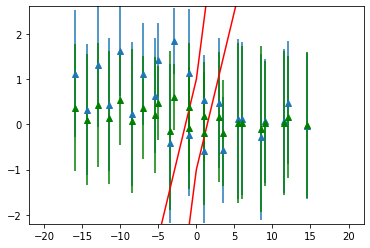

MAE 7.704124227864668
MSE 9.060089438157183
outside 0.9166666865348816

opt factor 0.3333333333333333, with div_factor 1
opt MAE 7.422346968022693
opt MSE 8.774142310118537
opt outside 0.875


In [36]:
def get_stats(df):
    ser = pd.Series()
    for col in df.select_dtypes(include=np.number).columns:
        ser[f'{col}_mean'] = df[col].mean()
        ser[f'{col}_std'] = df[col].std()
    return ser

def eval_model(model_, ds_, div_factor=1):
    results = np.concatenate([np.stack([model_.predict(x, batch_size=64, workers=4).flatten(), y], axis=1) for x, y in tfds.as_numpy(ds_)])
#     print(weighted_MAE(*tf.transpose(results)))
    df = pd.DataFrame(results, columns=['pred', 'true']).groupby('true').apply(get_stats)
    df.pred_mean *= div_factor
    min_error = 1
    final_opt_div_factor = 1
    for opt_div_factor in np.arange(1 / 3, 1 * 3, 1 / 30):
        error = np.average(np.asarray(np.abs(df.index - df.pred_mean * opt_div_factor) > 1 + 0.3 * np.abs(df.index), np.float32))
        if error < min_error:
            final_opt_div_factor = opt_div_factor
            min_error = error
    plt.errorbar(df.index, df.pred_mean, df.pred_std * 2, linestyle='None', marker='^')
    results_1 = \
        f"MAE {np.average(np.abs(df.index - df.pred_mean))}\n" + \
        f"MSE {np.sqrt(np.average(np.abs(df.index - df.pred_mean) ** 2))}\n" + \
        f"outside {np.average(np.asarray(np.abs(df.index - df.pred_mean) > 1 + 0.3 * np.abs(df.index), np.float32))}"
    
    df.pred_mean *= final_opt_div_factor
    plt.errorbar(df.index, df.pred_mean, df.pred_std * 2, linestyle='None', marker='^', color='green')
    results_2 = \
        f"opt factor {final_opt_div_factor}, with div_factor {div_factor}\n" + \
        f"opt MAE {np.average(np.abs(df.index - df.pred_mean))}\n" + \
        f"opt MSE {np.sqrt(np.average(np.abs(df.index - df.pred_mean) ** 2))}\n" + \
        f"opt outside {np.average(np.asarray(np.abs(df.index - df.pred_mean) > 1 + 0.3 * np.abs(df.index), np.float32))}"
    plt.plot([-20, 0, 20], [-27, -1, 13], color='red')
    plt.plot([-20, 0, 20], [-13, 1, 27], color='red')
    plt.ylim(min(df.pred_mean) - 2, max(df.pred_mean) + 2)
    plt.show()
    return results_1 + "\n\n" + results_2
    
print(eval_model(model, pipeline_test))

In [37]:
callbacks = [
    tf.keras.callbacks.TensorBoard(profile_batch=0,),
    tf.keras.callbacks.EarlyStopping(patience=10),
]

model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['mae', 'mse', weighted_MAE])
epochs = 100 #int(SCHEDULE_LENGTH / STEPS_PER_EPOCH)
# Fine-tune model
EVAL_FREQ = 4

In [31]:
print(f'Train for total of {epochs} epochs:')
for i in range(0, epochs, EVAL_FREQ):
    history = model.fit(
        pipeline_train,
        batch_size=BATCH_SIZE,
        steps_per_epoch=STEPS_PER_EPOCH,
        epochs=i+EVAL_FREQ,  # TODO: replace with `epochs=10` here to shorten fine-tuning for tutorial if you wish
        validation_data=pipeline_val,  # here we are only using 
                                       # this data to evaluate our performance
        workers=1,
        max_queue_size=10,
        verbose=2,
        initial_epoch=i,
        callbacks=callbacks,
    )
    
    print(f'Results on validation:')
    eval_model(model, pipeline_val)

ERROR:wandb.jupyter:Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


Train for total of 100 epochs:
Epoch 1/4


18/18 - 17s - loss: 4.8294 - mae: 4.8294 - mse: 38.1390 - weighted_MAE: 3.3893 - val_loss: 3.9401 - val_mae: 3.9401 - val_mse: 27.7271 - val_weighted_MAE: 2.3422
Epoch 2/4
18/18 - 16s - loss: 3.9954 - mae: 3.9954 - mse: 24.7932 - weighted_MAE: 2.1830 - val_loss: 3.7585 - val_mae: 3.7585 - val_mse: 24.4586 - val_weighted_MAE: 2.0904
Epoch 3/4
18/18 - 16s - loss: 3.2460 - mae: 3.2460 - mse: 17.6657 - weighted_MAE: 1.5873 - val_loss: 3.4140 - val_mae: 3.4140 - val_mse: 21.0161 - val_weighted_MAE: 1.7752
Epoch 4/4


KeyboardInterrupt: 

### See the results on test set
- The iterative training might result in `model` not being the *best model*, but the best of the last epoch
- This needs to be investigated, or graphs during training removed

2.9177243458373208
3.4874575166077664


/home/suchanek/anaconda3/envs/immortar/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


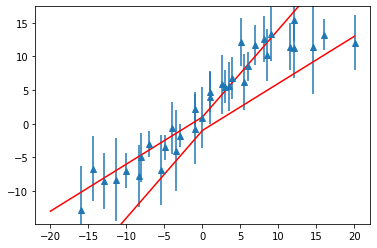

In [25]:
eval_model(model, pipeline_test)

### Store model

In [26]:
model.save(f"model_{major_version}.{minor_version}")

INFO:tensorflow:Assets written to: model_6.2/assets


INFO:tensorflow:Assets written to: model_6.2/assets


In [35]:
model = tf.keras.models.load_model(f"model_{major_version}.{minor_version}")

# Evaluate scaling

In [ ]:
results = []

for i in [j for j in range(12, 13) if j not in [1, 7, 9]]:
    exclude_series = [j for j in range(i + 1, 13) if j not in [1, 7, 9]]
    trained_series = [j for j in range(1, i + 1) if j not in [1, 7, 9] and j not in exclude_series]
    
    create_dataset(data_dir, csv, [7, 9], exclude_series)
    
    ds_train = get_raw_dataset(data_dir / 'train')
    ds_val = get_raw_dataset(data_dir / 'valid')
    ds_test = get_raw_dataset(data_dir / 'test')
    
    pipeline_train = (ds_train
                  .shuffle(10000)
                  .repeat(int(SCHEDULE_LENGTH * BATCH_SIZE / DATASET_NUM_TRAIN_EXAMPLES * STEPS_PER_EPOCH) + 1 + 50)  # repeat dataset_size / num_steps
                  .map(preprocess_train, num_parallel_calls=16)
                  .batch(BATCH_SIZE)
                  .map(mixup, num_parallel_calls=8)
                  .map(cast_to_tuple)  # for keras model.fit
                  .prefetch(2))

    pipeline_val = (ds_val.map(preprocess_test, num_parallel_calls=16)
                      .batch(BATCH_SIZE)
                      .map(cast_to_tuple)  # for keras model.fit
                      .cache()
                      .prefetch(2))

    pipeline_test = (ds_test.map(preprocess_test, num_parallel_calls=16)
                      .batch(BATCH_SIZE)
                      .map(cast_to_tuple)  # for keras model.fit
                      .cache()
                      .prefetch(2))
    
    model.fit(
        pipeline_train,
        batch_size=BATCH_SIZE,
        steps_per_epoch=STEPS_PER_EPOCH,
        epochs=5+10*len(trained_series),  # TODO: replace with `epochs=10` here to shorten fine-tuning for tutorial if you wish
        validation_data=pipeline_val,  # here we are only using 
                                       # this data to evaluate our performance
        workers=1,
        max_queue_size=10,
        verbose=2,
        initial_epoch=0,
        callbacks=callbacks,
    )
    
    print(f'Results on test trained on series {trained_series}:')
    mae = eval_model(model, pipeline_test)
    results.append((len(trained_series), mae))

Splitting ../data/india/0/ID111.mp4 to train
Splitting ../data/india/0/ID121.mp4 to train
Splitting ../data/india/0/ID117.mp4 to train
Splitting ../data/india/0/ID113.mp4 to train
Splitting ../data/india/0/I124.mp4 to train
Splitting ../data/india/0/I126.mp4 to train
Splitting ../data/india/0/I122.mp4 to train
Splitting ../data/india/0/ID115.mp4 to train
Splitting ../data/india/0/ID119.mp4 to train
Splitting ../data/india/0/I128.mp4 to train
Splitting ../data/india/0/I1210.mp4 to train
Splitting ../data/india/0/I134.mp4 to train
Splitting ../data/india/0/I1212.mp4 to train
Splitting ../data/india/0/I138.mp4 to train
Splitting ../data/india/0/I1312.mp4 to train
Splitting ../data/india/0/I1310.mp4 to train
Splitting ../data/india/0/I136.mp4 to train
Splitting ../data/india/0/I132.mp4 to train
Splitting ../data/india/0/I144.mp4 to train
Splitting ../data/india/0/I142.mp4 to train
Splitting ../data/india/0/ID120.mp4 to train
Splitting ../data/india/0/ID116.mp4 to train
Splitting ../data/in

27/27 - 21s - loss: 2.6357 - mae: 2.6357 - mse: 12.0652 - val_loss: 3.0766 - val_mae: 3.0766 - val_mse: 16.2951
Epoch 2/95
27/27 - 20s - loss: 2.6481 - mae: 2.6481 - mse: 12.0268 - val_loss: 2.9632 - val_mae: 2.9632 - val_mse: 15.1749
Epoch 3/95
27/27 - 20s - loss: 2.5217 - mae: 2.5217 - mse: 10.9010 - val_loss: 3.1434 - val_mae: 3.1434 - val_mse: 16.6131
Epoch 4/95
27/27 - 20s - loss: 2.5180 - mae: 2.5180 - mse: 10.7874 - val_loss: 3.1076 - val_mae: 3.1076 - val_mse: 16.7098
Epoch 5/95
27/27 - 20s - loss: 2.5284 - mae: 2.5284 - mse: 10.9679 - val_loss: 3.3718 - val_mae: 3.3718 - val_mse: 19.4152
Epoch 6/95
27/27 - 20s - loss: 2.4739 - mae: 2.4739 - mse: 10.5453 - val_loss: 3.4993 - val_mae: 3.4993 - val_mse: 20.5852
Epoch 7/95
27/27 - 20s - loss: 2.4866 - mae: 2.4866 - mse: 10.6624 - val_loss: 3.4204 - val_mae: 3.4204 - val_mse: 19.4022
Epoch 8/95
27/27 - 20s - loss: 2.5756 - mae: 2.5756 - mse: 11.1465 - val_loss: 3.6990 - val_mae: 3.6990 - val_mse: 22.3370
Epoch 9/95
27/27 - 20s - lo

In [7]:
results = [
    ([2], 8.44499319732189, 9.371550683755338),
    ([2, 3], 13.37575995853969, 15.029149723215783),
    ([2, 3, 4], 7.454638554879596, 8.954571078264255),
    ([2, 3, 4, 5], 8.240593127863747, 9.514434196136829),
    ([2, 3, 4, 5, 6], 5.521295046550888, 6.479377072750131),
    ([2, 3, 4, 5, 6, 8], 2.5415429869719914, 3.2072022896644303),
    ([2, 3, 4, 5, 6, 8, 10], 1.823140286888395, 2.1770566876465356),
    ([2, 3, 4, 5, 6, 8, 10, 11], 1.8589743707009725, 2.2091262306984163)
]

In [28]:
print(results)

[([2], 8.44499319732189, 9.371550683755338), ([2, 3], 13.37575995853969, 15.029149723215783), ([2, 3, 4], 7.454638554879596, 8.954571078264255), ([2, 3, 4, 5], 8.240593127863747, 9.514434196136829), ([2, 3, 4, 5, 6], 5.521295046550888, 6.479377072750131), ([2, 3, 4, 5, 6, 8], 2.5415429869719914, 3.2072022896644303), ([2, 3, 4, 5, 6, 8, 10], 1.823140286888395, 2.1770566876465356), ([2, 3, 4, 5, 6, 8, 10, 11], 1.8589743707009725, 2.2091262306984163)]


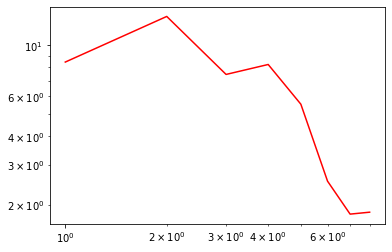

In [36]:
plt.plot([len(x[0]) for x in results], [x[1] for x in results], color='red')
plt.yscale("log")
plt.xscale("log")
plt.show()

23.040611174908634


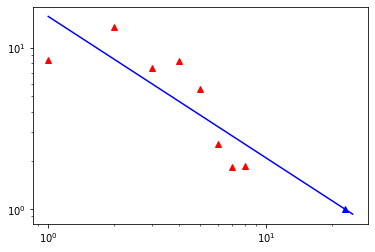

In [8]:
x = [np.log2(len(z[0])) for z in results]
y = [np.log2(z[1]) for z in results]

a, b = np.polyfit(x, y, 1)

plt.plot([len(x[0]) for x in results], [x[1] for x in results], color='red', linestyle='None', marker='^')

x = np.asarray((1, 25))
y = x ** a * np.exp2(b)
plt.plot(x, y, color='blue')

x_1 = (1 / np.exp2(b)) ** (1 / a)
print(x_1)
plt.plot([x_1], [1], color='blue', linestyle='None', marker='^')

plt.xticks([1, 2, 3, 4, 5, 10, 20])
plt.yscale("log")
plt.xscale("log")
plt.show()

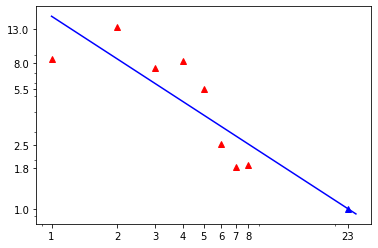

In [9]:
from matplotlib import pyplot as plt
import matplotlib.ticker

fig1, ax1 = plt.subplots()

ax1.plot([len(x[0]) for x in results], [x[1] for x in results], color='red', linestyle='None', marker='^')
ax1.plot(x, y, color='blue')
ax1.plot([x_1], [1], color='blue', linestyle='None', marker='^')

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 23])
ax1.set_yticks([1, 1.8, 2.5, 5.5, 8, 13])
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.show()

# Hyper search
The pipeline (= preprocessing, since it is tf.data) can be put inside the build_model function => we can search for MixUp alpha, batch_size, etc.
- There might be a problem with RAM overflow. Try `import gc; gc.collect()`.

In [ ]:
!pip install keras_tuner

In [23]:
import kerastuner as kt

def bit_tuning_model(module):
    def build_model(hp: kt.HyperParameters):
        input_ = tf.keras.layers.Input((CROP_TO, CROP_TO, 3))
        x = module(input_)   # Outputs feature vectors [None, 2048]
        
#         activation = hp.Choice(f'dense_activation', ['elu', 'relu'])
#         kernel_initializer = hp.Choice(f'kernel_initializer', 
#                                        ['glorot_normal', 'glorot_uniform',
#                                         'lecun_normal', 'lecun_uniform', ])
#         output_initializer = hp.Choice(f'kernel_initializer', 
#                                        ['glorot_normal', 'glorot_uniform',
#                                         'lecun_normal', 'lecun_uniform', ])
        
        for i in range(hp.Int('dense_repetition', 0, 4)):
            x = tf.keras.layers.Dropout(hp.Float(f'dropout_{i}', 0.0, 0.6))(x)
            x = tf.keras.layers.Dense(hp.Int(f'dense_units_{i}', int(2**(4-i)), int(16 * 2**(5-i)), sampling='log'),
                                      activation='relu',
                                      kernel_initializer='lecun_uniform')(x)
        x = tf.keras.layers.Dense(1, kernel_initializer='lecun_uniform')(x)

        model_ = tf.keras.Model(input_, x)
        
        callbacks = [
            tf.keras.callbacks.TensorBoard(profile_batch=0,),
            tf.keras.callbacks.EarlyStopping(patience=10),
        ]
        
        optimizer_name = hp.Choice(f'optimizer_name', ['ranger'])
        initial_lr = hp.Choice('initial_lr', [3e-2, 1.5e-2, 8e-3, 5e-3, 3e-3])
        
        if optimizer_name == 'sgd':
            lr = initial_lr * BATCH_SIZE / 512 
            # Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
            lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES, 
                                                                               values=[lr, lr*0.1, lr*0.001, lr*0.0001])
            optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)
            
        if optimizer_name == 'adam':
            optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)
            
        if optimizer_name == 'ranger':
            # add flat cos anealing from https://github.com/ronaldluc/DeepSaber/blob/52059b627a343ffacbb6f2711337569079b29916/src/train/learning_rate_schedule.py#L10
            optimizer = tfa.optimizers.RectifiedAdam(learning_rate=initial_lr,   
                                        beta_1=0.95,
                                        beta_2=0.99,
                                        epsilon=1e-6)
            optimizer = tfa.optimizers.Lookahead(optimizer)
            
        loss_name = hp.Choice(f'loss_name', ['MAE'])
        
        loss_fn = {
            'MAE': tf.keras.losses.MAE,
            'MSE': tf.keras.losses.MSE,
            'MAPE': tf.keras.losses.MeanAbsolutePercentageError,
        }[loss_name]

        model_.compile(optimizer=optimizer,
                      loss=loss_fn,
                      metrics=['mae', 'mse'])
        
        return model_
    return build_model

INFO:tensorflow:Reloading Oracle from existing project ../hyper_search/bit_2/oracle.json


INFO:tensorflow:Reloading Oracle from existing project ../hyper_search/bit_2/oracle.json


Epoch 1/4


27/27 - 26s - loss: 5.7474 - mae: 5.7474 - mse: 56.6695 - val_loss: 4.3440 - val_mae: 4.3440 - val_mse: 33.7448
Epoch 2/4
27/27 - 24s - loss: 3.5427 - mae: 3.5427 - mse: 20.3135 - val_loss: 3.6233 - val_mae: 3.6233 - val_mse: 24.0322
Epoch 3/4
27/27 - 24s - loss: 3.0558 - mae: 3.0558 - mse: 15.1964 - val_loss: 3.4994 - val_mae: 3.4994 - val_mse: 21.5463
Epoch 4/4
27/27 - 23s - loss: 2.8982 - mae: 2.8982 - mse: 13.7654 - val_loss: 3.6263 - val_mae: 3.6263 - val_mse: 22.0443


Epoch 1/4
27/27 - 24s - loss: 476.6151 - mae: 12.5328 - mse: 476.6151 - val_loss: 86.9160 - val_mae: 7.5927 - val_mse: 86.9160
Epoch 2/4
27/27 - 24s - loss: 69.4700 - mae: 6.8293 - mse: 69.4700 - val_loss: 82.7421 - val_mae: 7.5554 - val_mse: 82.7421
Epoch 3/4
27/27 - 24s - loss: 59.6814 - mae: 6.3820 - mse: 59.6814 - val_loss: 80.9765 - val_mae: 7.4675 - val_mse: 80.9765
Epoch 4/4
27/27 - 24s - loss: 56.8054 - mae: 6.2066 - mse: 56.8054 - val_loss: 80.3405 - val_mae: 7.4383 - val_mse: 80.3405


Epoch 1/4


27/27 - 24s - loss: 13276.0400 - mae: 52.4359 - mse: 13276.0400 - val_loss: 80.5848 - val_mae: 7.4508 - val_mse: 80.5848
Epoch 2/4
27/27 - 24s - loss: 55.5053 - mae: 6.1198 - mse: 55.5053 - val_loss: 80.5263 - val_mae: 7.4480 - val_mse: 80.5263
Epoch 3/4
27/27 - 24s - loss: 55.5046 - mae: 6.0914 - mse: 55.5046 - val_loss: 80.5259 - val_mae: 7.4480 - val_mse: 80.5259
Epoch 4/4
27/27 - 24s - loss: 59.3117 - mae: 6.3777 - mse: 59.3117 - val_loss: 80.5257 - val_mae: 7.4480 - val_mse: 80.5257


Epoch 1/4


27/27 - 24s - loss: 312.6688 - mae: 10.9864 - mse: 312.6688 - val_loss: 85.9632 - val_mae: 7.7074 - val_mse: 85.9632
Epoch 2/4
27/27 - 24s - loss: 55.0291 - mae: 6.0195 - mse: 55.0291 - val_loss: 62.6077 - val_mae: 6.3732 - val_mse: 62.6077
Epoch 3/4
27/27 - 24s - loss: 37.9447 - mae: 4.7807 - mse: 37.9447 - val_loss: 48.6126 - val_mae: 5.3910 - val_mse: 48.6126
Epoch 4/4
27/27 - 24s - loss: 34.4468 - mae: 4.5953 - mse: 34.4468 - val_loss: 38.4965 - val_mae: 4.6769 - val_mse: 38.4965


Epoch 1/4


27/27 - 24s - loss: 7.2751 - mae: 7.2751 - mse: 107.1081 - val_loss: 4.6570 - val_mae: 4.6570 - val_mse: 40.1756
Epoch 2/4
27/27 - 24s - loss: 4.2962 - mae: 4.2962 - mse: 29.8848 - val_loss: 4.3116 - val_mae: 4.3116 - val_mse: 32.8614
Epoch 3/4
27/27 - 24s - loss: 3.7968 - mae: 3.7968 - mse: 23.4913 - val_loss: 4.3386 - val_mae: 4.3386 - val_mse: 31.6336
Epoch 4/4
27/27 - 24s - loss: 3.6617 - mae: 3.6617 - mse: 21.5972 - val_loss: 3.8748 - val_mae: 3.8748 - val_mse: 26.7685


Epoch 1/4
27/27 - 24s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 2/4
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 3/4
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 4/4
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan


/home/suchanek/anaconda3/envs/immortar/lib/python3.7/site-packages/kerastuner/engine/metrics_tracking.py:92: RuntimeWarning: All-NaN axis encountered
  return np.nanmin(values)


Epoch 1/4


27/27 - 24s - loss: 20.8572 - mae: 20.8572 - mse: 730.2148 - val_loss: 9.6691 - val_mae: 9.6691 - val_mse: 129.7000
Epoch 2/4
27/27 - 24s - loss: 4.7945 - mae: 4.7945 - mse: 37.5636 - val_loss: 4.1934 - val_mae: 4.1934 - val_mse: 28.0549
Epoch 3/4
27/27 - 24s - loss: 3.3533 - mae: 3.3533 - mse: 18.2098 - val_loss: 3.7235 - val_mae: 3.7235 - val_mse: 23.1144
Epoch 4/4
27/27 - 23s - loss: 3.4408 - mae: 3.4408 - mse: 18.9840 - val_loss: 4.3471 - val_mae: 4.3471 - val_mse: 30.5906


Epoch 1/4


27/27 - 24s - loss: 5.4055 - mae: 5.4055 - mse: 45.9027 - val_loss: 4.6236 - val_mae: 4.6236 - val_mse: 35.7798
Epoch 2/4
27/27 - 24s - loss: 4.1870 - mae: 4.1870 - mse: 28.0306 - val_loss: 4.0694 - val_mae: 4.0694 - val_mse: 28.6513
Epoch 3/4
27/27 - 24s - loss: 3.8110 - mae: 3.8110 - mse: 23.0164 - val_loss: 4.0276 - val_mae: 4.0276 - val_mse: 27.3497
Epoch 4/4
27/27 - 24s - loss: 3.5907 - mae: 3.5907 - mse: 20.7628 - val_loss: 3.6611 - val_mae: 3.6611 - val_mse: 23.6511


Epoch 1/4
27/27 - 24s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 2/4
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 3/4
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 4/4
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan


Epoch 1/4


27/27 - 24s - loss: 32.1070 - mae: 4.5074 - mse: 32.1070 - val_loss: 32.9070 - val_mae: 4.1786 - val_mse: 32.9070
Epoch 2/4
27/27 - 24s - loss: 20.7028 - mae: 3.6074 - mse: 20.7028 - val_loss: 24.9390 - val_mae: 3.6581 - val_mse: 24.9390
Epoch 3/4
27/27 - 24s - loss: 17.0106 - mae: 3.2814 - mse: 17.0106 - val_loss: 22.5897 - val_mae: 3.6593 - val_mse: 22.5897
Epoch 4/4
27/27 - 24s - loss: 14.9031 - mae: 3.0309 - mse: 14.9031 - val_loss: 21.0741 - val_mae: 3.4556 - val_mse: 21.0741


Epoch 1/4


27/27 - 24s - loss: 26.0333 - mae: 26.0333 - mse: 1069.0000 - val_loss: 6.4858 - val_mae: 6.4858 - val_mse: 66.4105
Epoch 2/4
27/27 - 24s - loss: 6.8656 - mae: 6.8656 - mse: 76.2652 - val_loss: 4.6938 - val_mae: 4.6938 - val_mse: 34.9783
Epoch 3/4
27/27 - 24s - loss: 4.6166 - mae: 4.6166 - mse: 32.0141 - val_loss: 3.9814 - val_mae: 3.9814 - val_mse: 25.6053
Epoch 4/4
27/27 - 23s - loss: 3.4555 - mae: 3.4555 - mse: 19.0121 - val_loss: 4.0251 - val_mae: 4.0251 - val_mse: 27.0159


Epoch 1/4
27/27 - 24s - loss: 9.0160 - mae: 9.0160 - mse: 133.6550 - val_loss: 4.9357 - val_mae: 4.9357 - val_mse: 41.5789
Epoch 2/4
27/27 - 24s - loss: 5.1564 - mae: 5.1564 - mse: 41.4926 - val_loss: 4.7218 - val_mae: 4.7218 - val_mse: 39.0788
Epoch 3/4
27/27 - 24s - loss: 4.4868 - mae: 4.4868 - mse: 32.4436 - val_loss: 4.5338 - val_mae: 4.5338 - val_mse: 36.3642
Epoch 4/4
27/27 - 24s - loss: 4.3100 - mae: 4.3100 - mse: 29.6952 - val_loss: 4.4187 - val_mae: 4.4187 - val_mse: 34.9040


Epoch 1/4


27/27 - 24s - loss: 109.8201 - mae: 109.8201 - mse: 26419.5859 - val_loss: 13.6606 - val_mae: 13.6606 - val_mse: 284.2153
Epoch 2/4
27/27 - 24s - loss: 8.5281 - mae: 8.5281 - mse: 137.7241 - val_loss: 9.5616 - val_mae: 9.5616 - val_mse: 147.7786
Epoch 3/4
27/27 - 24s - loss: 4.7337 - mae: 4.7337 - mse: 35.0583 - val_loss: 5.6603 - val_mae: 5.6603 - val_mse: 48.0103
Epoch 4/4
27/27 - 24s - loss: 3.4209 - mae: 3.4209 - mse: 18.9343 - val_loss: 3.5770 - val_mae: 3.5770 - val_mse: 22.7836


Epoch 1/4
27/27 - 24s - loss: 11.0850 - mae: 11.0850 - mse: 223.5782 - val_loss: 8.1825 - val_mae: 8.1825 - val_mse: 98.1827
Epoch 2/4
27/27 - 24s - loss: 7.5587 - mae: 7.5587 - mse: 86.7254 - val_loss: 7.5064 - val_mae: 7.5064 - val_mse: 81.6755
Epoch 3/4
27/27 - 23s - loss: 6.5822 - mae: 6.5822 - mse: 64.7977 - val_loss: 8.2359 - val_mae: 8.2359 - val_mse: 99.6682
Epoch 4/4
27/27 - 24s - loss: 6.3936 - mae: 6.3936 - mse: 60.1672 - val_loss: 7.3882 - val_mae: 7.3882 - val_mse: 79.7638


Epoch 1/4
27/27 - 24s - loss: 5.8972 - mae: 5.8972 - mse: 54.5359 - val_loss: 7.5802 - val_mae: 7.5802 - val_mse: 86.5878
Epoch 2/4
27/27 - 24s - loss: 6.3413 - mae: 6.3413 - mse: 60.1907 - val_loss: 7.3870 - val_mae: 7.3870 - val_mse: 79.7578
Epoch 3/4
27/27 - 23s - loss: 6.4655 - mae: 6.4655 - mse: 61.2396 - val_loss: 7.4599 - val_mae: 7.4599 - val_mse: 80.7888
Epoch 4/4
27/27 - 23s - loss: 6.3352 - mae: 6.3352 - mse: 58.8903 - val_loss: 7.3985 - val_mae: 7.3985 - val_mse: 79.8466


Epoch 1/4
27/27 - 24s - loss: 5.9674 - mae: 5.9674 - mse: 54.3946 - val_loss: 7.1831 - val_mae: 7.1831 - val_mse: 76.1916
Epoch 2/4
27/27 - 24s - loss: 5.5573 - mae: 5.5573 - mse: 47.7583 - val_loss: 5.0407 - val_mae: 5.0407 - val_mse: 43.5728
Epoch 3/4
27/27 - 23s - loss: 5.3618 - mae: 5.3618 - mse: 44.4478 - val_loss: 7.3496 - val_mae: 7.3496 - val_mse: 78.3140
Epoch 4/4
27/27 - 23s - loss: 6.2869 - mae: 6.2869 - mse: 57.9746 - val_loss: 7.2714 - val_mae: 7.2714 - val_mse: 78.9782


Epoch 1/4
27/27 - 24s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 2/4
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 3/4
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 4/4
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan


Epoch 1/4


27/27 - 24s - loss: 39.7286 - mae: 4.9847 - mse: 39.7286 - val_loss: 48.2966 - val_mae: 5.3419 - val_mse: 48.2966
Epoch 2/4
27/27 - 24s - loss: 27.2293 - mae: 4.1565 - mse: 27.2293 - val_loss: 35.1424 - val_mae: 4.4074 - val_mse: 35.1424
Epoch 3/4
27/27 - 24s - loss: 22.8383 - mae: 3.8117 - mse: 22.8383 - val_loss: 27.3966 - val_mae: 3.9159 - val_mse: 27.3966
Epoch 4/4
27/27 - 24s - loss: 19.2619 - mae: 3.4898 - mse: 19.2619 - val_loss: 25.0498 - val_mae: 3.7649 - val_mse: 25.0498


Epoch 1/4


27/27 - 24s - loss: 38.3922 - mae: 4.9458 - mse: 38.3922 - val_loss: 37.4243 - val_mae: 4.5512 - val_mse: 37.4243
Epoch 2/4
27/27 - 24s - loss: 28.0069 - mae: 4.2040 - mse: 28.0069 - val_loss: 30.3060 - val_mae: 4.0629 - val_mse: 30.3060
Epoch 3/4
27/27 - 24s - loss: 22.4126 - mae: 3.7415 - mse: 22.4126 - val_loss: 26.8817 - val_mae: 3.8638 - val_mse: 26.8817
Epoch 4/4
27/27 - 24s - loss: 19.5888 - mae: 3.5038 - mse: 19.5888 - val_loss: 22.0377 - val_mae: 3.5216 - val_mse: 22.0377


Epoch 1/4


27/27 - 24s - loss: 13.0751 - mae: 13.0751 - mse: 1039.4366 - val_loss: 7.4374 - val_mae: 7.4374 - val_mse: 80.3254
Epoch 2/4
27/27 - 24s - loss: 6.1703 - mae: 6.1703 - mse: 57.1129 - val_loss: 7.3830 - val_mae: 7.3830 - val_mse: 79.7640
Epoch 3/4
27/27 - 23s - loss: 6.2599 - mae: 6.2599 - mse: 58.5670 - val_loss: 7.4598 - val_mae: 7.4598 - val_mse: 80.7873
Epoch 4/4
27/27 - 23s - loss: 6.2838 - mae: 6.2838 - mse: 58.5107 - val_loss: 7.4567 - val_mae: 7.4567 - val_mse: 80.7139


Epoch 1/4


27/27 - 24s - loss: 68.2534 - mae: 6.7522 - mse: 68.2534 - val_loss: 81.1238 - val_mae: 7.4755 - val_mse: 81.1238
Epoch 2/4
27/27 - 24s - loss: 57.7923 - mae: 6.2363 - mse: 57.7923 - val_loss: 81.1234 - val_mae: 7.4755 - val_mse: 81.1234
Epoch 3/4
27/27 - 24s - loss: 58.3025 - mae: 6.3193 - mse: 58.3025 - val_loss: 81.1199 - val_mae: 7.4753 - val_mse: 81.1199
Epoch 4/4
27/27 - 24s - loss: 57.8799 - mae: 6.2422 - mse: 57.8799 - val_loss: 81.1126 - val_mae: 7.4748 - val_mse: 81.1126


Epoch 1/4


27/27 - 24s - loss: 32138.1328 - mae: 169.1774 - mse: 32138.1328 - val_loss: 30330.8848 - val_mae: 173.9285 - val_mse: 30330.8848
Epoch 2/4
27/27 - 24s - loss: 30029.1953 - mae: 173.1205 - mse: 30029.1953 - val_loss: 30268.7969 - val_mae: 173.7499 - val_mse: 30268.7969
Epoch 3/4
27/27 - 24s - loss: 29894.1621 - mae: 172.7230 - mse: 29894.1621 - val_loss: 30164.4570 - val_mae: 173.4494 - val_mse: 30164.4570
Epoch 4/4
27/27 - 24s - loss: 29749.6953 - mae: 172.3112 - mse: 29749.6953 - val_loss: 30064.1445 - val_mae: 173.1600 - val_mse: 30064.1445


Epoch 1/4


27/27 - 24s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 2/4
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 3/4
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 4/4
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan


Epoch 1/4


27/27 - 24s - loss: 5.6487 - mae: 5.6487 - mse: 50.3444 - val_loss: 5.5734 - val_mae: 5.5734 - val_mse: 49.9664
Epoch 2/4
27/27 - 24s - loss: 4.6536 - mae: 4.6536 - mse: 34.8882 - val_loss: 4.9752 - val_mae: 4.9752 - val_mse: 41.3330
Epoch 3/4
27/27 - 24s - loss: 4.3775 - mae: 4.3775 - mse: 30.4595 - val_loss: 4.2046 - val_mae: 4.2046 - val_mse: 30.2227
Epoch 4/4
27/27 - 24s - loss: 3.9935 - mae: 3.9935 - mse: 25.9911 - val_loss: 4.1345 - val_mae: 4.1345 - val_mse: 29.9277


Epoch 1/4


27/27 - 24s - loss: 54.1443 - mae: 5.9795 - mse: 54.1443 - val_loss: 67.3407 - val_mae: 6.6666 - val_mse: 67.3407
Epoch 2/4
27/27 - 24s - loss: 47.4861 - mae: 5.5439 - mse: 47.4861 - val_loss: 59.8343 - val_mae: 6.1852 - val_mse: 59.8343
Epoch 3/4
27/27 - 24s - loss: 42.9564 - mae: 5.2647 - mse: 42.9564 - val_loss: 51.6405 - val_mae: 5.6333 - val_mse: 51.6405
Epoch 4/4
27/27 - 24s - loss: 35.3841 - mae: 4.7106 - mse: 35.3841 - val_loss: 47.4620 - val_mae: 5.3684 - val_mse: 47.4620


Epoch 1/4


27/27 - 24s - loss: 5.7652 - mae: 5.7652 - mse: 50.7316 - val_loss: 5.9854 - val_mae: 5.9854 - val_mse: 56.6314
Epoch 2/4
27/27 - 24s - loss: 4.3460 - mae: 4.3460 - mse: 30.0761 - val_loss: 4.3773 - val_mae: 4.3773 - val_mse: 34.8094
Epoch 3/4
27/27 - 24s - loss: 3.6860 - mae: 3.6860 - mse: 21.4315 - val_loss: 3.9804 - val_mae: 3.9804 - val_mse: 28.8137
Epoch 4/4
27/27 - 24s - loss: 3.4206 - mae: 3.4206 - mse: 18.4557 - val_loss: 3.7674 - val_mae: 3.7674 - val_mse: 25.3752


Epoch 1/4
27/27 - 24s - loss: 6.1701 - mae: 6.1701 - mse: 57.3933 - val_loss: 6.6595 - val_mae: 6.6595 - val_mse: 68.0589
Epoch 2/4
27/27 - 24s - loss: 5.3027 - mae: 5.3027 - mse: 43.8244 - val_loss: 5.8575 - val_mae: 5.8575 - val_mse: 54.8091
Epoch 3/4
27/27 - 24s - loss: 4.7530 - mae: 4.7530 - mse: 37.8851 - val_loss: 5.6207 - val_mae: 5.6207 - val_mse: 51.1939
Epoch 4/4
27/27 - 24s - loss: 4.5570 - mae: 4.5570 - mse: 33.4255 - val_loss: 5.0446 - val_mae: 5.0446 - val_mse: 42.6275


Epoch 1/4


27/27 - 24s - loss: 55.2938 - mae: 55.2938 - mse: 9705.9248 - val_loss: 7.6602 - val_mae: 7.6602 - val_mse: 88.0127
Epoch 2/4
27/27 - 24s - loss: 5.4319 - mae: 5.4319 - mse: 46.0335 - val_loss: 4.9959 - val_mae: 4.9959 - val_mse: 42.0991
Epoch 3/4
27/27 - 24s - loss: 3.8248 - mae: 3.8248 - mse: 23.8704 - val_loss: 4.4016 - val_mae: 4.4016 - val_mse: 34.5737
Epoch 4/4
27/27 - 24s - loss: 3.4757 - mae: 3.4757 - mse: 19.3986 - val_loss: 3.9382 - val_mae: 3.9382 - val_mse: 27.1408


Epoch 1/4


27/27 - 24s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 2/4
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 3/4
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 4/4
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan


Epoch 1/4


27/27 - 24s - loss: 61.7044 - mae: 5.8007 - mse: 61.7044 - val_loss: 29.2784 - val_mae: 4.0501 - val_mse: 29.2784
Epoch 2/4
27/27 - 24s - loss: 25.3632 - mae: 3.9772 - mse: 25.3632 - val_loss: 25.4704 - val_mae: 4.0062 - val_mse: 25.4704
Epoch 3/4
27/27 - 24s - loss: 21.8204 - mae: 3.6020 - mse: 21.8204 - val_loss: 21.4877 - val_mae: 3.5844 - val_mse: 21.4877
Epoch 4/4
27/27 - 23s - loss: 19.7643 - mae: 3.4778 - mse: 19.7643 - val_loss: 22.7604 - val_mae: 3.7275 - val_mse: 22.7604


Epoch 1/4


27/27 - 24s - loss: 4.5130 - mae: 4.5130 - mse: 32.3731 - val_loss: 4.2974 - val_mae: 4.2974 - val_mse: 33.1659
Epoch 2/4
27/27 - 24s - loss: 3.6000 - mae: 3.6000 - mse: 20.5300 - val_loss: 3.7651 - val_mae: 3.7651 - val_mse: 24.9958
Epoch 3/4
27/27 - 24s - loss: 3.3174 - mae: 3.3174 - mse: 17.7295 - val_loss: 3.7968 - val_mae: 3.7968 - val_mse: 24.8370
Epoch 4/4
27/27 - 24s - loss: 3.2463 - mae: 3.2463 - mse: 17.2807 - val_loss: 3.7233 - val_mae: 3.7233 - val_mse: 24.1992


Epoch 1/4


27/27 - 24s - loss: 147.3211 - mae: 8.2155 - mse: 147.3211 - val_loss: 79.7590 - val_mae: 7.3873 - val_mse: 79.7590
Epoch 2/4
27/27 - 23s - loss: 60.6497 - mae: 6.4048 - mse: 60.6497 - val_loss: 79.8025 - val_mae: 7.3912 - val_mse: 79.8025
Epoch 3/4
27/27 - 23s - loss: 59.6129 - mae: 6.3616 - mse: 59.6129 - val_loss: 79.9123 - val_mae: 7.4066 - val_mse: 79.9123
Epoch 4/4
27/27 - 23s - loss: 57.1730 - mae: 6.1909 - mse: 57.1730 - val_loss: 80.0385 - val_mae: 7.4183 - val_mse: 80.0385


Epoch 1/4


27/27 - 24s - loss: 10.3382 - mae: 10.3382 - mse: 731.3878 - val_loss: 5.8920 - val_mae: 5.8920 - val_mse: 53.4679
Epoch 2/4
27/27 - 24s - loss: 3.7660 - mae: 3.7660 - mse: 22.9266 - val_loss: 4.3126 - val_mae: 4.3126 - val_mse: 30.7094
Epoch 3/4
27/27 - 24s - loss: 3.1407 - mae: 3.1407 - mse: 15.9238 - val_loss: 3.4998 - val_mae: 3.4998 - val_mse: 21.9302
Epoch 4/4
27/27 - 24s - loss: 3.0774 - mae: 3.0774 - mse: 15.4842 - val_loss: 3.2599 - val_mae: 3.2599 - val_mse: 18.6717


Epoch 1/4


27/27 - 24s - loss: 58.4212 - mae: 6.2727 - mse: 58.4212 - val_loss: 80.7653 - val_mae: 7.4589 - val_mse: 80.7653
Epoch 2/4
27/27 - 24s - loss: 57.2559 - mae: 6.2109 - mse: 57.2559 - val_loss: 80.6755 - val_mae: 7.4550 - val_mse: 80.6755
Epoch 3/4
27/27 - 24s - loss: 58.6135 - mae: 6.3281 - mse: 58.6135 - val_loss: 80.5371 - val_mae: 7.4485 - val_mse: 80.5371
Epoch 4/4
27/27 - 23s - loss: 59.2683 - mae: 6.3395 - mse: 59.2683 - val_loss: 80.5689 - val_mae: 7.4500 - val_mse: 80.5689


Epoch 1/4


27/27 - 24s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 2/4
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 3/4
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 4/4
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan


Epoch 1/4


27/27 - 25s - loss: 8.5123 - mae: 8.5123 - mse: 161.3859 - val_loss: 7.4721 - val_mae: 7.4721 - val_mse: 81.0682
Epoch 2/4
27/27 - 24s - loss: 6.0785 - mae: 6.0785 - mse: 55.6885 - val_loss: 7.4223 - val_mae: 7.4223 - val_mse: 80.0898
Epoch 3/4
27/27 - 23s - loss: 6.3604 - mae: 6.3604 - mse: 59.7059 - val_loss: 7.5258 - val_mae: 7.5258 - val_mse: 82.0696
Epoch 4/4
27/27 - 23s - loss: 6.3132 - mae: 6.3132 - mse: 59.2429 - val_loss: 7.4638 - val_mae: 7.4638 - val_mse: 80.8841


Epoch 1/4


27/27 - 24s - loss: 60.8219 - mae: 6.4538 - mse: 60.8219 - val_loss: 79.7652 - val_mae: 7.3829 - val_mse: 79.7652
Epoch 2/4
27/27 - 23s - loss: 60.0094 - mae: 6.3676 - mse: 60.0094 - val_loss: 79.7863 - val_mae: 7.3907 - val_mse: 79.7863
Epoch 3/4
27/27 - 23s - loss: 61.0876 - mae: 6.4509 - mse: 61.0876 - val_loss: 80.7120 - val_mae: 7.4566 - val_mse: 80.7120
Epoch 4/4
27/27 - 23s - loss: 57.9639 - mae: 6.2491 - mse: 57.9639 - val_loss: 79.8976 - val_mae: 7.3964 - val_mse: 79.8976


Epoch 1/4


27/27 - 24s - loss: 10405144726574465024.0000 - mae: 2854514176.0000 - mse: 10405144726574465024.0000 - val_loss: 9494367568241098752.0000 - val_mae: 3049730304.0000 - val_mse: 9494367568241098752.0000
Epoch 2/4
27/27 - 23s - loss: 11221891650500427776.0000 - mae: 3341960960.0000 - mse: 11221891650500427776.0000 - val_loss: 9494367568241098752.0000 - val_mae: 3049730304.0000 - val_mse: 9494367568241098752.0000
Epoch 3/4
27/27 - 23s - loss: 11158063900996403200.0000 - mae: 3331790080.0000 - mse: 11158063900996403200.0000 - val_loss: 9494367568241098752.0000 - val_mae: 3049730304.0000 - val_mse: 9494367568241098752.0000
Epoch 4/4
27/27 - 23s - loss: 11177019481459261440.0000 - mae: 3334585856.0000 - mse: 11177019481459261440.0000 - val_loss: 9494367568241098752.0000 - val_mae: 3049730304.0000 - val_mse: 9494367568241098752.0000


Epoch 1/4


27/27 - 25s - loss: 46.9537 - mae: 5.4710 - mse: 46.9537 - val_loss: 51.2907 - val_mae: 5.5843 - val_mse: 51.2907
Epoch 2/4
27/27 - 24s - loss: 23.5991 - mae: 3.8302 - mse: 23.5991 - val_loss: 36.0634 - val_mae: 4.5304 - val_mse: 36.0634
Epoch 3/4
27/27 - 24s - loss: 19.4900 - mae: 3.5385 - mse: 19.4900 - val_loss: 32.9740 - val_mae: 4.3443 - val_mse: 32.9740
Epoch 4/4
27/27 - 24s - loss: 17.1441 - mae: 3.2951 - mse: 17.1441 - val_loss: 29.1862 - val_mae: 4.1022 - val_mse: 29.1862


Epoch 1/4
27/27 - 24s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 2/4
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 3/4
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 4/4
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan


Epoch 1/4


27/27 - 24s - loss: 5.1877 - mae: 5.1877 - mse: 44.3392 - val_loss: 3.8520 - val_mae: 3.8520 - val_mse: 27.3269
Epoch 2/4
27/27 - 23s - loss: 3.7617 - mae: 3.7617 - mse: 22.1315 - val_loss: 4.4705 - val_mae: 4.4705 - val_mse: 33.5879
Epoch 3/4
27/27 - 24s - loss: 3.3773 - mae: 3.3773 - mse: 18.4759 - val_loss: 3.6468 - val_mae: 3.6468 - val_mse: 23.3740
Epoch 4/4
27/27 - 23s - loss: 3.2988 - mae: 3.2988 - mse: 18.1255 - val_loss: 3.8847 - val_mae: 3.8847 - val_mse: 25.5109


Epoch 1/4
27/27 - 24s - loss: 32.2099 - mae: 4.4988 - mse: 32.2099 - val_loss: 39.0205 - val_mae: 4.8458 - val_mse: 39.0205
Epoch 2/4
27/27 - 24s - loss: 20.6746 - mae: 3.6017 - mse: 20.6746 - val_loss: 24.2341 - val_mae: 3.7494 - val_mse: 24.2341
Epoch 3/4
27/27 - 24s - loss: 19.3197 - mae: 3.4466 - mse: 19.3197 - val_loss: 23.1220 - val_mae: 3.7319 - val_mse: 23.1220
Epoch 4/4
27/27 - 24s - loss: 15.9514 - mae: 3.1736 - mse: 15.9514 - val_loss: 21.9178 - val_mae: 3.5858 - val_mse: 21.9178


Epoch 1/4
27/27 - 24s - loss: 6.0219 - mae: 6.0219 - mse: 57.4278 - val_loss: 7.4636 - val_mae: 7.4636 - val_mse: 80.5823
Epoch 2/4
27/27 - 24s - loss: 5.8784 - mae: 5.8784 - mse: 53.0907 - val_loss: 6.5589 - val_mae: 6.5589 - val_mse: 68.2942
Epoch 3/4
27/27 - 24s - loss: 5.1254 - mae: 5.1254 - mse: 41.9056 - val_loss: 5.3539 - val_mae: 5.3539 - val_mse: 46.8030
Epoch 4/4
27/27 - 23s - loss: 5.0771 - mae: 5.0771 - mse: 41.0798 - val_loss: 7.3870 - val_mae: 7.3870 - val_mse: 79.7563


Epoch 1/4


27/27 - 24s - loss: 47.9742 - mae: 5.4824 - mse: 47.9742 - val_loss: 36.7078 - val_mae: 4.5079 - val_mse: 36.7078
Epoch 2/4
27/27 - 24s - loss: 30.3845 - mae: 4.3311 - mse: 30.3845 - val_loss: 30.2347 - val_mae: 4.0302 - val_mse: 30.2347
Epoch 3/4
27/27 - 23s - loss: 25.8028 - mae: 3.9992 - mse: 25.8028 - val_loss: 35.6727 - val_mae: 4.5427 - val_mse: 35.6727
Epoch 4/4
27/27 - 23s - loss: 25.3807 - mae: 4.0184 - mse: 25.3807 - val_loss: 30.9910 - val_mae: 4.1836 - val_mse: 30.9910


Epoch 1/4


27/27 - 24s - loss: 4.8034 - mae: 4.8034 - mse: 38.0595 - val_loss: 4.6497 - val_mae: 4.6497 - val_mse: 36.7777
Epoch 2/4
27/27 - 24s - loss: 3.5260 - mae: 3.5260 - mse: 20.1120 - val_loss: 3.5863 - val_mae: 3.5863 - val_mse: 22.2725
Epoch 3/4
27/27 - 24s - loss: 3.3607 - mae: 3.3607 - mse: 18.4582 - val_loss: 3.2841 - val_mae: 3.2841 - val_mse: 18.9917
Epoch 4/4
27/27 - 23s - loss: 3.3216 - mae: 3.3216 - mse: 18.3881 - val_loss: 3.9142 - val_mae: 3.9142 - val_mse: 26.5936


Epoch 1/4
27/27 - 24s - loss: 6.2003 - mae: 6.2003 - mse: 57.7575 - val_loss: 7.2995 - val_mae: 7.2995 - val_mse: 77.7745
Epoch 2/4
27/27 - 24s - loss: 5.6907 - mae: 5.6907 - mse: 50.2877 - val_loss: 7.2932 - val_mae: 7.2932 - val_mse: 77.6591
Epoch 3/4
27/27 - 24s - loss: 5.6857 - mae: 5.6857 - mse: 49.3054 - val_loss: 7.1367 - val_mae: 7.1367 - val_mse: 74.6678
Epoch 4/4
27/27 - 23s - loss: 5.5649 - mae: 5.5649 - mse: 47.7917 - val_loss: 7.2165 - val_mae: 7.2165 - val_mse: 76.1339


Epoch 1/4


27/27 - 24s - loss: 5.0110 - mae: 5.0110 - mse: 39.6571 - val_loss: 5.5863 - val_mae: 5.5863 - val_mse: 52.2946
Epoch 2/4
27/27 - 24s - loss: 4.5842 - mae: 4.5842 - mse: 34.0002 - val_loss: 5.0025 - val_mae: 5.0025 - val_mse: 44.3516
Epoch 3/4
27/27 - 24s - loss: 4.0854 - mae: 4.0854 - mse: 27.2911 - val_loss: 4.4577 - val_mae: 4.4577 - val_mse: 36.7409
Epoch 4/4
27/27 - 24s - loss: 3.8595 - mae: 3.8595 - mse: 23.8951 - val_loss: 4.2663 - val_mae: 4.2663 - val_mse: 33.5127


Epoch 1/4


27/27 - 24s - loss: 21492674.0000 - mae: 4190.0303 - mse: 21492674.0000 - val_loss: 15750542.0000 - val_mae: 3968.6848 - val_mse: 15750542.0000
Epoch 2/4
27/27 - 24s - loss: 15731275.0000 - mae: 3966.2598 - mse: 15731275.0000 - val_loss: 15725798.0000 - val_mae: 3965.5667 - val_mse: 15725798.0000
Epoch 3/4
27/27 - 24s - loss: 15698859.0000 - mae: 3962.1702 - mse: 15698859.0000 - val_loss: 15684520.0000 - val_mae: 3960.3584 - val_mse: 15684520.0000
Epoch 4/4
27/27 - 24s - loss: 15656587.0000 - mae: 3956.8333 - mse: 15656587.0000 - val_loss: 15644890.0000 - val_mae: 3955.3521 - val_mse: 15644890.0000


Epoch 1/4


27/27 - 24s - loss: 7.2412 - mae: 7.2412 - mse: 101.3540 - val_loss: 7.4356 - val_mae: 7.4356 - val_mse: 80.2939
Epoch 2/4
27/27 - 23s - loss: 6.3920 - mae: 6.3920 - mse: 59.9622 - val_loss: 7.4411 - val_mae: 7.4411 - val_mse: 80.3910
Epoch 3/4
27/27 - 24s - loss: 6.2918 - mae: 6.2918 - mse: 58.4630 - val_loss: 7.4328 - val_mae: 7.4328 - val_mse: 80.2470
Epoch 4/4
27/27 - 24s - loss: 6.3780 - mae: 6.3780 - mse: 59.4916 - val_loss: 7.4262 - val_mae: 7.4262 - val_mse: 80.1453


Epoch 1/4


27/27 - 24s - loss: 6.8426 - mae: 6.8426 - mse: 121.0420 - val_loss: 4.0500 - val_mae: 4.0500 - val_mse: 28.1110
Epoch 2/4
27/27 - 24s - loss: 4.1186 - mae: 4.1186 - mse: 27.2851 - val_loss: 3.8209 - val_mae: 3.8209 - val_mse: 23.5005
Epoch 3/4
27/27 - 23s - loss: 4.7005 - mae: 4.7005 - mse: 34.6989 - val_loss: 4.1718 - val_mae: 4.1718 - val_mse: 29.0881
Epoch 4/4
27/27 - 23s - loss: 3.6057 - mae: 3.6057 - mse: 20.8918 - val_loss: 3.8588 - val_mae: 3.8588 - val_mse: 25.8245


Epoch 1/4


27/27 - 24s - loss: 3465.6240 - mae: 46.5325 - mse: 3465.6240 - val_loss: 1523.1941 - val_mae: 38.0220 - val_mse: 1523.1941
Epoch 2/4
27/27 - 24s - loss: 323.4767 - mae: 15.0133 - mse: 323.4767 - val_loss: 63.3638 - val_mae: 6.2980 - val_mse: 63.3638
Epoch 3/4
27/27 - 24s - loss: 48.5409 - mae: 5.5527 - mse: 48.5409 - val_loss: 39.8536 - val_mae: 4.8965 - val_mse: 39.8536
Epoch 4/4
27/27 - 24s - loss: 17.7496 - mae: 3.3458 - mse: 17.7496 - val_loss: 36.3351 - val_mae: 4.5912 - val_mse: 36.3351


Epoch 1/4
27/27 - 25s - loss: 7.2387 - mae: 7.2387 - mse: 83.4697 - val_loss: 5.1624 - val_mae: 5.1624 - val_mse: 44.6256
Epoch 2/4
27/27 - 23s - loss: 5.4759 - mae: 5.4759 - mse: 48.4328 - val_loss: 5.1719 - val_mae: 5.1719 - val_mse: 44.8674
Epoch 3/4
27/27 - 23s - loss: 5.0336 - mae: 5.0336 - mse: 40.8292 - val_loss: 5.2084 - val_mae: 5.2084 - val_mse: 45.7537
Epoch 4/4
27/27 - 23s - loss: 4.7475 - mae: 4.7475 - mse: 35.9865 - val_loss: 5.4476 - val_mae: 5.4476 - val_mse: 48.6720


Epoch 1/4


27/27 - 25s - loss: 5.4842 - mae: 5.4842 - mse: 47.5462 - val_loss: 5.2039 - val_mae: 5.2039 - val_mse: 45.5181
Epoch 2/4
27/27 - 24s - loss: 4.5455 - mae: 4.5455 - mse: 33.5235 - val_loss: 4.6548 - val_mae: 4.6548 - val_mse: 37.3812
Epoch 3/4
27/27 - 23s - loss: 4.2204 - mae: 4.2204 - mse: 28.9137 - val_loss: 5.4928 - val_mae: 5.4928 - val_mse: 48.3364
Epoch 4/4
27/27 - 23s - loss: 3.9928 - mae: 3.9928 - mse: 26.4510 - val_loss: 4.8999 - val_mae: 4.8999 - val_mse: 39.8700


Epoch 1/4


27/27 - 24s - loss: 4.6428 - mae: 4.6428 - mse: 34.0010 - val_loss: 4.2482 - val_mae: 4.2482 - val_mse: 32.7406
Epoch 2/4
27/27 - 24s - loss: 3.6801 - mae: 3.6801 - mse: 21.8489 - val_loss: 4.0355 - val_mae: 4.0355 - val_mse: 29.0850
Epoch 3/4
27/27 - 24s - loss: 3.2189 - mae: 3.2189 - mse: 16.8391 - val_loss: 3.4494 - val_mae: 3.4494 - val_mse: 20.2929
Epoch 4/4
27/27 - 24s - loss: 3.0938 - mae: 3.0938 - mse: 15.4332 - val_loss: 3.3160 - val_mae: 3.3160 - val_mse: 19.0423


Epoch 1/4


27/27 - 24s - loss: 24.1957 - mae: 24.1957 - mse: 1221.5940 - val_loss: 8.3951 - val_mae: 8.3951 - val_mse: 94.8676
Epoch 2/4
27/27 - 24s - loss: 5.1375 - mae: 5.1375 - mse: 43.2549 - val_loss: 4.4631 - val_mae: 4.4631 - val_mse: 31.0185
Epoch 3/4
27/27 - 24s - loss: 3.3355 - mae: 3.3355 - mse: 17.8568 - val_loss: 4.0780 - val_mae: 4.0780 - val_mse: 26.3701
Epoch 4/4
27/27 - 24s - loss: 3.2377 - mae: 3.2377 - mse: 16.9100 - val_loss: 3.6124 - val_mae: 3.6124 - val_mse: 21.6723


Epoch 1/4
27/27 - 24s - loss: 4.9932 - mae: 4.9932 - mse: 39.7826 - val_loss: 4.5688 - val_mae: 4.5688 - val_mse: 37.1788
Epoch 2/4
27/27 - 24s - loss: 3.7205 - mae: 3.7205 - mse: 22.2110 - val_loss: 4.2377 - val_mae: 4.2377 - val_mse: 32.8044
Epoch 3/4
27/27 - 24s - loss: 3.5592 - mae: 3.5592 - mse: 20.3970 - val_loss: 3.8983 - val_mae: 3.8983 - val_mse: 27.7544
Epoch 4/4
27/27 - 24s - loss: 3.1583 - mae: 3.1583 - mse: 16.3590 - val_loss: 3.7896 - val_mae: 3.7896 - val_mse: 26.0728


Epoch 1/4
27/27 - 25s - loss: 898596547330048.0000 - mae: 9979089.0000 - mse: 898596547330048.0000 - val_loss: 59951618828795904.0000 - val_mae: 242802112.0000 - val_mse: 59951618828795904.0000
Epoch 2/4
27/27 - 23s - loss: 31702428226724056523216816963584.0000 - mae: 1827643473264640.0000 - mse: 31702428226724056523216816963584.0000 - val_loss: 2401485607682390890160582490587136.0000 - val_mae: 48450387899842560.0000 - val_mse: 2401485607682390890160582490587136.0000
Epoch 3/4
27/27 - 23s - loss: inf - mae: 296004255641298070929408.0000 - mse: inf - val_loss: inf - val_mae: 7434070143507078292963328.0000 - val_mse: inf
Epoch 4/4
27/27 - 23s - loss: inf - mae: 66354122868760291629946627948544.0000 - mse: inf - val_loss: inf - val_mae: 1674718709526323141150957526581248.0000 - val_mse: inf


Epoch 1/4


27/27 - 24s - loss: 6.2416 - mae: 6.2416 - mse: 57.9989 - val_loss: 7.1801 - val_mae: 7.1801 - val_mse: 76.2191
Epoch 2/4
27/27 - 24s - loss: 5.7595 - mae: 5.7595 - mse: 50.5703 - val_loss: 6.6080 - val_mae: 6.6080 - val_mse: 66.8823
Epoch 3/4
27/27 - 24s - loss: 5.3558 - mae: 5.3558 - mse: 44.9423 - val_loss: 6.3740 - val_mae: 6.3740 - val_mse: 62.7984
Epoch 4/4
27/27 - 24s - loss: 5.1180 - mae: 5.1180 - mse: 41.4127 - val_loss: 6.2928 - val_mae: 6.2928 - val_mse: 61.3801


Epoch 1/4


27/27 - 24s - loss: 72.5672 - mae: 6.8879 - mse: 72.5672 - val_loss: 81.7240 - val_mae: 7.4943 - val_mse: 81.7240
Epoch 2/4
27/27 - 24s - loss: 58.0667 - mae: 6.2752 - mse: 58.0667 - val_loss: 79.4776 - val_mae: 7.3650 - val_mse: 79.4776
Epoch 3/4
27/27 - 24s - loss: 52.5910 - mae: 5.9351 - mse: 52.5910 - val_loss: 70.2903 - val_mae: 6.7830 - val_mse: 70.2903
Epoch 4/4
27/27 - 24s - loss: 45.9585 - mae: 5.4648 - mse: 45.9585 - val_loss: 61.9546 - val_mae: 6.1872 - val_mse: 61.9546


Epoch 1/4


27/27 - 25s - loss: 8.8845 - mae: 8.8845 - mse: 277.9072 - val_loss: 7.4675 - val_mae: 7.4675 - val_mse: 80.9764
Epoch 2/4
27/27 - 24s - loss: 6.4341 - mae: 6.4341 - mse: 60.7058 - val_loss: 7.4384 - val_mae: 7.4384 - val_mse: 80.3420
Epoch 3/4
27/27 - 24s - loss: 6.2803 - mae: 6.2803 - mse: 58.5527 - val_loss: 7.4317 - val_mae: 7.4317 - val_mse: 80.2282
Epoch 4/4
27/27 - 24s - loss: 6.3374 - mae: 6.3374 - mse: 59.5684 - val_loss: 7.4103 - val_mae: 7.4103 - val_mse: 79.9482


Epoch 1/4
27/27 - 24s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 2/4
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 3/4
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 4/4
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan


Epoch 1/4


27/27 - 24s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 2/4
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 3/4
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 4/4
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan


Epoch 1/4
27/27 - 25s - loss: 5.5485 - mae: 5.5485 - mse: 47.6809 - val_loss: 3.9146 - val_mae: 3.9146 - val_mse: 29.4074
Epoch 2/4
27/27 - 24s - loss: 4.2763 - mae: 4.2763 - mse: 28.9778 - val_loss: 3.7357 - val_mae: 3.7357 - val_mse: 23.7870
Epoch 3/4
27/27 - 24s - loss: 3.9027 - mae: 3.9027 - mse: 24.5865 - val_loss: 3.4519 - val_mae: 3.4519 - val_mse: 21.2036
Epoch 4/4
27/27 - 24s - loss: 3.6197 - mae: 3.6197 - mse: 21.2411 - val_loss: 3.3225 - val_mae: 3.3225 - val_mse: 18.0412


Epoch 1/4
27/27 - 24s - loss: 6.8255 - mae: 6.8255 - mse: 74.2318 - val_loss: 7.4412 - val_mae: 7.4412 - val_mse: 80.3930
Epoch 2/4
27/27 - 23s - loss: 6.2934 - mae: 6.2934 - mse: 58.4232 - val_loss: 7.4637 - val_mae: 7.4637 - val_mse: 80.8817
Epoch 3/4
27/27 - 24s - loss: 6.2299 - mae: 6.2299 - mse: 57.5797 - val_loss: 7.4136 - val_mae: 7.4136 - val_mse: 79.9831
Epoch 4/4
27/27 - 23s - loss: 6.3792 - mae: 6.3792 - mse: 59.0314 - val_loss: 7.4529 - val_mae: 7.4529 - val_mse: 80.6298


Epoch 1/4


27/27 - 24s - loss: 64.8265 - mae: 6.3061 - mse: 64.8265 - val_loss: 39.0788 - val_mae: 4.7301 - val_mse: 39.0788
Epoch 2/4
27/27 - 24s - loss: 32.1699 - mae: 4.4708 - mse: 32.1699 - val_loss: 31.4737 - val_mae: 4.2566 - val_mse: 31.4737
Epoch 3/4
27/27 - 23s - loss: 30.5134 - mae: 4.3355 - mse: 30.5134 - val_loss: 35.3151 - val_mae: 4.5507 - val_mse: 35.3151
Epoch 4/4
27/27 - 23s - loss: 27.7190 - mae: 4.1236 - mse: 27.7190 - val_loss: 32.8441 - val_mae: 4.4191 - val_mse: 32.8441


Epoch 1/4
27/27 - 25s - loss: 6.2115 - mae: 6.2115 - mse: 58.3079 - val_loss: 6.7121 - val_mae: 6.7121 - val_mse: 68.0454
Epoch 2/4
27/27 - 24s - loss: 5.1816 - mae: 5.1816 - mse: 42.0500 - val_loss: 6.0922 - val_mae: 6.0922 - val_mse: 58.1874
Epoch 3/4
27/27 - 24s - loss: 4.6591 - mae: 4.6591 - mse: 34.5870 - val_loss: 5.7340 - val_mae: 5.7340 - val_mse: 52.4859
Epoch 4/4
27/27 - 23s - loss: 4.2962 - mae: 4.2962 - mse: 30.1769 - val_loss: 5.9767 - val_mae: 5.9767 - val_mse: 55.7921


Epoch 1/4
27/27 - 24s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 2/4
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 3/4
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 4/4
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan


Epoch 1/4


27/27 - 25s - loss: 8958.6387 - mae: 28.3318 - mse: 8958.6387 - val_loss: 81.8139 - val_mae: 7.5134 - val_mse: 81.8139
Epoch 2/4
27/27 - 24s - loss: 56.8188 - mae: 6.1683 - mse: 56.8188 - val_loss: 81.2556 - val_mae: 7.4834 - val_mse: 81.2556
Epoch 3/4
27/27 - 24s - loss: 59.3695 - mae: 6.3423 - mse: 59.3695 - val_loss: 81.0815 - val_mae: 7.4729 - val_mse: 81.0815
Epoch 4/4
27/27 - 24s - loss: 56.9648 - mae: 6.2294 - mse: 56.9648 - val_loss: 80.9503 - val_mae: 7.4665 - val_mse: 80.9503


Epoch 1/4
27/27 - 24s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 2/4
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 3/4
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 4/4
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan


Epoch 1/4


27/27 - 24s - loss: 269.9407 - mae: 9.7669 - mse: 269.9407 - val_loss: 80.7414 - val_mae: 7.4579 - val_mse: 80.7414
Epoch 2/4
27/27 - 23s - loss: 59.5123 - mae: 6.3592 - mse: 59.5123 - val_loss: 80.9892 - val_mae: 7.4680 - val_mse: 80.9892
Epoch 3/4
27/27 - 23s - loss: 57.8864 - mae: 6.2547 - mse: 57.8864 - val_loss: 81.1013 - val_mae: 7.4741 - val_mse: 81.1013
Epoch 4/4
27/27 - 23s - loss: 59.7642 - mae: 6.4196 - mse: 59.7642 - val_loss: 80.7828 - val_mae: 7.4596 - val_mse: 80.7828


Epoch 1/4


27/27 - 24s - loss: 1856696769874755584.0000 - mae: 1205320704.0000 - mse: 1856696769874755584.0000 - val_loss: 1671106766248607744.0000 - val_mae: 1278257792.0000 - val_mse: 1671106766248607744.0000
Epoch 2/4
27/27 - 24s - loss: 2010747282458148864.0000 - mae: 1414005376.0000 - mse: 2010747282458148864.0000 - val_loss: 1671106628809654272.0000 - val_mae: 1278257792.0000 - val_mse: 1671106628809654272.0000
Epoch 3/4
27/27 - 23s - loss: 2012421014033530880.0000 - mae: 1414808320.0000 - mse: 2012421014033530880.0000 - val_loss: 1671106628809654272.0000 - val_mae: 1278257792.0000 - val_mse: 1671106628809654272.0000
Epoch 4/4
27/27 - 24s - loss: 2006080405354053632.0000 - mae: 1412392832.0000 - mse: 2006080405354053632.0000 - val_loss: 1671106491370700800.0000 - val_mae: 1278257792.0000 - val_mse: 1671106491370700800.0000


Epoch 1/4


27/27 - 24s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 2/4
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 3/4
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 4/4
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan


Epoch 1/4


27/27 - 24s - loss: 41.4839 - mae: 5.1555 - mse: 41.4839 - val_loss: 47.8086 - val_mae: 5.3497 - val_mse: 47.8086
Epoch 2/4
27/27 - 24s - loss: 26.3206 - mae: 4.0879 - mse: 26.3206 - val_loss: 33.5022 - val_mae: 4.3343 - val_mse: 33.5022
Epoch 3/4
27/27 - 24s - loss: 22.6051 - mae: 3.8012 - mse: 22.6051 - val_loss: 28.1779 - val_mae: 4.0259 - val_mse: 28.1779
Epoch 4/4
27/27 - 24s - loss: 19.5706 - mae: 3.5312 - mse: 19.5706 - val_loss: 24.0894 - val_mae: 3.6677 - val_mse: 24.0894


Epoch 1/4


27/27 - 24s - loss: 5.5198 - mae: 5.5198 - mse: 47.6403 - val_loss: 5.7036 - val_mae: 5.7036 - val_mse: 51.7566
Epoch 2/4
27/27 - 24s - loss: 4.3781 - mae: 4.3781 - mse: 31.9745 - val_loss: 4.7092 - val_mae: 4.7092 - val_mse: 38.7038
Epoch 3/4
27/27 - 24s - loss: 3.9252 - mae: 3.9252 - mse: 24.4995 - val_loss: 4.5547 - val_mae: 4.5547 - val_mse: 35.7042
Epoch 4/4
27/27 - 24s - loss: 3.6642 - mae: 3.6642 - mse: 21.6193 - val_loss: 4.4489 - val_mae: 4.4489 - val_mse: 33.5807


Epoch 1/4
27/27 - 24s - loss: 5.5747 - mae: 5.5747 - mse: 48.9674 - val_loss: 5.0395 - val_mae: 5.0395 - val_mse: 43.0474
Epoch 2/4
27/27 - 24s - loss: 4.0032 - mae: 4.0032 - mse: 25.6169 - val_loss: 4.4313 - val_mae: 4.4313 - val_mse: 35.0275
Epoch 3/4
27/27 - 24s - loss: 3.6344 - mae: 3.6344 - mse: 21.5893 - val_loss: 4.1784 - val_mae: 4.1784 - val_mse: 30.1817
Epoch 4/4
27/27 - 24s - loss: 3.4790 - mae: 3.4790 - mse: 19.6836 - val_loss: 4.1180 - val_mae: 4.1180 - val_mse: 29.0797


Epoch 1/4
27/27 - 24s - loss: 5.7937 - mae: 5.7937 - mse: 51.1786 - val_loss: 5.8010 - val_mae: 5.8010 - val_mse: 54.4671
Epoch 2/4
27/27 - 24s - loss: 5.0896 - mae: 5.0896 - mse: 41.4967 - val_loss: 5.7333 - val_mae: 5.7333 - val_mse: 53.1144
Epoch 3/4
27/27 - 23s - loss: 4.7730 - mae: 4.7730 - mse: 36.4916 - val_loss: 6.2360 - val_mae: 6.2360 - val_mse: 60.1996
Epoch 4/4
27/27 - 24s - loss: 4.5053 - mae: 4.5053 - mse: 33.5605 - val_loss: 5.5409 - val_mae: 5.5409 - val_mse: 50.0045


Epoch 1/4
27/27 - 24s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 2/4
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 3/4
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 4/4
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan


Epoch 1/4
27/27 - 24s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 2/4
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 3/4
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 4/4
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan


Epoch 1/4


27/27 - 24s - loss: 53.3644 - mae: 53.3644 - mse: 10918.9355 - val_loss: 7.4508 - val_mae: 7.4508 - val_mse: 85.6708
Epoch 2/4
27/27 - 24s - loss: 5.7539 - mae: 5.7539 - mse: 54.4009 - val_loss: 4.0340 - val_mae: 4.0340 - val_mse: 27.2443
Epoch 3/4
27/27 - 24s - loss: 3.5547 - mae: 3.5547 - mse: 20.3504 - val_loss: 4.0977 - val_mae: 4.0977 - val_mse: 26.9744
Epoch 4/4
27/27 - 23s - loss: 3.5876 - mae: 3.5876 - mse: 20.0361 - val_loss: 4.5650 - val_mae: 4.5650 - val_mse: 32.7902


Epoch 1/4


27/27 - 25s - loss: 5.1753 - mae: 5.1753 - mse: 45.7997 - val_loss: 4.6700 - val_mae: 4.6700 - val_mse: 34.3317
Epoch 2/4
27/27 - 24s - loss: 3.1084 - mae: 3.1084 - mse: 15.9330 - val_loss: 3.4927 - val_mae: 3.4927 - val_mse: 20.3897
Epoch 3/4
27/27 - 23s - loss: 2.8182 - mae: 2.8182 - mse: 13.1110 - val_loss: 3.7661 - val_mae: 3.7661 - val_mse: 23.8545
Epoch 4/4
27/27 - 23s - loss: 2.9774 - mae: 2.9774 - mse: 14.8313 - val_loss: 4.0032 - val_mae: 4.0032 - val_mse: 26.3592


Epoch 5/13


27/27 - 25s - loss: 7.0150 - mae: 7.0150 - mse: 185.4146 - val_loss: 4.7593 - val_mae: 4.7593 - val_mse: 40.3330
Epoch 6/13
27/27 - 24s - loss: 3.6736 - mae: 3.6736 - mse: 21.4458 - val_loss: 4.3740 - val_mae: 4.3740 - val_mse: 32.8555
Epoch 7/13
27/27 - 24s - loss: 3.1533 - mae: 3.1533 - mse: 16.0703 - val_loss: 3.7992 - val_mae: 3.7992 - val_mse: 24.6300
Epoch 8/13
27/27 - 24s - loss: 2.9811 - mae: 2.9811 - mse: 14.7406 - val_loss: 3.5103 - val_mae: 3.5103 - val_mse: 21.5309
Epoch 9/13
27/27 - 23s - loss: 2.9066 - mae: 2.9066 - mse: 14.4261 - val_loss: 4.0617 - val_mae: 4.0617 - val_mse: 28.4977
Epoch 10/13
27/27 - 23s - loss: 2.8785 - mae: 2.8785 - mse: 13.6565 - val_loss: 3.8783 - val_mae: 3.8783 - val_mse: 26.6614
Epoch 11/13
27/27 - 23s - loss: 2.7711 - mae: 2.7711 - mse: 12.7117 - val_loss: 3.5928 - val_mae: 3.5928 - val_mse: 23.4840
Epoch 12/13
27/27 - 24s - loss: 2.8477 - mae: 2.8477 - mse: 13.5769 - val_loss: 3.4436 - val_mae: 3.4436 - val_mse: 21.4704
Epoch 13/13
27/27 - 23s

Epoch 5/13


27/27 - 24s - loss: 55.4772 - mae: 6.0318 - mse: 55.4772 - val_loss: 63.4195 - val_mae: 6.3723 - val_mse: 63.4195
Epoch 6/13
27/27 - 24s - loss: 31.7439 - mae: 4.4657 - mse: 31.7439 - val_loss: 36.3789 - val_mae: 4.4657 - val_mse: 36.3789
Epoch 7/13
27/27 - 24s - loss: 22.4467 - mae: 3.7451 - mse: 22.4467 - val_loss: 31.9665 - val_mae: 4.2544 - val_mse: 31.9665
Epoch 8/13
27/27 - 24s - loss: 18.3423 - mae: 3.4257 - mse: 18.3423 - val_loss: 22.4318 - val_mae: 3.6167 - val_mse: 22.4318
Epoch 9/13
27/27 - 24s - loss: 16.9537 - mae: 3.2685 - mse: 16.9537 - val_loss: 22.0717 - val_mae: 3.6262 - val_mse: 22.0717
Epoch 10/13
27/27 - 24s - loss: 15.1185 - mae: 3.0885 - mse: 15.1185 - val_loss: 19.9895 - val_mae: 3.4484 - val_mse: 19.9895
Epoch 11/13
27/27 - 23s - loss: 13.6609 - mae: 2.9172 - mse: 13.6609 - val_loss: 20.3356 - val_mae: 3.4428 - val_mse: 20.3356
Epoch 12/13
27/27 - 23s - loss: 12.6829 - mae: 2.7938 - mse: 12.6829 - val_loss: 20.6585 - val_mae: 3.4906 - val_mse: 20.6585
Epoch 13

Epoch 5/13


27/27 - 24s - loss: 44.8105 - mae: 5.2798 - mse: 44.8105 - val_loss: 38.6728 - val_mae: 4.7400 - val_mse: 38.6728
Epoch 6/13
27/27 - 24s - loss: 23.6911 - mae: 3.8852 - mse: 23.6911 - val_loss: 30.4353 - val_mae: 4.2966 - val_mse: 30.4353
Epoch 7/13
27/27 - 23s - loss: 20.6446 - mae: 3.6525 - mse: 20.6446 - val_loss: 33.1115 - val_mae: 4.4128 - val_mse: 33.1115
Epoch 8/13
27/27 - 24s - loss: 18.5214 - mae: 3.4575 - mse: 18.5214 - val_loss: 28.5489 - val_mae: 3.9793 - val_mse: 28.5489
Epoch 9/13
27/27 - 23s - loss: 19.1914 - mae: 3.5045 - mse: 19.1914 - val_loss: 29.3134 - val_mae: 4.0398 - val_mse: 29.3134
Epoch 10/13
27/27 - 24s - loss: 18.9542 - mae: 3.4437 - mse: 18.9542 - val_loss: 27.8563 - val_mae: 3.9498 - val_mse: 27.8563
Epoch 11/13
27/27 - 23s - loss: 16.4817 - mae: 3.1794 - mse: 16.4817 - val_loss: 28.2380 - val_mae: 4.0738 - val_mse: 28.2380
Epoch 12/13
27/27 - 23s - loss: 17.2919 - mae: 3.2545 - mse: 17.2919 - val_loss: 31.0704 - val_mae: 4.1951 - val_mse: 31.0704
Epoch 13

Epoch 5/13


27/27 - 25s - loss: 4.9237 - mae: 4.9237 - mse: 40.3792 - val_loss: 4.6464 - val_mae: 4.6464 - val_mse: 38.2323
Epoch 6/13
27/27 - 24s - loss: 3.3832 - mae: 3.3832 - mse: 18.5081 - val_loss: 3.7325 - val_mae: 3.7325 - val_mse: 24.9808
Epoch 7/13
27/27 - 24s - loss: 3.0441 - mae: 3.0441 - mse: 15.1111 - val_loss: 3.5753 - val_mae: 3.5753 - val_mse: 21.9892
Epoch 8/13
27/27 - 23s - loss: 2.8674 - mae: 2.8674 - mse: 13.3658 - val_loss: 3.8427 - val_mae: 3.8427 - val_mse: 24.7810
Epoch 9/13
27/27 - 23s - loss: 2.8983 - mae: 2.8983 - mse: 13.9030 - val_loss: 3.6064 - val_mae: 3.6064 - val_mse: 22.3735
Epoch 10/13
27/27 - 23s - loss: 2.6869 - mae: 2.6869 - mse: 11.9831 - val_loss: 3.5342 - val_mae: 3.5342 - val_mse: 22.0145
Epoch 11/13
27/27 - 23s - loss: 2.5546 - mae: 2.5546 - mse: 10.6859 - val_loss: 3.6456 - val_mae: 3.6456 - val_mse: 23.2894
Epoch 12/13
27/27 - 23s - loss: 2.6859 - mae: 2.6859 - mse: 11.7132 - val_loss: 3.7294 - val_mae: 3.7294 - val_mse: 24.0913
Epoch 13/13
27/27 - 23s 

Epoch 5/13
27/27 - 24s - loss: 31.2893 - mae: 4.4449 - mse: 31.2893 - val_loss: 22.7322 - val_mae: 3.6147 - val_mse: 22.7322
Epoch 6/13
27/27 - 24s - loss: 18.4039 - mae: 3.4114 - mse: 18.4039 - val_loss: 19.4772 - val_mae: 3.4163 - val_mse: 19.4772
Epoch 7/13
27/27 - 24s - loss: 18.8321 - mae: 3.3854 - mse: 18.8321 - val_loss: 18.3833 - val_mae: 3.4305 - val_mse: 18.3833
Epoch 8/13
27/27 - 23s - loss: 17.9182 - mae: 3.3509 - mse: 17.9182 - val_loss: 27.7204 - val_mae: 4.0801 - val_mse: 27.7204
Epoch 9/13
27/27 - 23s - loss: 16.7062 - mae: 3.2209 - mse: 16.7062 - val_loss: 20.9929 - val_mae: 3.5591 - val_mse: 20.9929
Epoch 10/13
27/27 - 23s - loss: 15.0432 - mae: 3.0416 - mse: 15.0432 - val_loss: 23.6831 - val_mae: 3.6775 - val_mse: 23.6831
Epoch 11/13
27/27 - 23s - loss: 14.5471 - mae: 2.9951 - mse: 14.5471 - val_loss: 19.8187 - val_mae: 3.3876 - val_mse: 19.8187
Epoch 12/13
27/27 - 23s - loss: 17.3874 - mae: 3.2466 - mse: 17.3874 - val_loss: 34.5764 - val_mae: 4.5352 - val_mse: 34.57

Epoch 5/13


27/27 - 24s - loss: 37.9796 - mae: 4.8869 - mse: 37.9796 - val_loss: 30.4276 - val_mae: 4.0777 - val_mse: 30.4276
Epoch 6/13
27/27 - 24s - loss: 24.9400 - mae: 3.9645 - mse: 24.9400 - val_loss: 26.9412 - val_mae: 3.8300 - val_mse: 26.9412
Epoch 7/13
27/27 - 24s - loss: 22.8365 - mae: 3.7991 - mse: 22.8365 - val_loss: 22.0690 - val_mae: 3.5125 - val_mse: 22.0690
Epoch 8/13
27/27 - 24s - loss: 19.2515 - mae: 3.5023 - mse: 19.2515 - val_loss: 19.8264 - val_mae: 3.3349 - val_mse: 19.8264
Epoch 9/13
27/27 - 23s - loss: 17.4330 - mae: 3.2725 - mse: 17.4330 - val_loss: 20.7666 - val_mae: 3.4544 - val_mse: 20.7666
Epoch 10/13
27/27 - 24s - loss: 17.2576 - mae: 3.2803 - mse: 17.2576 - val_loss: 19.2431 - val_mae: 3.3215 - val_mse: 19.2431
Epoch 11/13
27/27 - 24s - loss: 15.4665 - mae: 3.1031 - mse: 15.4665 - val_loss: 18.7470 - val_mae: 3.2825 - val_mse: 18.7470
Epoch 12/13
27/27 - 23s - loss: 15.3463 - mae: 3.0993 - mse: 15.3463 - val_loss: 19.5523 - val_mae: 3.3676 - val_mse: 19.5523
Epoch 13

Epoch 5/13


27/27 - 24s - loss: 59.0816 - mae: 59.0816 - mse: 7084.1494 - val_loss: 11.7980 - val_mae: 11.7980 - val_mse: 228.9641
Epoch 6/13
27/27 - 24s - loss: 8.6406 - mae: 8.6406 - mse: 126.2274 - val_loss: 6.6753 - val_mae: 6.6753 - val_mse: 76.5918
Epoch 7/13
27/27 - 24s - loss: 3.8528 - mae: 3.8528 - mse: 23.6237 - val_loss: 5.6117 - val_mae: 5.6117 - val_mse: 45.2710
Epoch 8/13
27/27 - 24s - loss: 3.5966 - mae: 3.5966 - mse: 20.1809 - val_loss: 4.1884 - val_mae: 4.1884 - val_mse: 28.1093
Epoch 9/13
27/27 - 23s - loss: 3.7771 - mae: 3.7771 - mse: 22.2714 - val_loss: 4.7826 - val_mae: 4.7826 - val_mse: 36.4628
Epoch 10/13
27/27 - 23s - loss: 3.6739 - mae: 3.6739 - mse: 21.0944 - val_loss: 4.1628 - val_mae: 4.1628 - val_mse: 29.7200
Epoch 11/13
27/27 - 23s - loss: 5.1956 - mae: 5.1956 - mse: 44.5635 - val_loss: 5.1971 - val_mae: 5.1971 - val_mse: 42.1028
Epoch 12/13
27/27 - 23s - loss: 4.9117 - mae: 4.9117 - mse: 43.8339 - val_loss: 5.3334 - val_mae: 5.3334 - val_mse: 43.7423
Epoch 13/13
27/2

Epoch 5/13


27/27 - 24s - loss: 23.9484 - mae: 23.9484 - mse: 896.4450 - val_loss: 12.7820 - val_mae: 12.7820 - val_mse: 196.1952
Epoch 6/13
27/27 - 24s - loss: 6.3804 - mae: 6.3804 - mse: 62.1013 - val_loss: 3.8681 - val_mae: 3.8681 - val_mse: 26.0744
Epoch 7/13
27/27 - 24s - loss: 3.6769 - mae: 3.6769 - mse: 21.4453 - val_loss: 3.6353 - val_mae: 3.6353 - val_mse: 23.3319
Epoch 8/13
27/27 - 23s - loss: 3.4798 - mae: 3.4798 - mse: 19.2490 - val_loss: 3.7788 - val_mae: 3.7788 - val_mse: 25.3892
Epoch 9/13
27/27 - 24s - loss: 3.2108 - mae: 3.2108 - mse: 16.4189 - val_loss: 3.7066 - val_mae: 3.7066 - val_mse: 22.9527
Epoch 10/13
27/27 - 23s - loss: 3.6505 - mae: 3.6505 - mse: 20.8065 - val_loss: 5.2101 - val_mae: 5.2101 - val_mse: 41.4482
Epoch 11/13
27/27 - 23s - loss: 4.3041 - mae: 4.3041 - mse: 31.2183 - val_loss: 4.2124 - val_mae: 4.2124 - val_mse: 27.4001
Epoch 12/13
27/27 - 23s - loss: 6.4187 - mae: 6.4187 - mse: 57.3804 - val_loss: 8.7692 - val_mae: 8.7692 - val_mse: 100.6550
Epoch 13/13
27/27

Epoch 5/13


27/27 - 24s - loss: 5.1051 - mae: 5.1051 - mse: 46.6695 - val_loss: 4.0471 - val_mae: 4.0471 - val_mse: 30.4258
Epoch 6/13
27/27 - 24s - loss: 3.5676 - mae: 3.5676 - mse: 20.5194 - val_loss: 3.5541 - val_mae: 3.5541 - val_mse: 23.3200
Epoch 7/13
27/27 - 23s - loss: 3.3175 - mae: 3.3175 - mse: 17.9129 - val_loss: 4.3993 - val_mae: 4.3993 - val_mse: 31.7854
Epoch 8/13
27/27 - 24s - loss: 3.0773 - mae: 3.0773 - mse: 15.6354 - val_loss: 3.4928 - val_mae: 3.4928 - val_mse: 21.2260
Epoch 9/13
27/27 - 23s - loss: 3.0236 - mae: 3.0236 - mse: 15.0998 - val_loss: 3.4838 - val_mae: 3.4838 - val_mse: 21.3670
Epoch 10/13
27/27 - 23s - loss: 3.0092 - mae: 3.0092 - mse: 15.2678 - val_loss: 3.6809 - val_mae: 3.6809 - val_mse: 23.6368
Epoch 11/13
27/27 - 24s - loss: 2.9889 - mae: 2.9889 - mse: 14.7955 - val_loss: 3.2583 - val_mae: 3.2583 - val_mse: 18.5507
Epoch 12/13
27/27 - 23s - loss: 3.0677 - mae: 3.0677 - mse: 15.6797 - val_loss: 3.3474 - val_mae: 3.3474 - val_mse: 18.9494
Epoch 13/13
27/27 - 23s 

Epoch 5/13


27/27 - 25s - loss: 6.5413 - mae: 6.5413 - mse: 63.7784 - val_loss: 7.3875 - val_mae: 7.3875 - val_mse: 79.7600
Epoch 6/13
27/27 - 23s - loss: 6.1809 - mae: 6.1809 - mse: 57.3465 - val_loss: 7.4568 - val_mae: 7.4568 - val_mse: 80.7166
Epoch 7/13
27/27 - 23s - loss: 6.0958 - mae: 6.0958 - mse: 56.1223 - val_loss: 7.4545 - val_mae: 7.4545 - val_mse: 80.6653
Epoch 8/13
27/27 - 23s - loss: 6.1528 - mae: 6.1528 - mse: 56.7459 - val_loss: 7.4083 - val_mae: 7.4083 - val_mse: 79.9281
Epoch 9/13
27/27 - 23s - loss: 6.0089 - mae: 6.0089 - mse: 54.0488 - val_loss: 7.4179 - val_mae: 7.4179 - val_mse: 80.0339
Epoch 10/13
27/27 - 23s - loss: 6.1107 - mae: 6.1107 - mse: 55.5833 - val_loss: 7.4692 - val_mae: 7.4692 - val_mse: 81.0216
Epoch 11/13
27/27 - 23s - loss: 5.9746 - mae: 5.9746 - mse: 53.9439 - val_loss: 7.4042 - val_mae: 7.4042 - val_mse: 79.8910
Epoch 12/13
27/27 - 23s - loss: 5.9018 - mae: 5.9018 - mse: 52.8578 - val_loss: 7.4299 - val_mae: 7.4299 - val_mse: 80.2000
Epoch 13/13
27/27 - 23s 

Epoch 5/13


27/27 - 24s - loss: 5.8694 - mae: 5.8694 - mse: 53.9018 - val_loss: 4.5252 - val_mae: 4.5252 - val_mse: 37.7783
Epoch 6/13
27/27 - 24s - loss: 4.3649 - mae: 4.3649 - mse: 31.2991 - val_loss: 4.1266 - val_mae: 4.1266 - val_mse: 31.3091
Epoch 7/13
27/27 - 24s - loss: 3.8546 - mae: 3.8546 - mse: 23.8125 - val_loss: 3.9094 - val_mae: 3.9094 - val_mse: 27.8725
Epoch 8/13
27/27 - 24s - loss: 3.4873 - mae: 3.4873 - mse: 19.9193 - val_loss: 3.8504 - val_mae: 3.8504 - val_mse: 26.8121
Epoch 9/13
27/27 - 24s - loss: 3.3201 - mae: 3.3201 - mse: 18.2356 - val_loss: 3.7730 - val_mae: 3.7730 - val_mse: 25.1340
Epoch 10/13
27/27 - 24s - loss: 3.2199 - mae: 3.2199 - mse: 16.8628 - val_loss: 3.7039 - val_mae: 3.7039 - val_mse: 24.3318
Epoch 11/13
27/27 - 23s - loss: 3.1753 - mae: 3.1753 - mse: 16.3014 - val_loss: 3.7606 - val_mae: 3.7606 - val_mse: 24.4375
Epoch 12/13
27/27 - 23s - loss: 3.0980 - mae: 3.0980 - mse: 15.8381 - val_loss: 3.8719 - val_mae: 3.8719 - val_mse: 25.6305
Epoch 13/13
27/27 - 23s 

Epoch 5/13


27/27 - 25s - loss: 5.2868 - mae: 5.2868 - mse: 45.5323 - val_loss: 4.9167 - val_mae: 4.9167 - val_mse: 42.0744
Epoch 6/13
27/27 - 24s - loss: 3.9200 - mae: 3.9200 - mse: 24.7416 - val_loss: 4.0473 - val_mae: 4.0473 - val_mse: 28.9259
Epoch 7/13
27/27 - 24s - loss: 3.5688 - mae: 3.5688 - mse: 20.1996 - val_loss: 4.0113 - val_mae: 4.0113 - val_mse: 26.9071
Epoch 8/13
27/27 - 24s - loss: 3.3787 - mae: 3.3787 - mse: 18.6128 - val_loss: 3.7663 - val_mae: 3.7663 - val_mse: 24.9961
Epoch 9/13
27/27 - 24s - loss: 3.3606 - mae: 3.3606 - mse: 18.2340 - val_loss: 3.7323 - val_mae: 3.7323 - val_mse: 24.3266
Epoch 10/13
27/27 - 23s - loss: 3.2624 - mae: 3.2624 - mse: 17.5162 - val_loss: 3.9195 - val_mae: 3.9195 - val_mse: 25.8637
Epoch 11/13
27/27 - 23s - loss: 3.1649 - mae: 3.1649 - mse: 16.4517 - val_loss: 4.1635 - val_mae: 4.1635 - val_mse: 28.3888
Epoch 12/13
27/27 - 23s - loss: 3.1414 - mae: 3.1414 - mse: 15.8472 - val_loss: 3.8021 - val_mae: 3.8021 - val_mse: 24.9067
Epoch 13/13
27/27 - 24s 

Epoch 5/13


27/27 - 25s - loss: 62.8889 - mae: 6.5039 - mse: 62.8889 - val_loss: 80.9718 - val_mae: 7.4550 - val_mse: 80.9718
Epoch 6/13
27/27 - 24s - loss: 52.6342 - mae: 5.9406 - mse: 52.6342 - val_loss: 70.4960 - val_mae: 6.8557 - val_mse: 70.4960
Epoch 7/13
27/27 - 24s - loss: 41.1695 - mae: 5.1802 - mse: 41.1695 - val_loss: 50.6506 - val_mae: 5.5359 - val_mse: 50.6506
Epoch 8/13
27/27 - 24s - loss: 28.6711 - mae: 4.2504 - mse: 28.6711 - val_loss: 41.4766 - val_mae: 4.8388 - val_mse: 41.4766
Epoch 9/13
27/27 - 24s - loss: 23.8151 - mae: 3.9184 - mse: 23.8151 - val_loss: 34.4319 - val_mae: 4.3393 - val_mse: 34.4319
Epoch 10/13
27/27 - 24s - loss: 20.4364 - mae: 3.5614 - mse: 20.4364 - val_loss: 30.7160 - val_mae: 4.0899 - val_mse: 30.7160
Epoch 11/13
27/27 - 24s - loss: 19.1051 - mae: 3.4880 - mse: 19.1051 - val_loss: 28.3923 - val_mae: 3.9667 - val_mse: 28.3923
Epoch 12/13
27/27 - 24s - loss: 17.7123 - mae: 3.3356 - mse: 17.7123 - val_loss: 25.9536 - val_mae: 3.7974 - val_mse: 25.9536
Epoch 13

Epoch 5/13


27/27 - 25s - loss: 6.0207 - mae: 6.0207 - mse: 54.9366 - val_loss: 5.7926 - val_mae: 5.7926 - val_mse: 54.6905
Epoch 6/13
27/27 - 24s - loss: 4.4892 - mae: 4.4892 - mse: 32.3355 - val_loss: 4.4588 - val_mae: 4.4588 - val_mse: 36.4837
Epoch 7/13
27/27 - 24s - loss: 3.8259 - mae: 3.8259 - mse: 23.4374 - val_loss: 4.0795 - val_mae: 4.0795 - val_mse: 30.1116
Epoch 8/13
27/27 - 24s - loss: 3.3696 - mae: 3.3696 - mse: 18.1959 - val_loss: 3.6348 - val_mae: 3.6348 - val_mse: 24.1096
Epoch 9/13
27/27 - 24s - loss: 3.2929 - mae: 3.2929 - mse: 17.6967 - val_loss: 3.5030 - val_mae: 3.5030 - val_mse: 21.8687
Epoch 10/13
27/27 - 24s - loss: 3.0910 - mae: 3.0910 - mse: 15.7900 - val_loss: 3.3885 - val_mae: 3.3885 - val_mse: 19.8564
Epoch 11/13
27/27 - 23s - loss: 3.0557 - mae: 3.0557 - mse: 15.1196 - val_loss: 3.6374 - val_mae: 3.6374 - val_mse: 22.3072
Epoch 12/13
27/27 - 24s - loss: 2.8003 - mae: 2.8003 - mse: 13.0731 - val_loss: 3.3223 - val_mae: 3.3223 - val_mse: 19.0573
Epoch 13/13
27/27 - 24s 

Epoch 5/13


27/27 - 25s - loss: 14.9720 - mae: 14.9720 - mse: 484.6172 - val_loss: 5.6338 - val_mae: 5.6338 - val_mse: 48.2192
Epoch 6/13
27/27 - 24s - loss: 5.6179 - mae: 5.6179 - mse: 46.2430 - val_loss: 5.5251 - val_mae: 5.5251 - val_mse: 43.6173
Epoch 7/13
27/27 - 24s - loss: 3.6085 - mae: 3.6085 - mse: 21.1678 - val_loss: 4.5873 - val_mae: 4.5873 - val_mse: 33.3109
Epoch 8/13
27/27 - 23s - loss: 5.3291 - mae: 5.3291 - mse: 40.0106 - val_loss: 6.5147 - val_mae: 6.5147 - val_mse: 63.1691
Epoch 9/13
27/27 - 24s - loss: 5.1067 - mae: 5.1067 - mse: 37.6428 - val_loss: 4.5017 - val_mae: 4.5017 - val_mse: 33.2973
Epoch 10/13
27/27 - 24s - loss: 4.6192 - mae: 4.6192 - mse: 31.4291 - val_loss: 3.9437 - val_mae: 3.9437 - val_mse: 24.7429
Epoch 11/13
27/27 - 23s - loss: 3.4307 - mae: 3.4307 - mse: 18.8228 - val_loss: 4.3385 - val_mae: 4.3385 - val_mse: 31.1151
Epoch 12/13
27/27 - 23s - loss: 3.3274 - mae: 3.3274 - mse: 17.3093 - val_loss: 4.8330 - val_mae: 4.8330 - val_mse: 37.0774
Epoch 13/13
27/27 - 2

Epoch 5/13
27/27 - 25s - loss: 27.4025 - mae: 27.4025 - mse: 3664.1624 - val_loss: 8.1220 - val_mae: 8.1220 - val_mse: 99.6924
Epoch 6/13
27/27 - 24s - loss: 7.1938 - mae: 7.1938 - mse: 81.9621 - val_loss: 7.0954 - val_mae: 7.0954 - val_mse: 74.2947
Epoch 7/13
27/27 - 24s - loss: 5.9899 - mae: 5.9899 - mse: 54.5981 - val_loss: 6.2474 - val_mae: 6.2474 - val_mse: 60.4189
Epoch 8/13
27/27 - 24s - loss: 4.8643 - mae: 4.8643 - mse: 37.9554 - val_loss: 4.3391 - val_mae: 4.3391 - val_mse: 34.9617
Epoch 9/13
27/27 - 24s - loss: 4.1036 - mae: 4.1036 - mse: 27.2402 - val_loss: 4.4024 - val_mae: 4.4024 - val_mse: 34.7092
Epoch 10/13
27/27 - 24s - loss: 3.9136 - mae: 3.9136 - mse: 24.9680 - val_loss: 4.0867 - val_mae: 4.0867 - val_mse: 29.8311
Epoch 11/13
27/27 - 24s - loss: 3.6589 - mae: 3.6589 - mse: 22.2481 - val_loss: 4.0473 - val_mae: 4.0473 - val_mse: 27.8668
Epoch 12/13
27/27 - 24s - loss: 3.5229 - mae: 3.5229 - mse: 20.7120 - val_loss: 3.7766 - val_mae: 3.7766 - val_mse: 24.2678
Epoch 13/

Epoch 5/13


27/27 - 24s - loss: 117.0318 - mae: 117.0318 - mse: 34512.9258 - val_loss: 23.0549 - val_mae: 23.0549 - val_mse: 627.3465
Epoch 6/13
27/27 - 24s - loss: 10.1516 - mae: 10.1516 - mse: 164.7856 - val_loss: 7.5035 - val_mae: 7.5035 - val_mse: 87.9349
Epoch 7/13
27/27 - 24s - loss: 4.4839 - mae: 4.4839 - mse: 32.2641 - val_loss: 4.6818 - val_mae: 4.6818 - val_mse: 38.0157
Epoch 8/13
27/27 - 24s - loss: 3.5233 - mae: 3.5233 - mse: 19.7179 - val_loss: 4.3273 - val_mae: 4.3273 - val_mse: 31.9415
Epoch 9/13
27/27 - 24s - loss: 3.4019 - mae: 3.4019 - mse: 18.6930 - val_loss: 4.0193 - val_mae: 4.0193 - val_mse: 27.9030
Epoch 10/13
27/27 - 24s - loss: 3.4243 - mae: 3.4243 - mse: 19.1338 - val_loss: 3.6837 - val_mae: 3.6837 - val_mse: 24.1458
Epoch 11/13
27/27 - 23s - loss: 3.2638 - mae: 3.2638 - mse: 17.3711 - val_loss: 4.1561 - val_mae: 4.1561 - val_mse: 29.8306
Epoch 12/13
27/27 - 23s - loss: 3.3584 - mae: 3.3584 - mse: 18.0667 - val_loss: 4.4002 - val_mae: 4.4002 - val_mse: 32.5874
Epoch 13/13

Epoch 5/13
27/27 - 25s - loss: 5.5470 - mae: 5.5470 - mse: 47.5731 - val_loss: 3.9840 - val_mae: 3.9840 - val_mse: 28.9675
Epoch 6/13
27/27 - 24s - loss: 4.2023 - mae: 4.2023 - mse: 28.0456 - val_loss: 3.9406 - val_mae: 3.9406 - val_mse: 25.9282
Epoch 7/13
27/27 - 24s - loss: 3.7089 - mae: 3.7089 - mse: 21.8959 - val_loss: 3.6570 - val_mae: 3.6570 - val_mse: 23.6476
Epoch 8/13
27/27 - 24s - loss: 3.6422 - mae: 3.6422 - mse: 21.1461 - val_loss: 3.6071 - val_mae: 3.6071 - val_mse: 22.1226
Epoch 9/13
27/27 - 23s - loss: 3.5800 - mae: 3.5800 - mse: 20.4942 - val_loss: 3.7575 - val_mae: 3.7575 - val_mse: 23.8503
Epoch 10/13
27/27 - 24s - loss: 3.3838 - mae: 3.3838 - mse: 18.7088 - val_loss: 3.5902 - val_mae: 3.5902 - val_mse: 22.0168
Epoch 11/13
27/27 - 24s - loss: 3.5158 - mae: 3.5158 - mse: 20.0887 - val_loss: 3.4681 - val_mae: 3.4681 - val_mse: 19.7576
Epoch 12/13
27/27 - 23s - loss: 3.2470 - mae: 3.2470 - mse: 17.0677 - val_loss: 3.4965 - val_mae: 3.4965 - val_mse: 20.9964
Epoch 13/13
2

Epoch 5/13


27/27 - 25s - loss: 4.7918 - mae: 4.7918 - mse: 36.1893 - val_loss: 4.2272 - val_mae: 4.2272 - val_mse: 32.9443
Epoch 6/13
27/27 - 24s - loss: 3.6701 - mae: 3.6701 - mse: 21.5837 - val_loss: 3.9461 - val_mae: 3.9461 - val_mse: 28.3162
Epoch 7/13
27/27 - 24s - loss: 3.2668 - mae: 3.2668 - mse: 17.4233 - val_loss: 4.0181 - val_mae: 4.0181 - val_mse: 26.7032
Epoch 8/13
27/27 - 24s - loss: 3.0356 - mae: 3.0356 - mse: 15.2848 - val_loss: 3.6671 - val_mae: 3.6671 - val_mse: 23.9968
Epoch 9/13
27/27 - 24s - loss: 2.9852 - mae: 2.9852 - mse: 14.9534 - val_loss: 3.2271 - val_mae: 3.2271 - val_mse: 18.6355
Epoch 10/13
27/27 - 23s - loss: 2.9612 - mae: 2.9612 - mse: 14.6781 - val_loss: 3.7102 - val_mae: 3.7102 - val_mse: 23.5076
Epoch 11/13
27/27 - 23s - loss: 2.8360 - mae: 2.8360 - mse: 13.2175 - val_loss: 3.7427 - val_mae: 3.7427 - val_mse: 23.7507
Epoch 12/13
27/27 - 24s - loss: 2.7469 - mae: 2.7469 - mse: 12.6046 - val_loss: 3.3030 - val_mae: 3.3030 - val_mse: 18.3070
Epoch 13/13
27/27 - 23s 

Epoch 5/13


27/27 - 25s - loss: 5.2874 - mae: 5.2874 - mse: 43.8768 - val_loss: 4.3694 - val_mae: 4.3694 - val_mse: 33.1563
Epoch 6/13
27/27 - 24s - loss: 3.2716 - mae: 3.2716 - mse: 17.0975 - val_loss: 3.9716 - val_mae: 3.9716 - val_mse: 26.4526
Epoch 7/13
27/27 - 23s - loss: 2.9555 - mae: 2.9555 - mse: 14.3094 - val_loss: 4.0086 - val_mae: 4.0086 - val_mse: 27.0172
Epoch 8/13
27/27 - 24s - loss: 2.7560 - mae: 2.7560 - mse: 12.2553 - val_loss: 3.7077 - val_mae: 3.7077 - val_mse: 23.1079
Epoch 9/13
27/27 - 23s - loss: 2.6314 - mae: 2.6314 - mse: 11.4946 - val_loss: 4.4040 - val_mae: 4.4040 - val_mse: 31.3978
Epoch 10/13
27/27 - 23s - loss: 3.0866 - mae: 3.0866 - mse: 15.0556 - val_loss: 3.8214 - val_mae: 3.8214 - val_mse: 25.0376
Epoch 11/13
27/27 - 23s - loss: 2.5821 - mae: 2.5821 - mse: 11.0115 - val_loss: 3.7445 - val_mae: 3.7445 - val_mse: 23.4317
Epoch 12/13
27/27 - 23s - loss: 2.7932 - mae: 2.7932 - mse: 12.3370 - val_loss: 4.1462 - val_mae: 4.1462 - val_mse: 27.6784
Epoch 13/13
27/27 - 23s 

Epoch 14/50


27/27 - 25s - loss: 4.7909 - mae: 4.7909 - mse: 36.6654 - val_loss: 3.8309 - val_mae: 3.8309 - val_mse: 26.6344
Epoch 15/50
27/27 - 24s - loss: 3.5357 - mae: 3.5357 - mse: 20.2439 - val_loss: 3.8447 - val_mae: 3.8447 - val_mse: 25.1014
Epoch 16/50
27/27 - 24s - loss: 3.2237 - mae: 3.2237 - mse: 16.8883 - val_loss: 3.4395 - val_mae: 3.4395 - val_mse: 19.6396
Epoch 17/50
27/27 - 23s - loss: 3.1194 - mae: 3.1194 - mse: 16.0335 - val_loss: 3.5313 - val_mae: 3.5313 - val_mse: 20.6101
Epoch 18/50
27/27 - 24s - loss: 2.9474 - mae: 2.9474 - mse: 14.4245 - val_loss: 3.3063 - val_mae: 3.3063 - val_mse: 18.4342
Epoch 19/50
27/27 - 23s - loss: 3.0205 - mae: 3.0205 - mse: 15.2195 - val_loss: 3.3107 - val_mae: 3.3107 - val_mse: 18.8119
Epoch 20/50
27/27 - 24s - loss: 3.0385 - mae: 3.0385 - mse: 15.6895 - val_loss: 3.2810 - val_mae: 3.2810 - val_mse: 17.9512
Epoch 21/50
27/27 - 23s - loss: 2.8437 - mae: 2.8437 - mse: 13.2898 - val_loss: 3.4141 - val_mae: 3.4141 - val_mse: 19.8122
Epoch 22/50
27/27 - 

Epoch 14/50
27/27 - 25s - loss: 32.9159 - mae: 4.5435 - mse: 32.9159 - val_loss: 39.9101 - val_mae: 4.9657 - val_mse: 39.9101
Epoch 15/50
27/27 - 24s - loss: 23.5461 - mae: 3.9092 - mse: 23.5461 - val_loss: 28.9720 - val_mae: 4.1260 - val_mse: 28.9720
Epoch 16/50
27/27 - 24s - loss: 18.2994 - mae: 3.3689 - mse: 18.2994 - val_loss: 20.3488 - val_mae: 3.4481 - val_mse: 20.3488
Epoch 17/50
27/27 - 23s - loss: 19.1008 - mae: 3.4284 - mse: 19.1008 - val_loss: 20.8829 - val_mae: 3.5735 - val_mse: 20.8829
Epoch 18/50
27/27 - 23s - loss: 16.8154 - mae: 3.2603 - mse: 16.8154 - val_loss: 21.1268 - val_mae: 3.4903 - val_mse: 21.1268
Epoch 19/50
27/27 - 23s - loss: 16.0569 - mae: 3.1440 - mse: 16.0569 - val_loss: 24.8897 - val_mae: 3.8337 - val_mse: 24.8897
Epoch 20/50
27/27 - 23s - loss: 14.6608 - mae: 3.0208 - mse: 14.6608 - val_loss: 27.6384 - val_mae: 4.0066 - val_mse: 27.6384
Epoch 21/50
27/27 - 23s - loss: 16.6955 - mae: 3.2047 - mse: 16.6955 - val_loss: 34.9681 - val_mae: 4.5102 - val_mse: 

Epoch 14/50


27/27 - 25s - loss: 5.2423 - mae: 5.2423 - mse: 45.2208 - val_loss: 4.3763 - val_mae: 4.3763 - val_mse: 33.4088
Epoch 15/50
27/27 - 24s - loss: 3.8710 - mae: 3.8710 - mse: 23.8499 - val_loss: 4.4365 - val_mae: 4.4365 - val_mse: 31.4998
Epoch 16/50
27/27 - 24s - loss: 3.5183 - mae: 3.5183 - mse: 19.6930 - val_loss: 3.7393 - val_mae: 3.7393 - val_mse: 24.6297
Epoch 17/50
27/27 - 24s - loss: 3.2563 - mae: 3.2563 - mse: 17.3273 - val_loss: 3.7830 - val_mae: 3.7830 - val_mse: 24.2252
Epoch 18/50
27/27 - 24s - loss: 3.2742 - mae: 3.2742 - mse: 17.3864 - val_loss: 3.7881 - val_mae: 3.7881 - val_mse: 23.3628
Epoch 19/50
27/27 - 24s - loss: 3.0726 - mae: 3.0726 - mse: 15.2932 - val_loss: 3.3929 - val_mae: 3.3929 - val_mse: 19.4129
Epoch 20/50
27/27 - 23s - loss: 3.2409 - mae: 3.2409 - mse: 17.0482 - val_loss: 4.1116 - val_mae: 4.1116 - val_mse: 28.5604
Epoch 21/50
27/27 - 23s - loss: 3.0327 - mae: 3.0327 - mse: 14.9748 - val_loss: 3.5076 - val_mae: 3.5076 - val_mse: 20.9369
Epoch 22/50
27/27 - 

Epoch 14/50


27/27 - 25s - loss: 5.9299 - mae: 5.9299 - mse: 52.8865 - val_loss: 6.0141 - val_mae: 6.0141 - val_mse: 58.8148
Epoch 15/50
27/27 - 24s - loss: 4.2734 - mae: 4.2734 - mse: 29.5979 - val_loss: 4.7700 - val_mae: 4.7700 - val_mse: 41.1760
Epoch 16/50
27/27 - 24s - loss: 3.7496 - mae: 3.7496 - mse: 22.3687 - val_loss: 4.2117 - val_mae: 4.2117 - val_mse: 32.2403
Epoch 17/50
27/27 - 24s - loss: 3.5111 - mae: 3.5111 - mse: 19.5181 - val_loss: 3.7235 - val_mae: 3.7235 - val_mse: 24.8320
Epoch 18/50
27/27 - 24s - loss: 3.2178 - mae: 3.2178 - mse: 16.8041 - val_loss: 3.4832 - val_mae: 3.4832 - val_mse: 21.1619
Epoch 19/50
27/27 - 24s - loss: 3.0681 - mae: 3.0681 - mse: 15.3257 - val_loss: 3.4145 - val_mae: 3.4145 - val_mse: 20.2295
Epoch 20/50
27/27 - 24s - loss: 2.9112 - mae: 2.9112 - mse: 14.1889 - val_loss: 3.4352 - val_mae: 3.4352 - val_mse: 19.8698
Epoch 21/50
27/27 - 24s - loss: 2.8084 - mae: 2.8084 - mse: 13.2010 - val_loss: 3.3135 - val_mae: 3.3135 - val_mse: 18.7801
Epoch 22/50
27/27 - 

Epoch 14/50


27/27 - 25s - loss: 43.4012 - mae: 5.2889 - mse: 43.4012 - val_loss: 41.3414 - val_mae: 4.8269 - val_mse: 41.3414
Epoch 15/50
27/27 - 24s - loss: 27.0160 - mae: 4.1265 - mse: 27.0160 - val_loss: 30.3651 - val_mae: 4.0545 - val_mse: 30.3651
Epoch 16/50
27/27 - 24s - loss: 22.1380 - mae: 3.6780 - mse: 22.1380 - val_loss: 28.1232 - val_mae: 3.9571 - val_mse: 28.1232
Epoch 17/50
27/27 - 24s - loss: 19.4921 - mae: 3.5044 - mse: 19.4921 - val_loss: 21.1481 - val_mae: 3.4322 - val_mse: 21.1481
Epoch 18/50
27/27 - 24s - loss: 17.7547 - mae: 3.3417 - mse: 17.7547 - val_loss: 20.5250 - val_mae: 3.4194 - val_mse: 20.5250
Epoch 19/50
27/27 - 24s - loss: 17.1492 - mae: 3.2662 - mse: 17.1492 - val_loss: 19.5381 - val_mae: 3.3322 - val_mse: 19.5381
Epoch 20/50
27/27 - 23s - loss: 15.9672 - mae: 3.1255 - mse: 15.9672 - val_loss: 20.2516 - val_mae: 3.4581 - val_mse: 20.2516
Epoch 21/50
27/27 - 24s - loss: 15.3278 - mae: 3.0894 - mse: 15.3278 - val_loss: 17.2244 - val_mae: 3.1481 - val_mse: 17.2244
Epoc

Epoch 51/200


27/27 - 25s - loss: 5.3532 - mae: 5.3532 - mse: 45.0072 - val_loss: 4.2734 - val_mae: 4.2734 - val_mse: 33.8369
Epoch 52/200
27/27 - 24s - loss: 3.6986 - mae: 3.6986 - mse: 21.5456 - val_loss: 3.7246 - val_mae: 3.7246 - val_mse: 25.7509
Epoch 53/200
27/27 - 23s - loss: 3.4470 - mae: 3.4470 - mse: 19.0453 - val_loss: 4.4575 - val_mae: 4.4575 - val_mse: 31.6736
Epoch 54/200
27/27 - 24s - loss: 3.1624 - mae: 3.1624 - mse: 16.4796 - val_loss: 3.2716 - val_mae: 3.2716 - val_mse: 19.6758
Epoch 55/200
27/27 - 23s - loss: 2.9403 - mae: 2.9403 - mse: 14.4544 - val_loss: 3.3943 - val_mae: 3.3943 - val_mse: 20.6857
Epoch 56/200
27/27 - 23s - loss: 2.8145 - mae: 2.8145 - mse: 13.0948 - val_loss: 3.5450 - val_mae: 3.5450 - val_mse: 22.6150
Epoch 57/200
27/27 - 23s - loss: 2.8250 - mae: 2.8250 - mse: 13.3042 - val_loss: 3.9938 - val_mae: 3.9938 - val_mse: 27.5292
Epoch 58/200
27/27 - 23s - loss: 2.7713 - mae: 2.7713 - mse: 12.7778 - val_loss: 3.3884 - val_mae: 3.3884 - val_mse: 20.5743
Epoch 59/200


Epoch 51/200


27/27 - 25s - loss: 4.9567 - mae: 4.9567 - mse: 40.8213 - val_loss: 3.7439 - val_mae: 3.7439 - val_mse: 25.5919
Epoch 52/200
27/27 - 24s - loss: 3.3632 - mae: 3.3632 - mse: 18.3314 - val_loss: 3.6773 - val_mae: 3.6773 - val_mse: 23.8160
Epoch 53/200
27/27 - 24s - loss: 3.1882 - mae: 3.1882 - mse: 16.6127 - val_loss: 3.6699 - val_mae: 3.6699 - val_mse: 22.8619
Epoch 54/200
27/27 - 24s - loss: 3.1380 - mae: 3.1380 - mse: 16.0808 - val_loss: 3.4588 - val_mae: 3.4588 - val_mse: 21.2640
Epoch 55/200
27/27 - 24s - loss: 2.9126 - mae: 2.9126 - mse: 14.0417 - val_loss: 3.3482 - val_mae: 3.3482 - val_mse: 19.4886
Epoch 56/200
27/27 - 23s - loss: 2.9182 - mae: 2.9182 - mse: 14.3737 - val_loss: 3.4123 - val_mae: 3.4123 - val_mse: 20.4524
Epoch 57/200
27/27 - 24s - loss: 2.9640 - mae: 2.9640 - mse: 14.6033 - val_loss: 3.2553 - val_mae: 3.2553 - val_mse: 19.2377
Epoch 58/200
27/27 - 23s - loss: 2.9278 - mae: 2.9278 - mse: 14.4033 - val_loss: 3.5406 - val_mae: 3.5406 - val_mse: 22.4033
Epoch 59/200


Epoch 1/13
27/27 - 24s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 2/13
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 3/13
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 4/13
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 5/13
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 6/13
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 7/13
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 8/13
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 9/13
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 10/13
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan

Epoch 1/13


27/27 - 24s - loss: inf - mae: 947354199337730048.0000 - mse: inf - val_loss: inf - val_mae: 1023142436328701952.0000 - val_mse: inf
Epoch 2/13
27/27 - 23s - loss: inf - mae: 1023142505048178688.0000 - mse: inf - val_loss: inf - val_mae: 1023142436328701952.0000 - val_mse: inf
Epoch 3/13
27/27 - 23s - loss: inf - mae: 1023142505048178688.0000 - mse: inf - val_loss: inf - val_mae: 1023142436328701952.0000 - val_mse: inf
Epoch 4/13
27/27 - 23s - loss: inf - mae: 1023142505048178688.0000 - mse: inf - val_loss: inf - val_mae: 1023142436328701952.0000 - val_mse: inf
Epoch 5/13
27/27 - 23s - loss: inf - mae: 1023142505048178688.0000 - mse: inf - val_loss: inf - val_mae: 1023142436328701952.0000 - val_mse: inf
Epoch 6/13
27/27 - 23s - loss: inf - mae: 1023142505048178688.0000 - mse: inf - val_loss: inf - val_mae: 1023142436328701952.0000 - val_mse: inf
Epoch 7/13
27/27 - 23s - loss: inf - mae: 1023142505048178688.0000 - mse: inf - val_loss: inf - val_mae: 1023142436328701952.0000 - val_mse: i

Epoch 1/13
27/27 - 25s - loss: 6.3780 - mae: 6.3780 - mse: 61.5238 - val_loss: 6.7224 - val_mae: 6.7224 - val_mse: 68.1774
Epoch 2/13
27/27 - 24s - loss: 5.2651 - mae: 5.2651 - mse: 43.1218 - val_loss: 5.4923 - val_mae: 5.4923 - val_mse: 49.2350
Epoch 3/13
27/27 - 24s - loss: 4.5740 - mae: 4.5740 - mse: 33.6566 - val_loss: 4.8946 - val_mae: 4.8946 - val_mse: 40.7823
Epoch 4/13
27/27 - 23s - loss: 4.3901 - mae: 4.3901 - mse: 30.9703 - val_loss: 5.1517 - val_mae: 5.1517 - val_mse: 43.8702
Epoch 5/13
27/27 - 23s - loss: 4.0883 - mae: 4.0883 - mse: 27.3765 - val_loss: 4.9190 - val_mae: 4.9190 - val_mse: 41.0358
Epoch 6/13
27/27 - 23s - loss: 3.9650 - mae: 3.9650 - mse: 25.8571 - val_loss: 5.0825 - val_mae: 5.0825 - val_mse: 42.7761
Epoch 7/13
27/27 - 24s - loss: 3.9327 - mae: 3.9327 - mse: 25.5955 - val_loss: 4.8834 - val_mae: 4.8834 - val_mse: 40.0727
Epoch 8/13
27/27 - 23s - loss: 3.8040 - mae: 3.8040 - mse: 23.7621 - val_loss: 5.1469 - val_mae: 5.1469 - val_mse: 43.2417
Epoch 9/13
27/27

Epoch 1/13


27/27 - 24s - loss: 5.6760 - mae: 5.6760 - mse: 51.0152 - val_loss: 4.7093 - val_mae: 4.7093 - val_mse: 39.6927
Epoch 2/13
27/27 - 24s - loss: 4.4451 - mae: 4.4451 - mse: 31.8387 - val_loss: 4.3531 - val_mae: 4.3531 - val_mse: 34.8155
Epoch 3/13
27/27 - 23s - loss: 4.1679 - mae: 4.1679 - mse: 27.0832 - val_loss: 4.4011 - val_mae: 4.4011 - val_mse: 35.0655
Epoch 4/13
27/27 - 24s - loss: 4.0443 - mae: 4.0443 - mse: 26.3978 - val_loss: 4.2083 - val_mae: 4.2083 - val_mse: 32.2965
Epoch 5/13
27/27 - 24s - loss: 3.9137 - mae: 3.9137 - mse: 24.9359 - val_loss: 3.9911 - val_mae: 3.9911 - val_mse: 28.9868
Epoch 6/13
27/27 - 23s - loss: 3.8431 - mae: 3.8431 - mse: 23.9559 - val_loss: 3.9990 - val_mae: 3.9990 - val_mse: 29.1288
Epoch 7/13
27/27 - 23s - loss: 3.8979 - mae: 3.8979 - mse: 24.0898 - val_loss: 4.1077 - val_mae: 4.1077 - val_mse: 30.3865
Epoch 8/13
27/27 - 24s - loss: 3.7011 - mae: 3.7011 - mse: 22.4908 - val_loss: 3.8402 - val_mae: 3.8402 - val_mse: 26.6417
Epoch 9/13
27/27 - 23s - lo

Epoch 1/13
27/27 - 24s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 2/13
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 3/13
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 4/13
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 5/13
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 6/13
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 7/13
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 8/13
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 9/13
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 10/13
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan

Epoch 1/13
27/27 - 25s - loss: 232444663030196443322999898112.0000 - mae: 133683885375488.0000 - mse: 232444663030196443322999898112.0000 - val_loss: 3282354906042746923338694656.0000 - val_mae: 56607778013184.0000 - val_mse: 3282354906042746923338694656.0000
Epoch 2/13
27/27 - 23s - loss: 221831465480867750841092669440.0000 - mae: 92271768764416.0000 - mse: 221831465480867750841092669440.0000 - val_loss: 3282354906042746923338694656.0000 - val_mae: 56607778013184.0000 - val_mse: 3282354906042746923338694656.0000
Epoch 3/13
27/27 - 23s - loss: 79209452498259208059207286784.0000 - mae: 79800936955904.0000 - mse: 79209452498259208059207286784.0000 - val_loss: 3282354906042746923338694656.0000 - val_mae: 56607778013184.0000 - val_mse: 3282354906042746923338694656.0000
Epoch 4/13
27/27 - 23s - loss: 210263594323362130882784657408.0000 - mae: 90886146883584.0000 - mse: 210263594323362130882784657408.0000 - val_loss: 3282354906042746923338694656.0000 - val_mae: 56607778013184.0000 - val_mse:

Epoch 1/13


27/27 - 24s - loss: 67.4813 - mae: 6.5315 - mse: 67.4813 - val_loss: 64.0888 - val_mae: 6.4791 - val_mse: 64.0888
Epoch 2/13
27/27 - 24s - loss: 46.5895 - mae: 5.4398 - mse: 46.5895 - val_loss: 58.6824 - val_mae: 6.1121 - val_mse: 58.6824
Epoch 3/13
27/27 - 24s - loss: 35.9021 - mae: 4.7052 - mse: 35.9021 - val_loss: 42.8887 - val_mae: 5.0009 - val_mse: 42.8887
Epoch 4/13
27/27 - 24s - loss: 29.2063 - mae: 4.2666 - mse: 29.2063 - val_loss: 31.8228 - val_mae: 4.1753 - val_mse: 31.8228
Epoch 5/13
27/27 - 24s - loss: 25.7534 - mae: 3.9765 - mse: 25.7534 - val_loss: 30.8875 - val_mae: 4.1220 - val_mse: 30.8875
Epoch 6/13
27/27 - 23s - loss: 22.9590 - mae: 3.7609 - mse: 22.9590 - val_loss: 31.1941 - val_mae: 4.1897 - val_mse: 31.1941
Epoch 7/13
27/27 - 24s - loss: 21.6220 - mae: 3.6435 - mse: 21.6220 - val_loss: 25.4506 - val_mae: 3.7464 - val_mse: 25.4506
Epoch 8/13
27/27 - 24s - loss: 20.5734 - mae: 3.4925 - mse: 20.5734 - val_loss: 24.0842 - val_mae: 3.6580 - val_mse: 24.0842
Epoch 9/13


Epoch 1/13


27/27 - 25s - loss: 4.9187 - mae: 4.9187 - mse: 38.8777 - val_loss: 4.2229 - val_mae: 4.2229 - val_mse: 32.7941
Epoch 2/13
27/27 - 24s - loss: 3.5758 - mae: 3.5758 - mse: 20.6862 - val_loss: 3.6212 - val_mae: 3.6212 - val_mse: 22.8090
Epoch 3/13
27/27 - 24s - loss: 3.1608 - mae: 3.1608 - mse: 16.5533 - val_loss: 3.5365 - val_mae: 3.5365 - val_mse: 21.1610
Epoch 4/13
27/27 - 23s - loss: 3.1082 - mae: 3.1082 - mse: 16.0064 - val_loss: 3.5296 - val_mae: 3.5296 - val_mse: 21.4088
Epoch 5/13
27/27 - 24s - loss: 2.8915 - mae: 2.8915 - mse: 13.9986 - val_loss: 3.3996 - val_mae: 3.3996 - val_mse: 19.7559
Epoch 6/13
27/27 - 24s - loss: 2.8745 - mae: 2.8745 - mse: 13.4642 - val_loss: 3.2683 - val_mae: 3.2683 - val_mse: 18.5788
Epoch 7/13
27/27 - 23s - loss: 2.7534 - mae: 2.7534 - mse: 12.4460 - val_loss: 3.3218 - val_mae: 3.3218 - val_mse: 19.3866
Epoch 8/13
27/27 - 23s - loss: 2.6939 - mae: 2.6939 - mse: 12.2384 - val_loss: 3.2875 - val_mae: 3.2875 - val_mse: 18.7916
Epoch 9/13
27/27 - 23s - lo

Epoch 1/13


27/27 - 25s - loss: 117584.8047 - mae: 95.4044 - mse: 117584.8047 - val_loss: 102.4736 - val_mae: 8.1930 - val_mse: 102.4736
Epoch 2/13
27/27 - 24s - loss: 90.5442 - mae: 7.8239 - mse: 90.5442 - val_loss: 102.4082 - val_mae: 8.1904 - val_mse: 102.4082
Epoch 3/13
27/27 - 24s - loss: 93.0734 - mae: 7.8888 - mse: 93.0734 - val_loss: 102.2745 - val_mae: 8.1852 - val_mse: 102.2745
Epoch 4/13
27/27 - 24s - loss: 83.7786 - mae: 7.4292 - mse: 83.7786 - val_loss: 102.1196 - val_mae: 8.1791 - val_mse: 102.1196
Epoch 5/13
27/27 - 24s - loss: 89.1854 - mae: 7.7772 - mse: 89.1854 - val_loss: 101.8210 - val_mae: 8.1673 - val_mse: 101.8210
Epoch 6/13
27/27 - 24s - loss: 86.7932 - mae: 7.5858 - mse: 86.7932 - val_loss: 101.4524 - val_mae: 8.1527 - val_mse: 101.4524
Epoch 7/13
27/27 - 24s - loss: 93.2267 - mae: 7.9457 - mse: 93.2267 - val_loss: 100.7391 - val_mae: 8.1240 - val_mse: 100.7391
Epoch 8/13
27/27 - 24s - loss: 82.8751 - mae: 7.3522 - mse: 82.8751 - val_loss: 99.9504 - val_mae: 8.0917 - val_m

Epoch 1/13


27/27 - 25s - loss: 30.6473 - mae: 4.3310 - mse: 30.6473 - val_loss: 29.2764 - val_mae: 4.0439 - val_mse: 29.2764
Epoch 2/13
27/27 - 23s - loss: 16.3314 - mae: 3.1790 - mse: 16.3314 - val_loss: 31.6561 - val_mae: 4.4167 - val_mse: 31.6561
Epoch 3/13
27/27 - 24s - loss: 14.0141 - mae: 2.9323 - mse: 14.0141 - val_loss: 22.8842 - val_mae: 3.6707 - val_mse: 22.8842
Epoch 4/13
27/27 - 24s - loss: 12.9312 - mae: 2.8701 - mse: 12.9312 - val_loss: 22.4985 - val_mae: 3.6343 - val_mse: 22.4985
Epoch 5/13
27/27 - 23s - loss: 12.4993 - mae: 2.7677 - mse: 12.4993 - val_loss: 24.6019 - val_mae: 3.7886 - val_mse: 24.6019
Epoch 6/13
27/27 - 23s - loss: 12.5830 - mae: 2.7970 - mse: 12.5830 - val_loss: 25.3081 - val_mae: 3.8425 - val_mse: 25.3081
Epoch 7/13
27/27 - 23s - loss: 11.9470 - mae: 2.7466 - mse: 11.9470 - val_loss: 26.6491 - val_mae: 3.9497 - val_mse: 26.6491
Epoch 8/13
27/27 - 23s - loss: 10.9564 - mae: 2.5895 - mse: 10.9564 - val_loss: 26.5467 - val_mae: 3.9437 - val_mse: 26.5467
Epoch 9/13


Epoch 1/13


27/27 - 24s - loss: 43.0182 - mae: 5.2029 - mse: 43.0182 - val_loss: 29.0885 - val_mae: 4.0958 - val_mse: 29.0885
Epoch 2/13
27/27 - 24s - loss: 18.4182 - mae: 3.3484 - mse: 18.4182 - val_loss: 28.6815 - val_mae: 4.2414 - val_mse: 28.6815
Epoch 3/13
27/27 - 24s - loss: 14.0475 - mae: 2.9253 - mse: 14.0475 - val_loss: 24.6936 - val_mae: 3.8757 - val_mse: 24.6936
Epoch 4/13
27/27 - 24s - loss: 12.4824 - mae: 2.7826 - mse: 12.4824 - val_loss: 20.4368 - val_mae: 3.4758 - val_mse: 20.4368
Epoch 5/13
27/27 - 23s - loss: 11.7557 - mae: 2.7050 - mse: 11.7557 - val_loss: 22.9129 - val_mae: 3.6953 - val_mse: 22.9129
Epoch 6/13
27/27 - 23s - loss: 11.0468 - mae: 2.6330 - mse: 11.0468 - val_loss: 21.8375 - val_mae: 3.5639 - val_mse: 21.8375
Epoch 7/13
27/27 - 23s - loss: 10.6776 - mae: 2.5567 - mse: 10.6776 - val_loss: 22.1550 - val_mae: 3.5670 - val_mse: 22.1550
Epoch 8/13
27/27 - 23s - loss: 10.5049 - mae: 2.5327 - mse: 10.5049 - val_loss: 23.9881 - val_mae: 3.7141 - val_mse: 23.9881
Epoch 9/13


Epoch 1/13


27/27 - 25s - loss: 5.0077 - mae: 5.0077 - mse: 40.0434 - val_loss: 4.9650 - val_mae: 4.9650 - val_mse: 42.1814
Epoch 2/13
27/27 - 24s - loss: 4.2062 - mae: 4.2062 - mse: 28.7573 - val_loss: 4.5153 - val_mae: 4.5153 - val_mse: 35.7365
Epoch 3/13
27/27 - 23s - loss: 4.1017 - mae: 4.1017 - mse: 27.0827 - val_loss: 5.1927 - val_mae: 5.1927 - val_mse: 44.2531
Epoch 4/13
27/27 - 23s - loss: 3.8518 - mae: 3.8518 - mse: 25.2160 - val_loss: 4.9716 - val_mae: 4.9716 - val_mse: 41.7249
Epoch 5/13
27/27 - 24s - loss: 3.7985 - mae: 3.7985 - mse: 24.0543 - val_loss: 4.4101 - val_mae: 4.4101 - val_mse: 33.7615
Epoch 6/13
27/27 - 23s - loss: 3.6910 - mae: 3.6910 - mse: 22.7486 - val_loss: 4.9373 - val_mae: 4.9373 - val_mse: 40.7926
Epoch 7/13
27/27 - 23s - loss: 3.7633 - mae: 3.7633 - mse: 23.4134 - val_loss: 5.0619 - val_mae: 5.0619 - val_mse: 42.1646
Epoch 8/13
27/27 - 23s - loss: 3.5565 - mae: 3.5565 - mse: 21.0086 - val_loss: 4.9807 - val_mae: 4.9807 - val_mse: 40.9404
Epoch 9/13
27/27 - 23s - lo

Epoch 1/13


27/27 - 24s - loss: 7.3479 - mae: 7.3479 - mse: 86.2530 - val_loss: 5.3827 - val_mae: 5.3827 - val_mse: 46.8637
Epoch 2/13
27/27 - 24s - loss: 4.2580 - mae: 4.2580 - mse: 28.7936 - val_loss: 3.6833 - val_mae: 3.6833 - val_mse: 24.8323
Epoch 3/13
27/27 - 24s - loss: 3.6941 - mae: 3.6941 - mse: 21.7216 - val_loss: 3.7482 - val_mae: 3.7482 - val_mse: 24.0958
Epoch 4/13
27/27 - 24s - loss: 3.3843 - mae: 3.3843 - mse: 18.4443 - val_loss: 3.5207 - val_mae: 3.5207 - val_mse: 20.9189
Epoch 5/13
27/27 - 23s - loss: 3.2694 - mae: 3.2694 - mse: 16.9714 - val_loss: 3.6472 - val_mae: 3.6472 - val_mse: 21.4110
Epoch 6/13
27/27 - 23s - loss: 3.1208 - mae: 3.1208 - mse: 15.4296 - val_loss: 3.7268 - val_mae: 3.7268 - val_mse: 23.0489
Epoch 7/13
27/27 - 23s - loss: 3.0900 - mae: 3.0900 - mse: 15.0704 - val_loss: 3.6044 - val_mae: 3.6044 - val_mse: 22.0891
Epoch 8/13
27/27 - 23s - loss: 2.9220 - mae: 2.9220 - mse: 13.7856 - val_loss: 3.5656 - val_mae: 3.5656 - val_mse: 22.1786
Epoch 9/13
27/27 - 24s - lo

Epoch 1/13
27/27 - 24s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 2/13
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 3/13
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 4/13
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 5/13
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 6/13
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 7/13
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 8/13
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 9/13
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 10/13
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan

Epoch 1/13


27/27 - 25s - loss: 5.8094 - mae: 5.8094 - mse: 54.6273 - val_loss: 4.6460 - val_mae: 4.6460 - val_mse: 34.3304
Epoch 2/13
27/27 - 24s - loss: 3.9748 - mae: 3.9748 - mse: 25.9208 - val_loss: 3.9647 - val_mae: 3.9647 - val_mse: 26.8006
Epoch 3/13
27/27 - 24s - loss: 3.5738 - mae: 3.5738 - mse: 20.2968 - val_loss: 3.7013 - val_mae: 3.7013 - val_mse: 23.3181
Epoch 4/13
27/27 - 23s - loss: 3.4237 - mae: 3.4237 - mse: 19.0463 - val_loss: 3.7666 - val_mae: 3.7666 - val_mse: 23.8229
Epoch 5/13
27/27 - 24s - loss: 3.1579 - mae: 3.1579 - mse: 16.4445 - val_loss: 3.6926 - val_mae: 3.6926 - val_mse: 22.9153
Epoch 6/13
27/27 - 23s - loss: 3.1389 - mae: 3.1389 - mse: 15.9327 - val_loss: 3.6824 - val_mae: 3.6824 - val_mse: 23.4961
Epoch 7/13
27/27 - 24s - loss: 3.0867 - mae: 3.0867 - mse: 15.2836 - val_loss: 3.6194 - val_mae: 3.6194 - val_mse: 22.7280
Epoch 8/13
27/27 - 24s - loss: 3.0760 - mae: 3.0760 - mse: 15.5132 - val_loss: 3.5631 - val_mae: 3.5631 - val_mse: 22.0724
Epoch 9/13
27/27 - 23s - lo

Epoch 1/13


27/27 - 25s - loss: 325021.1250 - mae: 421.0921 - mse: 325021.1250 - val_loss: 11599.6113 - val_mae: 106.8843 - val_mse: 11599.6113
Epoch 2/13
27/27 - 24s - loss: 7685.1240 - mae: 71.5651 - mse: 7685.1240 - val_loss: 807.5079 - val_mae: 24.1905 - val_mse: 807.5079
Epoch 3/13
27/27 - 24s - loss: 568.9607 - mae: 18.9671 - mse: 568.9607 - val_loss: 147.5784 - val_mae: 9.9495 - val_mse: 147.5784
Epoch 4/13
27/27 - 24s - loss: 101.8299 - mae: 8.0122 - mse: 101.8299 - val_loss: 79.8550 - val_mae: 7.0326 - val_mse: 79.8550
Epoch 5/13
27/27 - 24s - loss: 63.5137 - mae: 6.3356 - mse: 63.5137 - val_loss: 61.2457 - val_mae: 6.1077 - val_mse: 61.2457
Epoch 6/13
27/27 - 24s - loss: 48.0350 - mae: 5.4980 - mse: 48.0350 - val_loss: 54.3128 - val_mae: 5.7065 - val_mse: 54.3128
Epoch 7/13
27/27 - 24s - loss: 37.5578 - mae: 4.8181 - mse: 37.5578 - val_loss: 46.8909 - val_mae: 5.2499 - val_mse: 46.8909
Epoch 8/13
27/27 - 24s - loss: 32.8110 - mae: 4.5914 - mse: 32.8110 - val_loss: 42.6103 - val_mae: 4.96

Epoch 1/13
27/27 - 25s - loss: 5.5182 - mae: 5.5182 - mse: 46.9545 - val_loss: 4.3718 - val_mae: 4.3718 - val_mse: 34.2120
Epoch 2/13
27/27 - 24s - loss: 3.9844 - mae: 3.9844 - mse: 25.3320 - val_loss: 3.9457 - val_mae: 3.9457 - val_mse: 28.2239
Epoch 3/13
27/27 - 24s - loss: 3.5619 - mae: 3.5619 - mse: 20.2851 - val_loss: 3.5866 - val_mae: 3.5866 - val_mse: 22.6609
Epoch 4/13
27/27 - 24s - loss: 3.5112 - mae: 3.5112 - mse: 19.9112 - val_loss: 3.4812 - val_mae: 3.4812 - val_mse: 21.9745
Epoch 5/13
27/27 - 23s - loss: 3.3561 - mae: 3.3561 - mse: 18.5193 - val_loss: 3.6620 - val_mae: 3.6620 - val_mse: 22.9740
Epoch 6/13
27/27 - 23s - loss: 3.1828 - mae: 3.1828 - mse: 16.5175 - val_loss: 3.5563 - val_mae: 3.5563 - val_mse: 22.0443
Epoch 7/13
27/27 - 23s - loss: 2.9929 - mae: 2.9929 - mse: 14.7142 - val_loss: 3.8618 - val_mae: 3.8618 - val_mse: 26.0583
Epoch 8/13
27/27 - 23s - loss: 3.3413 - mae: 3.3413 - mse: 18.0926 - val_loss: 4.1161 - val_mae: 4.1161 - val_mse: 29.0602
Epoch 9/13
27/27

Epoch 1/13


27/27 - 25s - loss: 6.5682 - mae: 6.5682 - mse: 67.7128 - val_loss: 7.4230 - val_mae: 7.4230 - val_mse: 80.0995
Epoch 2/13
27/27 - 23s - loss: 6.3268 - mae: 6.3268 - mse: 59.0661 - val_loss: 7.4473 - val_mae: 7.4473 - val_mse: 80.5124
Epoch 3/13
27/27 - 23s - loss: 6.3218 - mae: 6.3218 - mse: 59.2661 - val_loss: 7.4302 - val_mae: 7.4302 - val_mse: 80.2055
Epoch 4/13
27/27 - 23s - loss: 6.2961 - mae: 6.2961 - mse: 58.8076 - val_loss: 7.4289 - val_mae: 7.4289 - val_mse: 80.1854
Epoch 5/13
27/27 - 23s - loss: 6.2543 - mae: 6.2543 - mse: 57.3343 - val_loss: 7.4350 - val_mae: 7.4350 - val_mse: 80.2831
Epoch 6/13
27/27 - 23s - loss: 6.1411 - mae: 6.1411 - mse: 56.9839 - val_loss: 7.4461 - val_mae: 7.4461 - val_mse: 80.4878
Epoch 7/13
27/27 - 23s - loss: 6.1668 - mae: 6.1668 - mse: 56.0738 - val_loss: 7.4388 - val_mae: 7.4388 - val_mse: 80.3505
Epoch 8/13
27/27 - 23s - loss: 6.1472 - mae: 6.1472 - mse: 56.4211 - val_loss: 7.4241 - val_mae: 7.4241 - val_mse: 80.1157
Epoch 9/13
27/27 - 23s - lo

Epoch 1/13
27/27 - 25s - loss: 5.8819 - mae: 5.8819 - mse: 53.0455 - val_loss: 6.3648 - val_mae: 6.3648 - val_mse: 65.2739
Epoch 2/13
27/27 - 24s - loss: 5.1133 - mae: 5.1133 - mse: 41.2998 - val_loss: 5.9299 - val_mae: 5.9299 - val_mse: 56.2081
Epoch 3/13
27/27 - 24s - loss: 4.8740 - mae: 4.8740 - mse: 37.4560 - val_loss: 5.0411 - val_mae: 5.0411 - val_mse: 43.4578
Epoch 4/13
27/27 - 24s - loss: 4.3412 - mae: 4.3412 - mse: 29.5613 - val_loss: 5.0480 - val_mae: 5.0480 - val_mse: 42.2414
Epoch 5/13
27/27 - 24s - loss: 4.2897 - mae: 4.2897 - mse: 29.4051 - val_loss: 4.0257 - val_mae: 4.0257 - val_mse: 28.8766
Epoch 6/13
27/27 - 23s - loss: 4.1568 - mae: 4.1568 - mse: 27.6356 - val_loss: 4.4944 - val_mae: 4.4944 - val_mse: 34.8422
Epoch 7/13
27/27 - 24s - loss: 4.0903 - mae: 4.0903 - mse: 26.2333 - val_loss: 3.7193 - val_mae: 3.7193 - val_mse: 24.3030
Epoch 8/13
27/27 - 23s - loss: 4.2147 - mae: 4.2147 - mse: 28.0454 - val_loss: 4.4395 - val_mae: 4.4395 - val_mse: 31.6674
Epoch 9/13
27/27

Epoch 1/13


27/27 - 25s - loss: 6.6767 - mae: 6.6767 - mse: 76.3143 - val_loss: 6.4456 - val_mae: 6.4456 - val_mse: 63.7452
Epoch 2/13
27/27 - 24s - loss: 4.2058 - mae: 4.2058 - mse: 28.3691 - val_loss: 3.5176 - val_mae: 3.5176 - val_mse: 22.5298
Epoch 3/13
27/27 - 22s - loss: 3.5199 - mae: 3.5199 - mse: 20.1919 - val_loss: 4.0162 - val_mae: 4.0162 - val_mse: 28.4618
Epoch 4/13
27/27 - 23s - loss: 3.4432 - mae: 3.4432 - mse: 19.3106 - val_loss: 4.1444 - val_mae: 4.1444 - val_mse: 28.9164
Epoch 5/13
27/27 - 23s - loss: 3.2706 - mae: 3.2706 - mse: 17.3952 - val_loss: 3.7485 - val_mae: 3.7485 - val_mse: 24.7169
Epoch 6/13
27/27 - 23s - loss: 3.1974 - mae: 3.1974 - mse: 16.5883 - val_loss: 4.2542 - val_mae: 4.2542 - val_mse: 30.2005
Epoch 7/13
27/27 - 24s - loss: 3.2456 - mae: 3.2456 - mse: 16.9180 - val_loss: 3.4175 - val_mae: 3.4175 - val_mse: 21.1132
Epoch 8/13
27/27 - 23s - loss: 3.0901 - mae: 3.0901 - mse: 15.5846 - val_loss: 3.5216 - val_mae: 3.5216 - val_mse: 21.9656
Epoch 9/13
27/27 - 23s - lo

Epoch 1/13
27/27 - 24s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 2/13
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 3/13
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 4/13
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 5/13
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 6/13
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 7/13
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 8/13
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 9/13
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 10/13
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan

Epoch 1/13


27/27 - 24s - loss: 7.0645 - mae: 7.0645 - mse: 82.6450 - val_loss: 7.2746 - val_mae: 7.2746 - val_mse: 77.4378
Epoch 2/13
27/27 - 24s - loss: 6.2681 - mae: 6.2681 - mse: 60.9274 - val_loss: 5.5770 - val_mae: 5.5770 - val_mse: 52.7412
Epoch 3/13
27/27 - 23s - loss: 6.4103 - mae: 6.4103 - mse: 61.0353 - val_loss: 7.4813 - val_mae: 7.4813 - val_mse: 81.2196
Epoch 4/13
27/27 - 23s - loss: 6.2242 - mae: 6.2242 - mse: 57.4121 - val_loss: 7.4092 - val_mae: 7.4092 - val_mse: 79.9366
Epoch 5/13
27/27 - 23s - loss: 6.3338 - mae: 6.3338 - mse: 59.2738 - val_loss: 7.4401 - val_mae: 7.4401 - val_mse: 80.3731
Epoch 6/13
27/27 - 23s - loss: 6.2068 - mae: 6.2068 - mse: 57.0532 - val_loss: 7.4182 - val_mae: 7.4182 - val_mse: 80.0374
Epoch 7/13
27/27 - 23s - loss: 6.2438 - mae: 6.2438 - mse: 57.9807 - val_loss: 7.4526 - val_mae: 7.4526 - val_mse: 80.6238
Epoch 8/13
27/27 - 23s - loss: 6.2501 - mae: 6.2501 - mse: 58.0182 - val_loss: 7.3899 - val_mae: 7.3899 - val_mse: 79.7962
Epoch 9/13
27/27 - 23s - lo

Epoch 1/13
27/27 - 24s - loss: 6.0055 - mae: 6.0055 - mse: 57.4810 - val_loss: 4.7193 - val_mae: 4.7193 - val_mse: 39.9665
Epoch 2/13
27/27 - 24s - loss: 4.4911 - mae: 4.4911 - mse: 31.9658 - val_loss: 4.4147 - val_mae: 4.4147 - val_mse: 33.9047
Epoch 3/13
27/27 - 24s - loss: 4.0409 - mae: 4.0409 - mse: 26.2796 - val_loss: 4.3443 - val_mae: 4.3443 - val_mse: 32.7726
Epoch 4/13
27/27 - 24s - loss: 3.8012 - mae: 3.8012 - mse: 23.4966 - val_loss: 4.0433 - val_mae: 4.0433 - val_mse: 28.9701
Epoch 5/13
27/27 - 23s - loss: 3.7468 - mae: 3.7468 - mse: 23.2030 - val_loss: 4.2767 - val_mae: 4.2767 - val_mse: 31.6861
Epoch 6/13
27/27 - 23s - loss: 3.6881 - mae: 3.6881 - mse: 21.8238 - val_loss: 4.2354 - val_mae: 4.2354 - val_mse: 31.4783
Epoch 7/13
27/27 - 24s - loss: 3.6604 - mae: 3.6604 - mse: 21.6081 - val_loss: 3.9975 - val_mae: 3.9975 - val_mse: 28.4575
Epoch 8/13
27/27 - 22s - loss: 3.7104 - mae: 3.7104 - mse: 22.6171 - val_loss: 4.5955 - val_mae: 4.5955 - val_mse: 36.2630
Epoch 9/13
27/27

Epoch 1/13
27/27 - 24s - loss: 6.2464 - mae: 6.2464 - mse: 59.3467 - val_loss: 5.4852 - val_mae: 5.4852 - val_mse: 51.0624
Epoch 2/13
27/27 - 24s - loss: 5.1286 - mae: 5.1286 - mse: 41.3636 - val_loss: 4.6716 - val_mae: 4.6716 - val_mse: 39.7128
Epoch 3/13
27/27 - 23s - loss: 4.5149 - mae: 4.5149 - mse: 32.9735 - val_loss: 4.8560 - val_mae: 4.8560 - val_mse: 40.5030
Epoch 4/13
27/27 - 24s - loss: 4.2171 - mae: 4.2171 - mse: 28.9594 - val_loss: 4.0379 - val_mae: 4.0379 - val_mse: 28.6795
Epoch 5/13
27/27 - 23s - loss: 3.8222 - mae: 3.8222 - mse: 24.1618 - val_loss: 4.4314 - val_mae: 4.4314 - val_mse: 33.2258
Epoch 6/13
27/27 - 23s - loss: 3.6578 - mae: 3.6578 - mse: 22.7104 - val_loss: 4.3067 - val_mae: 4.3067 - val_mse: 31.8245
Epoch 7/13
27/27 - 24s - loss: 3.5123 - mae: 3.5123 - mse: 20.4928 - val_loss: 3.8614 - val_mae: 3.8614 - val_mse: 25.9204
Epoch 8/13
27/27 - 23s - loss: 3.4791 - mae: 3.4791 - mse: 19.8914 - val_loss: 4.0822 - val_mae: 4.0822 - val_mse: 28.8502
Epoch 9/13
27/27

Epoch 1/13
27/27 - 25s - loss: 8.8539 - mae: 8.8539 - mse: 137.6216 - val_loss: 8.9122 - val_mae: 8.9122 - val_mse: 106.8515
Epoch 2/13
27/27 - 24s - loss: 5.6111 - mae: 5.6111 - mse: 50.9487 - val_loss: 4.5439 - val_mae: 4.5439 - val_mse: 36.4808
Epoch 3/13
27/27 - 23s - loss: 4.1996 - mae: 4.1996 - mse: 27.9050 - val_loss: 4.9880 - val_mae: 4.9880 - val_mse: 41.7439
Epoch 4/13
27/27 - 24s - loss: 4.1386 - mae: 4.1386 - mse: 26.9816 - val_loss: 4.5186 - val_mae: 4.5186 - val_mse: 35.8674
Epoch 5/13
27/27 - 24s - loss: 3.9054 - mae: 3.9054 - mse: 24.8745 - val_loss: 4.3501 - val_mae: 4.3501 - val_mse: 31.7739
Epoch 6/13
27/27 - 23s - loss: 3.9384 - mae: 3.9384 - mse: 25.0676 - val_loss: 4.6730 - val_mae: 4.6730 - val_mse: 36.7057
Epoch 7/13
27/27 - 24s - loss: 3.9800 - mae: 3.9800 - mse: 25.3682 - val_loss: 3.6904 - val_mae: 3.6904 - val_mse: 23.5597
Epoch 8/13
27/27 - 22s - loss: 4.1336 - mae: 4.1336 - mse: 26.8998 - val_loss: 3.6580 - val_mae: 3.6580 - val_mse: 23.9161
Epoch 9/13
27/

Epoch 1/13
27/27 - 25s - loss: 6.1351 - mae: 6.1351 - mse: 56.2347 - val_loss: 6.2646 - val_mae: 6.2646 - val_mse: 61.7725
Epoch 2/13
27/27 - 24s - loss: 5.0489 - mae: 5.0489 - mse: 40.6001 - val_loss: 4.7671 - val_mae: 4.7671 - val_mse: 40.3885
Epoch 3/13
27/27 - 24s - loss: 4.5820 - mae: 4.5820 - mse: 33.1693 - val_loss: 4.5366 - val_mae: 4.5366 - val_mse: 36.6796
Epoch 4/13
27/27 - 24s - loss: 4.3803 - mae: 4.3803 - mse: 30.7137 - val_loss: 4.3863 - val_mae: 4.3863 - val_mse: 34.1806
Epoch 5/13
27/27 - 24s - loss: 4.0820 - mae: 4.0820 - mse: 27.2889 - val_loss: 4.3124 - val_mae: 4.3124 - val_mse: 32.6382
Epoch 6/13
27/27 - 24s - loss: 3.9964 - mae: 3.9964 - mse: 25.4630 - val_loss: 4.2248 - val_mae: 4.2248 - val_mse: 31.1470
Epoch 7/13
27/27 - 23s - loss: 3.9329 - mae: 3.9329 - mse: 24.9647 - val_loss: 4.1527 - val_mae: 4.1527 - val_mse: 29.6489
Epoch 8/13
27/27 - 23s - loss: 3.8194 - mae: 3.8194 - mse: 23.7162 - val_loss: 4.1541 - val_mae: 4.1541 - val_mse: 29.8726
Epoch 9/13
27/27

Epoch 1/13


27/27 - 25s - loss: 789.7938 - mae: 22.3549 - mse: 789.7938 - val_loss: 35.6372 - val_mae: 4.8239 - val_mse: 35.6372
Epoch 2/13
27/27 - 23s - loss: 66.6855 - mae: 6.5311 - mse: 66.6855 - val_loss: 29.8756 - val_mae: 4.3757 - val_mse: 29.8756
Epoch 3/13
27/27 - 24s - loss: 18.0709 - mae: 3.3393 - mse: 18.0709 - val_loss: 22.9021 - val_mae: 3.7897 - val_mse: 22.9021
Epoch 4/13
27/27 - 24s - loss: 13.7629 - mae: 2.9206 - mse: 13.7629 - val_loss: 22.6433 - val_mae: 3.7817 - val_mse: 22.6433
Epoch 5/13
27/27 - 23s - loss: 12.5528 - mae: 2.7859 - mse: 12.5528 - val_loss: 22.9150 - val_mae: 3.7178 - val_mse: 22.9150
Epoch 6/13
27/27 - 24s - loss: 12.3233 - mae: 2.7907 - mse: 12.3233 - val_loss: 21.1911 - val_mae: 3.5957 - val_mse: 21.1911
Epoch 7/13
27/27 - 24s - loss: 11.8157 - mae: 2.7017 - mse: 11.8157 - val_loss: 20.9216 - val_mae: 3.5614 - val_mse: 20.9216
Epoch 8/13
27/27 - 23s - loss: 11.0643 - mae: 2.6031 - mse: 11.0643 - val_loss: 23.0868 - val_mae: 3.8121 - val_mse: 23.0868
Epoch 9/

Epoch 14/50
27/27 - 24s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 15/50
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 16/50
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 17/50
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 18/50
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 19/50
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 20/50
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 21/50
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 22/50
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 23/50
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_

Epoch 14/50


27/27 - 24s - loss: 4.7388 - mae: 4.7388 - mse: 35.9570 - val_loss: 5.0138 - val_mae: 5.0138 - val_mse: 44.8318
Epoch 15/50
27/27 - 24s - loss: 3.5260 - mae: 3.5260 - mse: 19.8122 - val_loss: 3.4684 - val_mae: 3.4684 - val_mse: 21.6232
Epoch 16/50
27/27 - 23s - loss: 3.1273 - mae: 3.1273 - mse: 15.9160 - val_loss: 3.5638 - val_mae: 3.5638 - val_mse: 22.2155
Epoch 17/50
27/27 - 24s - loss: 2.9713 - mae: 2.9713 - mse: 14.7374 - val_loss: 3.4609 - val_mae: 3.4609 - val_mse: 21.0297
Epoch 18/50
27/27 - 24s - loss: 2.8933 - mae: 2.8933 - mse: 13.6945 - val_loss: 3.1927 - val_mae: 3.1927 - val_mse: 17.5640
Epoch 19/50
27/27 - 23s - loss: 2.8477 - mae: 2.8477 - mse: 13.2149 - val_loss: 3.4884 - val_mae: 3.4884 - val_mse: 21.5252
Epoch 20/50
27/27 - 23s - loss: 2.8426 - mae: 2.8426 - mse: 13.7400 - val_loss: 3.3287 - val_mae: 3.3287 - val_mse: 19.8351
Epoch 21/50
27/27 - 23s - loss: 2.7441 - mae: 2.7441 - mse: 12.5432 - val_loss: 3.3126 - val_mae: 3.3126 - val_mse: 19.4581
Epoch 22/50
27/27 - 

Epoch 14/50
27/27 - 25s - loss: 5.2453 - mae: 5.2453 - mse: 43.4298 - val_loss: 3.6932 - val_mae: 3.6932 - val_mse: 25.1155
Epoch 15/50
27/27 - 24s - loss: 3.7814 - mae: 3.7814 - mse: 23.0970 - val_loss: 3.6950 - val_mae: 3.6950 - val_mse: 24.6554
Epoch 16/50
27/27 - 24s - loss: 3.4340 - mae: 3.4340 - mse: 18.9654 - val_loss: 3.6971 - val_mae: 3.6971 - val_mse: 23.8472
Epoch 17/50
27/27 - 23s - loss: 3.3744 - mae: 3.3744 - mse: 18.5245 - val_loss: 4.0238 - val_mae: 4.0238 - val_mse: 28.5304
Epoch 18/50
27/27 - 24s - loss: 3.5433 - mae: 3.5433 - mse: 20.6345 - val_loss: 3.4555 - val_mae: 3.4555 - val_mse: 20.9022
Epoch 19/50
27/27 - 22s - loss: 3.3839 - mae: 3.3839 - mse: 18.7128 - val_loss: 3.9096 - val_mae: 3.9096 - val_mse: 26.6537
Epoch 20/50
27/27 - 24s - loss: 3.1757 - mae: 3.1757 - mse: 16.7193 - val_loss: 3.3229 - val_mae: 3.3229 - val_mse: 20.3449
Epoch 21/50
27/27 - 23s - loss: 3.2908 - mae: 3.2908 - mse: 17.7314 - val_loss: 4.3519 - val_mae: 4.3519 - val_mse: 32.5819
Epoch 22

Epoch 14/50


27/27 - 25s - loss: 6.5380 - mae: 6.5380 - mse: 72.2510 - val_loss: 5.2710 - val_mae: 5.2710 - val_mse: 46.6267
Epoch 15/50
27/27 - 24s - loss: 4.2903 - mae: 4.2903 - mse: 29.4749 - val_loss: 4.5411 - val_mae: 4.5411 - val_mse: 35.9796
Epoch 16/50
27/27 - 24s - loss: 3.8668 - mae: 3.8668 - mse: 24.0887 - val_loss: 4.0644 - val_mae: 4.0644 - val_mse: 28.1112
Epoch 17/50
27/27 - 24s - loss: 3.4857 - mae: 3.4857 - mse: 19.6394 - val_loss: 3.8580 - val_mae: 3.8580 - val_mse: 24.7476
Epoch 18/50
27/27 - 23s - loss: 3.3525 - mae: 3.3525 - mse: 18.1069 - val_loss: 3.8619 - val_mae: 3.8619 - val_mse: 25.0030
Epoch 19/50
27/27 - 23s - loss: 3.2457 - mae: 3.2457 - mse: 16.8926 - val_loss: 4.0577 - val_mae: 4.0577 - val_mse: 27.2742
Epoch 20/50
27/27 - 23s - loss: 3.0249 - mae: 3.0249 - mse: 14.7284 - val_loss: 3.8714 - val_mae: 3.8714 - val_mse: 25.5721
Epoch 21/50
27/27 - 23s - loss: 2.9549 - mae: 2.9549 - mse: 14.0726 - val_loss: 4.0117 - val_mae: 4.0117 - val_mse: 27.9013
Epoch 22/50
27/27 - 

Epoch 14/50


27/27 - 25s - loss: 585.8715 - mae: 19.1999 - mse: 585.8715 - val_loss: 170.5689 - val_mae: 11.6621 - val_mse: 170.5689
Epoch 15/50
27/27 - 24s - loss: 52.1119 - mae: 5.8369 - mse: 52.1119 - val_loss: 33.8674 - val_mae: 4.5618 - val_mse: 33.8674
Epoch 16/50
27/27 - 24s - loss: 16.5152 - mae: 3.2193 - mse: 16.5152 - val_loss: 24.5812 - val_mae: 3.8341 - val_mse: 24.5812
Epoch 17/50
27/27 - 23s - loss: 15.4365 - mae: 3.0806 - mse: 15.4365 - val_loss: 26.6162 - val_mae: 4.0010 - val_mse: 26.6162
Epoch 18/50
27/27 - 24s - loss: 12.5702 - mae: 2.7624 - mse: 12.5702 - val_loss: 23.8209 - val_mae: 3.7324 - val_mse: 23.8209
Epoch 19/50
27/27 - 24s - loss: 12.1270 - mae: 2.7212 - mse: 12.1270 - val_loss: 23.7213 - val_mae: 3.7468 - val_mse: 23.7213
Epoch 20/50
27/27 - 24s - loss: 11.6922 - mae: 2.6915 - mse: 11.6922 - val_loss: 22.7926 - val_mae: 3.6683 - val_mse: 22.7926
Epoch 21/50
27/27 - 23s - loss: 11.8216 - mae: 2.7146 - mse: 11.8216 - val_loss: 22.8083 - val_mae: 3.6701 - val_mse: 22.808

Epoch 14/50


27/27 - 25s - loss: 31.5819 - mae: 4.4195 - mse: 31.5819 - val_loss: 23.6870 - val_mae: 3.7244 - val_mse: 23.6870
Epoch 15/50
27/27 - 24s - loss: 14.6251 - mae: 3.0078 - mse: 14.6251 - val_loss: 23.5822 - val_mae: 3.7918 - val_mse: 23.5822
Epoch 16/50
27/27 - 24s - loss: 12.4416 - mae: 2.7925 - mse: 12.4416 - val_loss: 23.5544 - val_mae: 3.7452 - val_mse: 23.5544
Epoch 17/50
27/27 - 23s - loss: 11.8607 - mae: 2.7042 - mse: 11.8607 - val_loss: 24.6063 - val_mae: 3.7912 - val_mse: 24.6063
Epoch 18/50
27/27 - 23s - loss: 13.0446 - mae: 2.8226 - mse: 13.0446 - val_loss: 26.7395 - val_mae: 4.0133 - val_mse: 26.7395
Epoch 19/50
27/27 - 23s - loss: 14.4130 - mae: 2.9841 - mse: 14.4130 - val_loss: 24.9438 - val_mae: 3.8184 - val_mse: 24.9438
Epoch 20/50
27/27 - 23s - loss: 10.4801 - mae: 2.5498 - mse: 10.4801 - val_loss: 26.6419 - val_mae: 3.9652 - val_mse: 26.6419
Epoch 21/50
27/27 - 23s - loss: 11.0071 - mae: 2.6023 - mse: 11.0071 - val_loss: 24.1849 - val_mae: 3.7671 - val_mse: 24.1849
Epoc

Epoch 14/50


27/27 - 25s - loss: 5.5151 - mae: 5.5151 - mse: 54.8941 - val_loss: 3.9625 - val_mae: 3.9625 - val_mse: 28.4919
Epoch 15/50
27/27 - 24s - loss: 3.9853 - mae: 3.9853 - mse: 25.7858 - val_loss: 3.9010 - val_mae: 3.9010 - val_mse: 26.3591
Epoch 16/50
27/27 - 24s - loss: 3.5064 - mae: 3.5064 - mse: 19.7887 - val_loss: 3.8216 - val_mae: 3.8216 - val_mse: 25.0923
Epoch 17/50
27/27 - 24s - loss: 3.4842 - mae: 3.4842 - mse: 19.7348 - val_loss: 3.5645 - val_mae: 3.5645 - val_mse: 21.9421
Epoch 18/50
27/27 - 23s - loss: 3.3022 - mae: 3.3022 - mse: 17.9877 - val_loss: 3.9846 - val_mae: 3.9846 - val_mse: 27.5141
Epoch 19/50
27/27 - 24s - loss: 3.4651 - mae: 3.4651 - mse: 19.5063 - val_loss: 3.6352 - val_mae: 3.6352 - val_mse: 20.8876
Epoch 20/50
27/27 - 23s - loss: 3.1765 - mae: 3.1765 - mse: 16.7018 - val_loss: 4.0138 - val_mae: 4.0138 - val_mse: 26.5141
Epoch 21/50
27/27 - 23s - loss: 3.2922 - mae: 3.2922 - mse: 17.2639 - val_loss: 3.8857 - val_mae: 3.8857 - val_mse: 25.5292
Epoch 22/50
27/27 - 

Epoch 51/200
27/27 - 24s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 52/200
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 53/200
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 54/200
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 55/200
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 56/200
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 57/200
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 58/200
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 59/200
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 60/200
27/27 - 23s - loss: nan - mae: nan - mse: 

Epoch 51/200


27/27 - 25s - loss: 5.0606 - mae: 5.0606 - mse: 39.6926 - val_loss: 4.6311 - val_mae: 4.6311 - val_mse: 38.5703
Epoch 52/200
27/27 - 23s - loss: 3.5442 - mae: 3.5442 - mse: 20.4550 - val_loss: 3.3526 - val_mae: 3.3526 - val_mse: 20.4358
Epoch 53/200
27/27 - 24s - loss: 3.2217 - mae: 3.2217 - mse: 16.8338 - val_loss: 3.2169 - val_mae: 3.2169 - val_mse: 18.1392
Epoch 54/200
27/27 - 23s - loss: 3.0639 - mae: 3.0639 - mse: 15.2563 - val_loss: 3.2432 - val_mae: 3.2432 - val_mse: 18.3397
Epoch 55/200
27/27 - 23s - loss: 2.8142 - mae: 2.8142 - mse: 13.1119 - val_loss: 3.5543 - val_mae: 3.5543 - val_mse: 22.4684
Epoch 56/200
27/27 - 23s - loss: 2.7870 - mae: 2.7870 - mse: 13.0077 - val_loss: 3.3276 - val_mae: 3.3276 - val_mse: 20.2545
Epoch 57/200
27/27 - 23s - loss: 2.8605 - mae: 2.8605 - mse: 13.8259 - val_loss: 3.6413 - val_mae: 3.6413 - val_mse: 23.4244
Epoch 58/200
27/27 - 23s - loss: 2.7286 - mae: 2.7286 - mse: 12.3384 - val_loss: 3.4441 - val_mae: 3.4441 - val_mse: 21.2705
Epoch 59/200


Epoch 1/50


27/27 - 25s - loss: 6.3965 - mae: 6.3965 - mse: 60.9690 - val_loss: 7.1773 - val_mae: 7.1773 - val_mse: 75.8419
Epoch 2/50
27/27 - 24s - loss: 5.7896 - mae: 5.7896 - mse: 51.3394 - val_loss: 6.1755 - val_mae: 6.1755 - val_mse: 59.6140
Epoch 3/50
27/27 - 24s - loss: 5.1213 - mae: 5.1213 - mse: 41.4904 - val_loss: 5.1670 - val_mae: 5.1670 - val_mse: 45.3160
Epoch 4/50
27/27 - 24s - loss: 4.5827 - mae: 4.5827 - mse: 33.4546 - val_loss: 4.7502 - val_mae: 4.7502 - val_mse: 39.6453
Epoch 5/50
27/27 - 23s - loss: 4.5254 - mae: 4.5254 - mse: 33.1887 - val_loss: 4.9723 - val_mae: 4.9723 - val_mse: 42.8385
Epoch 6/50
27/27 - 24s - loss: 4.3585 - mae: 4.3585 - mse: 30.5758 - val_loss: 4.6394 - val_mae: 4.6394 - val_mse: 38.0107
Epoch 7/50
27/27 - 23s - loss: 4.2152 - mae: 4.2152 - mse: 28.8607 - val_loss: 4.9026 - val_mae: 4.9026 - val_mse: 41.5342
Epoch 8/50
27/27 - 23s - loss: 4.1292 - mae: 4.1292 - mse: 27.3873 - val_loss: 4.7742 - val_mae: 4.7742 - val_mse: 39.8298
Epoch 9/50
27/27 - 23s - lo

Epoch 1/50
27/27 - 24s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 2/50
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 3/50
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 4/50
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 5/50
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 6/50
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 7/50
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 8/50
27/27 - 24s - loss: 24.0881 - mae: 3.8857 - mse: 24.0881 - val_loss: 20.8850 - val_mae: 3.4112 - val_mse: 20.8850
Epoch 4/50
27/27 - 23s - loss: 21.1156 - mae: 3.6597 - mse: 21.1156 - val_loss: 23.6880 - val_mae: 3.6471 - val_mse: 23.6880
Epoch 5/50
27/27 - 23s - loss

Epoch 1/50


27/27 - 25s - loss: 9.9840 - mae: 9.9840 - mse: 795.3615 - val_loss: 7.4601 - val_mae: 7.4601 - val_mse: 80.7943
Epoch 2/50
27/27 - 24s - loss: 6.3055 - mae: 6.3055 - mse: 58.7698 - val_loss: 7.4403 - val_mae: 7.4403 - val_mse: 80.3762
Epoch 3/50
27/27 - 24s - loss: 6.3179 - mae: 6.3179 - mse: 58.3930 - val_loss: 7.4370 - val_mae: 7.4370 - val_mse: 80.3169
Epoch 4/50
27/27 - 24s - loss: 6.3432 - mae: 6.3432 - mse: 58.8646 - val_loss: 7.4292 - val_mae: 7.4292 - val_mse: 80.1892
Epoch 5/50
27/27 - 24s - loss: 6.3043 - mae: 6.3043 - mse: 58.4716 - val_loss: 7.4261 - val_mae: 7.4261 - val_mse: 80.1433
Epoch 6/50
27/27 - 22s - loss: 6.2904 - mae: 6.2904 - mse: 58.2702 - val_loss: 7.4266 - val_mae: 7.4266 - val_mse: 80.1504
Epoch 7/50
27/27 - 24s - loss: 6.2165 - mae: 6.2165 - mse: 57.1271 - val_loss: 7.4556 - val_mae: 7.4556 - val_mse: 80.6901
Epoch 8/50
27/27 - 24s - loss: 6.2663 - mae: 6.2663 - mse: 58.0734 - val_loss: 7.4224 - val_mae: 7.4224 - val_mse: 80.0919
Epoch 9/50
27/27 - 23s - l

Epoch 1/50


27/27 - 24s - loss: 495.3077 - mae: 11.7762 - mse: 495.3077 - val_loss: 81.9605 - val_mae: 7.5206 - val_mse: 81.9605
Epoch 2/50
27/27 - 24s - loss: 58.4822 - mae: 6.3156 - mse: 58.4822 - val_loss: 81.7922 - val_mae: 7.5123 - val_mse: 81.7922
Epoch 3/50
27/27 - 24s - loss: 58.9426 - mae: 6.3714 - mse: 58.9426 - val_loss: 81.4331 - val_mae: 7.4935 - val_mse: 81.4331
Epoch 4/50
27/27 - 24s - loss: 58.4855 - mae: 6.2621 - mse: 58.4855 - val_loss: 81.1681 - val_mae: 7.4782 - val_mse: 81.1681
Epoch 5/50
27/27 - 24s - loss: 57.4483 - mae: 6.1906 - mse: 57.4483 - val_loss: 80.9301 - val_mae: 7.4657 - val_mse: 80.9301
Epoch 6/50
27/27 - 23s - loss: 57.7672 - mae: 6.2108 - mse: 57.7672 - val_loss: 80.8000 - val_mae: 7.4604 - val_mse: 80.8000
Epoch 7/50
27/27 - 24s - loss: 58.7513 - mae: 6.3236 - mse: 58.7513 - val_loss: 80.7061 - val_mae: 7.4563 - val_mse: 80.7061
Epoch 8/50
27/27 - 24s - loss: 57.8340 - mae: 6.2508 - mse: 57.8340 - val_loss: 80.5855 - val_mae: 7.4508 - val_mse: 80.5855
Epoch 9/

Epoch 1/50
27/27 - 25s - loss: 6.4984 - mae: 6.4984 - mse: 66.6570 - val_loss: 4.5734 - val_mae: 4.5734 - val_mse: 35.3082
Epoch 2/50
27/27 - 24s - loss: 4.5309 - mae: 4.5309 - mse: 32.5673 - val_loss: 3.9959 - val_mae: 3.9959 - val_mse: 28.0252
Epoch 3/50
27/27 - 24s - loss: 4.1240 - mae: 4.1240 - mse: 26.9266 - val_loss: 3.9646 - val_mae: 3.9646 - val_mse: 27.2269
Epoch 4/50
27/27 - 23s - loss: 3.8363 - mae: 3.8363 - mse: 23.5248 - val_loss: 4.0158 - val_mae: 4.0158 - val_mse: 28.4117
Epoch 5/50
27/27 - 23s - loss: 3.5869 - mae: 3.5869 - mse: 20.5092 - val_loss: 4.1272 - val_mae: 4.1272 - val_mse: 30.2247
Epoch 6/50
27/27 - 23s - loss: 3.6587 - mae: 3.6587 - mse: 21.4605 - val_loss: 3.9587 - val_mae: 3.9587 - val_mse: 27.8938
Epoch 7/50
27/27 - 24s - loss: 3.4918 - mae: 3.4918 - mse: 19.8908 - val_loss: 3.7056 - val_mae: 3.7056 - val_mse: 24.5888
Epoch 8/50
27/27 - 23s - loss: 3.7683 - mae: 3.7683 - mse: 22.0631 - val_loss: 4.0236 - val_mae: 4.0236 - val_mse: 28.3023
Epoch 9/50
27/27

Epoch 1/50
27/27 - 24s - loss: 6.0677 - mae: 6.0677 - mse: 55.1820 - val_loss: 5.5340 - val_mae: 5.5340 - val_mse: 50.4902
Epoch 2/50
27/27 - 23s - loss: 5.6585 - mae: 5.6585 - mse: 49.3749 - val_loss: 6.3293 - val_mae: 6.3293 - val_mse: 62.2990
Epoch 3/50
27/27 - 24s - loss: 5.9044 - mae: 5.9044 - mse: 53.3795 - val_loss: 5.5026 - val_mae: 5.5026 - val_mse: 49.5305
Epoch 4/50
27/27 - 24s - loss: 5.6710 - mae: 5.6710 - mse: 49.2882 - val_loss: 5.1141 - val_mae: 5.1141 - val_mse: 42.8290
Epoch 5/50
27/27 - 23s - loss: 5.7321 - mae: 5.7321 - mse: 50.4526 - val_loss: 5.1586 - val_mae: 5.1586 - val_mse: 43.7827
Epoch 6/50
27/27 - 24s - loss: 5.8172 - mae: 5.8172 - mse: 51.2361 - val_loss: 4.9546 - val_mae: 4.9546 - val_mse: 40.6563
Epoch 7/50
27/27 - 22s - loss: 5.4798 - mae: 5.4798 - mse: 46.0810 - val_loss: 5.2337 - val_mae: 5.2337 - val_mse: 45.3739
Epoch 8/50
27/27 - 23s - loss: 5.4910 - mae: 5.4910 - mse: 45.7949 - val_loss: 5.1325 - val_mae: 5.1325 - val_mse: 43.4908
Epoch 9/50
27/27

Epoch 1/50
27/27 - 25s - loss: 48.3733 - mae: 5.5825 - mse: 48.3733 - val_loss: 79.8582 - val_mae: 7.4352 - val_mse: 79.8582
Epoch 2/50
27/27 - 23s - loss: 54.8269 - mae: 6.0908 - mse: 54.8269 - val_loss: 83.6685 - val_mae: 7.5911 - val_mse: 83.6685
Epoch 3/50
27/27 - 23s - loss: 58.6147 - mae: 6.3077 - mse: 58.6147 - val_loss: 81.1841 - val_mae: 7.4792 - val_mse: 81.1841
Epoch 4/50
27/27 - 23s - loss: 56.8540 - mae: 6.2035 - mse: 56.8540 - val_loss: 80.5159 - val_mae: 7.4475 - val_mse: 80.5159
Epoch 5/50
27/27 - 23s - loss: 58.9931 - mae: 6.3313 - mse: 58.9931 - val_loss: 80.3534 - val_mae: 7.4390 - val_mse: 80.3534
Epoch 6/50
27/27 - 23s - loss: 58.0395 - mae: 6.2640 - mse: 58.0395 - val_loss: 80.2116 - val_mae: 7.4306 - val_mse: 80.2116
Epoch 7/50
27/27 - 23s - loss: 59.8240 - mae: 6.3804 - mse: 59.8240 - val_loss: 80.4198 - val_mae: 7.4426 - val_mse: 80.4198
Epoch 8/50
27/27 - 23s - loss: 59.0346 - mae: 6.3065 - mse: 59.0346 - val_loss: 80.5032 - val_mae: 7.4469 - val_mse: 80.5032


Epoch 1/50


27/27 - 25s - loss: 45.2882 - mae: 5.3714 - mse: 45.2882 - val_loss: 48.2857 - val_mae: 5.3786 - val_mse: 48.2857
Epoch 2/50
27/27 - 24s - loss: 35.0088 - mae: 4.6444 - mse: 35.0088 - val_loss: 37.1480 - val_mae: 4.6332 - val_mse: 37.1480
Epoch 3/50
27/27 - 24s - loss: 28.4186 - mae: 4.1669 - mse: 28.4186 - val_loss: 30.8919 - val_mae: 4.1850 - val_mse: 30.8919
Epoch 4/50
27/27 - 24s - loss: 24.2477 - mae: 3.8439 - mse: 24.2477 - val_loss: 22.2524 - val_mae: 3.5123 - val_mse: 22.2524
Epoch 5/50
27/27 - 23s - loss: 22.7283 - mae: 3.7758 - mse: 22.7283 - val_loss: 22.3764 - val_mae: 3.5521 - val_mse: 22.3764
Epoch 6/50
27/27 - 24s - loss: 20.4013 - mae: 3.5284 - mse: 20.4013 - val_loss: 20.7630 - val_mae: 3.4855 - val_mse: 20.7630
Epoch 7/50
27/27 - 23s - loss: 17.9501 - mae: 3.3068 - mse: 17.9501 - val_loss: 23.3747 - val_mae: 3.6985 - val_mse: 23.3747
Epoch 8/50
27/27 - 24s - loss: 17.5271 - mae: 3.2468 - mse: 17.5271 - val_loss: 20.6799 - val_mae: 3.5118 - val_mse: 20.6799
Epoch 9/50


Epoch 1/50


27/27 - 25s - loss: 5.9633 - mae: 5.9633 - mse: 52.9813 - val_loss: 7.2301 - val_mae: 7.2301 - val_mse: 77.5780
Epoch 2/50
27/27 - 24s - loss: 5.2231 - mae: 5.2231 - mse: 43.1545 - val_loss: 6.4171 - val_mae: 6.4171 - val_mse: 64.4759
Epoch 3/50
27/27 - 24s - loss: 4.4222 - mae: 4.4222 - mse: 32.1768 - val_loss: 5.4291 - val_mae: 5.4291 - val_mse: 49.6457
Epoch 4/50
27/27 - 24s - loss: 3.9381 - mae: 3.9381 - mse: 24.9701 - val_loss: 5.1447 - val_mae: 5.1447 - val_mse: 45.6207
Epoch 5/50
27/27 - 24s - loss: 3.6465 - mae: 3.6465 - mse: 21.9038 - val_loss: 5.1123 - val_mae: 5.1123 - val_mse: 44.6662
Epoch 6/50
27/27 - 23s - loss: 3.5262 - mae: 3.5262 - mse: 20.6504 - val_loss: 4.8852 - val_mae: 4.8852 - val_mse: 40.8224
Epoch 7/50
27/27 - 24s - loss: 3.3518 - mae: 3.3518 - mse: 18.5674 - val_loss: 4.5658 - val_mae: 4.5658 - val_mse: 35.8763
Epoch 8/50
27/27 - 24s - loss: 3.2622 - mae: 3.2622 - mse: 17.5046 - val_loss: 4.4435 - val_mae: 4.4435 - val_mse: 33.9822
Epoch 9/50
27/27 - 24s - lo

Epoch 51/200
27/27 - 25s - loss: 6.1072 - mae: 6.1072 - mse: 56.8785 - val_loss: 6.7022 - val_mae: 6.7022 - val_mse: 68.6797
Epoch 52/200
27/27 - 24s - loss: 5.3501 - mae: 5.3501 - mse: 44.6803 - val_loss: 4.9651 - val_mae: 4.9651 - val_mse: 42.9402
Epoch 53/200
27/27 - 24s - loss: 4.7067 - mae: 4.7067 - mse: 35.5338 - val_loss: 4.3265 - val_mae: 4.3265 - val_mse: 33.9325
Epoch 54/200
27/27 - 23s - loss: 4.4914 - mae: 4.4914 - mse: 32.3280 - val_loss: 4.4462 - val_mae: 4.4462 - val_mse: 34.9856
Epoch 55/200
27/27 - 23s - loss: 4.2056 - mae: 4.2056 - mse: 28.1309 - val_loss: 4.4748 - val_mae: 4.4748 - val_mse: 35.0514
Epoch 56/200
27/27 - 23s - loss: 4.1206 - mae: 4.1206 - mse: 27.4689 - val_loss: 4.6230 - val_mae: 4.6230 - val_mse: 37.4491
Epoch 57/200
27/27 - 23s - loss: 3.9860 - mae: 3.9860 - mse: 25.9685 - val_loss: 4.8630 - val_mae: 4.8630 - val_mse: 40.1042
Epoch 58/200
27/27 - 24s - loss: 3.8895 - mae: 3.8895 - mse: 24.6218 - val_loss: 4.3258 - val_mae: 4.3258 - val_mse: 33.7165


Epoch 51/200
27/27 - 24s - loss: inf - mae: 9993943562597401886720.0000 - mse: inf - val_loss: inf - val_mae: 2512369080925650157568.0000 - val_mse: inf
Epoch 52/200
27/27 - 23s - loss: inf - mae: 1507480896070471385088.0000 - mse: inf - val_loss: inf - val_mae: 666203137653105229824.0000 - val_mse: inf
Epoch 53/200
27/27 - 23s - loss: inf - mae: 362717275160513085440.0000 - mse: inf - val_loss: inf - val_mae: 174680063215656763392.0000 - val_mse: inf
Epoch 54/200
27/27 - 23s - loss: inf - mae: 87950278153430106112.0000 - mse: inf - val_loss: inf - val_mae: 45368141144270045184.0000 - val_mse: inf
Epoch 55/200
27/27 - 23s - loss: inf - mae: 21257583977467740160.0000 - mse: inf - val_loss: inf - val_mae: 11686945486631075840.0000 - val_mse: inf
Epoch 56/200
27/27 - 23s - loss: inf - mae: 5174054330197606400.0000 - mse: inf - val_loss: inf - val_mae: 2989062217405562880.0000 - val_mse: inf
Epoch 57/200
27/27 - 23s - loss: inf - mae: 1255313799821393920.0000 - mse: inf - val_loss: inf - v

Epoch 84/200
27/27 - 23s - loss: 15216070668234051667627191048339456.0000 - mae: 123353445016010752.0000 - mse: 15216070668234051667627191048339456.0000 - val_loss: 15209694039091692673831185659461632.0000 - val_mae: 123327563543085056.0000 - val_mse: 15209694039091692673831185659461632.0000
Epoch 85/200
27/27 - 24s - loss: 15203771733943751414596068249174016.0000 - mae: 123303571855769600.0000 - mse: 15203771733943751414596068249174016.0000 - val_loss: 15197391390981274564659238162923520.0000 - val_mae: 123277767692255232.0000 - val_mse: 15197391390981274564659238162923520.0000
Epoch 86/200
27/27 - 24s - loss: 15191478989353647588466319945629696.0000 - mae: 123253715875397632.0000 - mse: 15191478989353647588466319945629696.0000 - val_loss: 15185104836091367165430864355000320.0000 - val_mae: 123227834402471936.0000 - val_mse: 15185104836091367165430864355000320.0000
Epoch 87/200
27/27 - 24s - loss: 15179187482703583047716846541209600.0000 - mae: 123203851305091072.0000 - mse: 151791874

Epoch 117/200
27/27 - 23s - loss: 14814678514016081396533349211701248.0000 - mae: 121715559237681152.0000 - mse: 14814678514016081396533349211701248.0000 - val_loss: 14808443010038200936088682322984960.0000 - val_mae: 121689909692989440.0000 - val_mse: 14808443010038200936088682322984960.0000
Epoch 118/200
27/27 - 24s - loss: 14802668019754934637106277908480000.0000 - mae: 121666218653384704.0000 - mse: 14802668019754934637106277908480000.0000 - val_loss: 14796458512517879169647383901372416.0000 - val_mae: 121640689367777280.0000 - val_mse: 14796458512517879169647383901372416.0000
Epoch 119/200
27/27 - 24s - loss: 14790702091335202151369102973730816.0000 - mae: 121617032687910912.0000 - mse: 14790702091335202151369102973730816.0000 - val_loss: 14784502487618460966952408159617024.0000 - val_mae: 121591511992238080.0000 - val_mse: 14784502487618460966952408159617024.0000
Epoch 120/200
27/27 - 24s - loss: 14778746066435783948674127231975424.0000 - mae: 121567872492240896.0000 - mse: 14778

Epoch 145/200
27/27 - 24s - loss: 14482466163013496031341695134072832.0000 - mae: 120343128208048128.0000 - mse: 14482466163013496031341695134072832.0000 - val_loss: 14476389115360644099572215333257216.0000 - val_mae: 120317899570151424.0000 - val_mse: 14476389115360644099572215333257216.0000
Epoch 146/200
27/27 - 24s - loss: 14470751536421738477800324721541120.0000 - mae: 120294431868846080.0000 - mse: 14470751536421738477800324721541120.0000 - val_loss: 14464672012888807975270295122477056.0000 - val_mae: 120269168871211008.0000 - val_mse: 14464672012888807975270295122477056.0000
Epoch 147/200
27/27 - 24s - loss: 14459031958069823782737854712512512.0000 - mae: 120245718349774848.0000 - mse: 14459031958069823782737854712512512.0000 - val_loss: 14452959862177128992489474508193792.0000 - val_mae: 120220498301812736.0000 - val_mse: 14452959862177128992489474508193792.0000
Epoch 148/200
27/27 - 24s - loss: 14447319807358144799957034098229248.0000 - mae: 120197013420638208.0000 - mse: 14447

27/27 - 24s - loss: 14169136111430130571483077398233088.0000 - mae: 119034185384984576.0000 - mse: 14169136111430130571483077398233088.0000 - val_loss: 14163182857781207177741087509839872.0000 - val_mae: 119009197265256448.0000 - val_mse: 14163182857781207177741087509839872.0000
Epoch 173/200
27/27 - 24s - loss: 14157654217565758669433388021055488.0000 - mae: 118985952902250496.0000 - mse: 14157654217565758669433388021055488.0000 - val_loss: 14151698488036756704930848334413824.0000 - val_mae: 118960921832849408.0000 - val_mse: 14151698488036756704930848334413824.0000
Epoch 174/200
27/27 - 24s - loss: 14146177275461543908904798240374784.0000 - mae: 118937703239647232.0000 - mse: 14146177275461543908904798240374784.0000 - val_loss: 14140230211512816942064182847602688.0000 - val_mae: 118912715119919104.0000 - val_mse: 14140230211512816942064182847602688.0000
Epoch 175/200
27/27 - 24s - loss: 14134705285117486289897308056190976.0000 - mae: 118889470756913152.0000 - mse: 1413470528511748628

Epoch 200/200
27/27 - 24s - loss: 13851291292523491329761902556348416.0000 - mae: 117691509888778240.0000 - mse: 13851291292523491329761902556348416.0000 - val_loss: 13845459356998417903286852782129152.0000 - val_mae: 117666727927480320.0000 - val_mse: 13845459356998417903286852782129152.0000


Epoch 51/200


27/27 - 24s - loss: 46.3964 - mae: 5.4539 - mse: 46.3964 - val_loss: 36.8485 - val_mae: 4.5159 - val_mse: 36.8485
Epoch 52/200
27/27 - 24s - loss: 29.2296 - mae: 4.3123 - mse: 29.2296 - val_loss: 31.5660 - val_mae: 4.1617 - val_mse: 31.5660
Epoch 53/200
27/27 - 24s - loss: 24.1880 - mae: 3.8861 - mse: 24.1880 - val_loss: 28.5282 - val_mae: 3.9839 - val_mse: 28.5282
Epoch 54/200
27/27 - 23s - loss: 20.8465 - mae: 3.5953 - mse: 20.8465 - val_loss: 29.3224 - val_mae: 4.0462 - val_mse: 29.3224
Epoch 55/200
27/27 - 24s - loss: 20.1521 - mae: 3.5232 - mse: 20.1521 - val_loss: 25.0550 - val_mae: 3.7071 - val_mse: 25.0550
Epoch 56/200
27/27 - 23s - loss: 18.8559 - mae: 3.4174 - mse: 18.8559 - val_loss: 25.2051 - val_mae: 3.8076 - val_mse: 25.2051
Epoch 57/200
27/27 - 23s - loss: 17.2608 - mae: 3.2762 - mse: 17.2608 - val_loss: 25.9085 - val_mae: 3.8559 - val_mse: 25.9085
Epoch 58/200
27/27 - 23s - loss: 16.6918 - mae: 3.2126 - mse: 16.6918 - val_loss: 26.6528 - val_mae: 3.9033 - val_mse: 26.65

Epoch 1/200


27/27 - 25s - loss: 31.7671 - mae: 4.4131 - mse: 31.7671 - val_loss: 30.1462 - val_mae: 4.1632 - val_mse: 30.1462
Epoch 2/200
27/27 - 24s - loss: 18.1863 - mae: 3.3662 - mse: 18.1863 - val_loss: 23.0307 - val_mae: 3.6713 - val_mse: 23.0307
Epoch 3/200
27/27 - 23s - loss: 16.1849 - mae: 3.1828 - mse: 16.1849 - val_loss: 21.1246 - val_mae: 3.5366 - val_mse: 21.1246
Epoch 4/200
27/27 - 23s - loss: 13.9238 - mae: 2.9138 - mse: 13.9238 - val_loss: 21.3070 - val_mae: 3.5483 - val_mse: 21.3070
Epoch 5/200
27/27 - 24s - loss: 13.7236 - mae: 2.9090 - mse: 13.7236 - val_loss: 19.2121 - val_mae: 3.3277 - val_mse: 19.2121
Epoch 6/200
27/27 - 23s - loss: 12.8429 - mae: 2.8192 - mse: 12.8429 - val_loss: 21.2004 - val_mae: 3.5568 - val_mse: 21.2004
Epoch 7/200
27/27 - 23s - loss: 13.2126 - mae: 2.8351 - mse: 13.2126 - val_loss: 21.9466 - val_mae: 3.5988 - val_mse: 21.9466
Epoch 8/200
27/27 - 23s - loss: 11.7905 - mae: 2.6945 - mse: 11.7905 - val_loss: 19.7322 - val_mae: 3.4092 - val_mse: 19.7322
Epoc

Epoch 1/200
27/27 - 25s - loss: 5.9775 - mae: 5.9775 - mse: 56.2474 - val_loss: 6.4908 - val_mae: 6.4908 - val_mse: 63.8416
Epoch 2/200
27/27 - 23s - loss: 6.0908 - mae: 6.0908 - mse: 56.1830 - val_loss: 7.4507 - val_mae: 7.4507 - val_mse: 80.5326
Epoch 3/200
27/27 - 24s - loss: 6.2421 - mae: 6.2421 - mse: 58.0298 - val_loss: 7.0529 - val_mae: 7.0529 - val_mse: 75.0476
Epoch 4/200
27/27 - 23s - loss: 6.3140 - mae: 6.3140 - mse: 59.3129 - val_loss: 7.2328 - val_mae: 7.2328 - val_mse: 77.1391
Epoch 5/200
27/27 - 24s - loss: 6.2620 - mae: 6.2620 - mse: 58.7075 - val_loss: 7.4275 - val_mae: 7.4275 - val_mse: 80.1646
Epoch 6/200
27/27 - 24s - loss: 6.3687 - mae: 6.3687 - mse: 60.1578 - val_loss: 7.4316 - val_mae: 7.4316 - val_mse: 80.2267
Epoch 7/200
27/27 - 24s - loss: 6.2294 - mae: 6.2294 - mse: 57.1208 - val_loss: 7.4420 - val_mae: 7.4420 - val_mse: 80.4090
Epoch 8/200
27/27 - 24s - loss: 6.1914 - mae: 6.1914 - mse: 56.8698 - val_loss: 7.4375 - val_mae: 7.4375 - val_mse: 80.3258
Epoch 9/

Epoch 1/200
27/27 - 25s - loss: 6.1427 - mae: 6.1427 - mse: 56.1134 - val_loss: 7.3629 - val_mae: 7.3629 - val_mse: 79.1393
Epoch 2/200
27/27 - 24s - loss: 6.0934 - mae: 6.0934 - mse: 55.8324 - val_loss: 7.1417 - val_mae: 7.1417 - val_mse: 75.4056
Epoch 3/200
27/27 - 24s - loss: 6.1517 - mae: 6.1517 - mse: 56.3124 - val_loss: 6.9248 - val_mae: 6.9248 - val_mse: 71.5650
Epoch 4/200
27/27 - 24s - loss: 5.7933 - mae: 5.7933 - mse: 51.4240 - val_loss: 6.6008 - val_mae: 6.6008 - val_mse: 66.2632
Epoch 5/200
27/27 - 23s - loss: 5.7000 - mae: 5.7000 - mse: 50.0071 - val_loss: 6.4186 - val_mae: 6.4186 - val_mse: 63.4426
Epoch 6/200
27/27 - 24s - loss: 5.6502 - mae: 5.6502 - mse: 49.5271 - val_loss: 6.2105 - val_mae: 6.2105 - val_mse: 60.4322
Epoch 7/200
27/27 - 24s - loss: 5.5778 - mae: 5.5778 - mse: 48.3014 - val_loss: 6.1593 - val_mae: 6.1593 - val_mse: 59.6702
Epoch 8/200
27/27 - 24s - loss: 5.4459 - mae: 5.4459 - mse: 46.6579 - val_loss: 5.9597 - val_mae: 5.9597 - val_mse: 56.7244
Epoch 9/

Epoch 1/200


27/27 - 25s - loss: 41.4322 - mae: 5.1249 - mse: 41.4322 - val_loss: 41.2348 - val_mae: 4.8521 - val_mse: 41.2348
Epoch 2/200
27/27 - 24s - loss: 33.3915 - mae: 4.5507 - mse: 33.3915 - val_loss: 30.5735 - val_mae: 4.1241 - val_mse: 30.5735
Epoch 3/200
27/27 - 24s - loss: 25.9017 - mae: 4.0161 - mse: 25.9017 - val_loss: 28.4822 - val_mae: 4.0803 - val_mse: 28.4822
Epoch 4/200


wandb: Network error resolved after 0:00:11.634585, resuming normal operation.


27/27 - 22s - loss: 23.2402 - mae: 3.8110 - mse: 23.2402 - val_loss: 28.5080 - val_mae: 4.1258 - val_mse: 28.5080
Epoch 5/200
27/27 - 24s - loss: 23.2542 - mae: 3.7435 - mse: 23.2542 - val_loss: 29.0455 - val_mae: 4.1934 - val_mse: 29.0455
Epoch 6/200
27/27 - 24s - loss: 22.1381 - mae: 3.7014 - mse: 22.1381 - val_loss: 28.1236 - val_mae: 4.1300 - val_mse: 28.1236
Epoch 7/200
27/27 - 24s - loss: 21.4434 - mae: 3.5960 - mse: 21.4434 - val_loss: 24.8037 - val_mae: 3.8520 - val_mse: 24.8037
Epoch 8/200
27/27 - 24s - loss: 19.6797 - mae: 3.4456 - mse: 19.6797 - val_loss: 26.0197 - val_mae: 3.9512 - val_mse: 26.0197
Epoch 9/200
27/27 - 24s - loss: 19.9372 - mae: 3.4811 - mse: 19.9372 - val_loss: 26.8096 - val_mae: 3.9910 - val_mse: 26.8096
Epoch 10/200
27/27 - 23s - loss: 18.2940 - mae: 3.2915 - mse: 18.2940 - val_loss: 27.4578 - val_mae: 4.0557 - val_mse: 27.4578
Epoch 11/200
27/27 - 24s - loss: 19.6985 - mae: 3.4604 - mse: 19.6985 - val_loss: 25.3042 - val_mae: 3.9786 - val_mse: 25.3042
Ep

Epoch 1/200
27/27 - 24s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 2/200
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 3/200
27/27 - 24s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 4/200
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 5/200
27/27 - 23s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 6/200
27/27 - 24s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 7/200
27/27 - 24s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 8/200
27/27 - 24s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 9/200
27/27 - 24s - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan
Epoch 10/200
27/27 - 23s - loss: nan - mae: nan - mse: nan - val

INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


None


Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
keras_layer (KerasLayer)     (None, 2048)              23500352  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 227)               465123    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 228       
Total params: 23,965,703
Trainable params: 465,351
Non-trainable params: 23,500,352
_________________________________________________________________


None


14/14 [==============================] - ETA: 0s - loss: 3.1616 - mae: 3.1616 - mse: 16.68 - ETA: 2s - loss: 3.2899 - mae: 3.2899 - mse: 17.76 - ETA: 3s - loss: 3.2875 - mae: 3.2875 - mse: 17.86 - ETA: 3s - loss: 3.2806 - mae: 3.2806 - mse: 17.71 - ETA: 2s - loss: 3.2713 - mae: 3.2713 - mse: 18.34 - ETA: 2s - loss: 3.2947 - mae: 3.2947 - mse: 18.48 - ETA: 2s - loss: 3.2668 - mae: 3.2668 - mse: 18.13 - ETA: 2s - loss: 3.2893 - mae: 3.2893 - mse: 18.52 - ETA: 1s - loss: 3.2531 - mae: 3.2531 - mse: 18.14 - ETA: 1s - loss: 3.2589 - mae: 3.2589 - mse: 18.31 - ETA: 1s - loss: 3.2629 - mae: 3.2629 - mse: 18.11 - ETA: 0s - loss: 3.2524 - mae: 3.2524 - mse: 18.01 - ETA: 0s - loss: 3.2390 - mae: 3.2390 - mse: 17.96 - ETA: 0s - loss: 3.2636 - mae: 3.2636 - mse: 18.16 - 6s 398ms/step - loss: 3.2636 - mae: 3.2636 - mse: 18.1666
[3.2635645866394043, 3.2635645866394043, 18.166648864746094]


/home/suchanek/anaconda3/envs/immortar/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


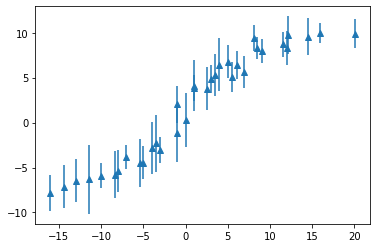

In [24]:
tuner = kt.Hyperband(
    bit_tuning_model(bit_model),
    objective=kt.Objective('val_mse', direction='min'),
    hyperband_iterations=1,
    max_epochs=200,
    factor=4,
    directory=root_dir / 'hyper_search',
    project_name=f'bit_2',   # will continue in this folder => each run needs a new name
    overwrite=False,  # CAUTION!
)
tuner.search_space_summary()

callbacks = callbacks = [
    tf.keras.callbacks.TensorBoard(profile_batch=0,),
    tf.keras.callbacks.EarlyStopping(patience=10),
]

tuner.search(
        pipeline_train,
        batch_size=BATCH_SIZE,
        steps_per_epoch=STEPS_PER_EPOCH,
        epochs=200,  # TODO: replace with `epochs=10` here to shorten fine-tuning for tutorial if you wish
        validation_data=pipeline_val,  # here we are only using 
                                       # this data to evaluate our performance
        workers=1,
        max_queue_size=10,
        verbose=2,
        callbacks=callbacks,
)

print(tuner.results_summary())
print(tuner.get_best_models(2)[0].summary())
print(tuner.get_best_models(2)[0].evaluate(pipeline_test))

eval_model(tuner.get_best_models(2)[0], pipeline_test)